In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

# Example-01: Twiss from amplitude data

In [3]:
# In this example uncoupled twiss beta function values are estimated from amplitude data
# Signals are generated using exact model with random noise added on top
# In this case resulting errors are due to the noise alone

# Given the TbT data, the main frequency and corresponding parameters (amplitudes and phases) are estimated for x & y planes
# Amplitude data is used to estimate twiss values
# Model twiss values are used to estimate action at each monitor location
# Total action is estimated using actions from all monitors with optional outlier filtering

# Alternatively, mesured twiss (e.g. from phase) can be used to estimate actions
# Or measured actions can be used directly

In [4]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [5]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883086, sigma_nux=6.30682891e-07, error_nux=1.23704027e-08

(ax - ref_ax).abs().sum().item()=0.000108287351

(fx - ref_fx).abs().sum().item()=0.0396317448



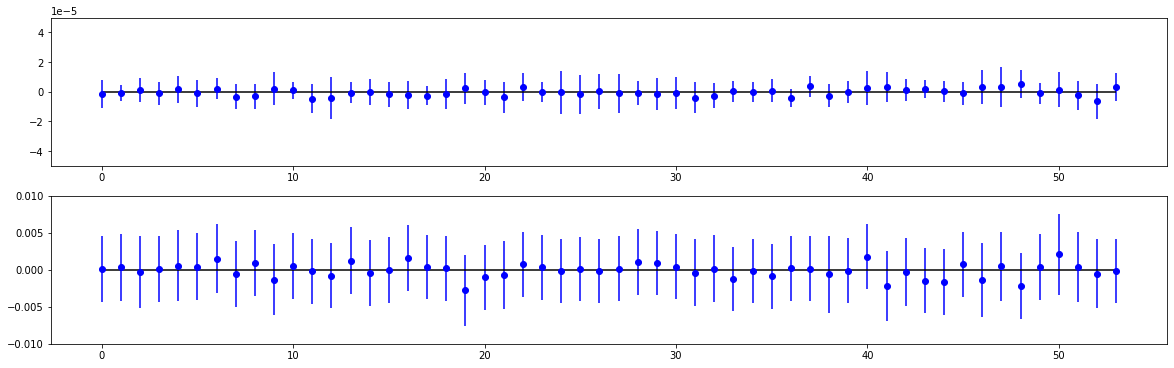

In [6]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774672, sigma_nuy=6.91235536e-07, error_nuy=3.87677013e-08

(ay - ref_ay).abs().sum().item()=0.000104863528

(fy - ref_fy).abs().sum().item()=0.0419912333



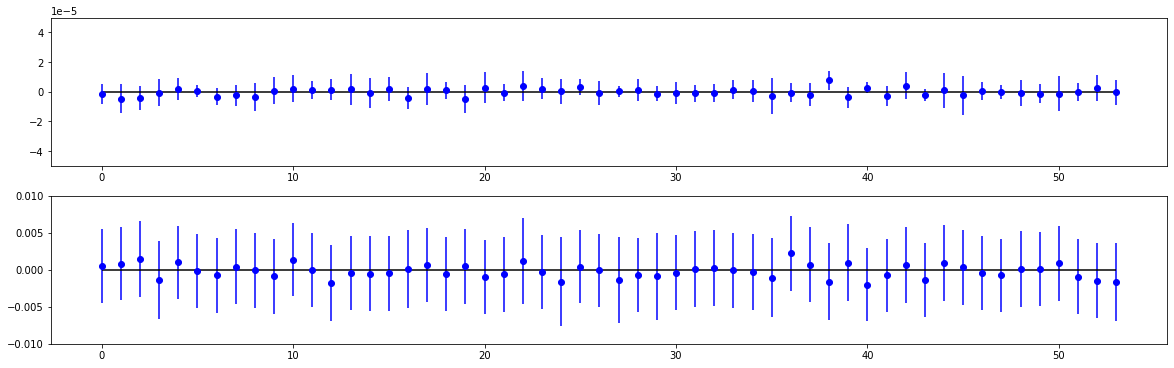

In [7]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

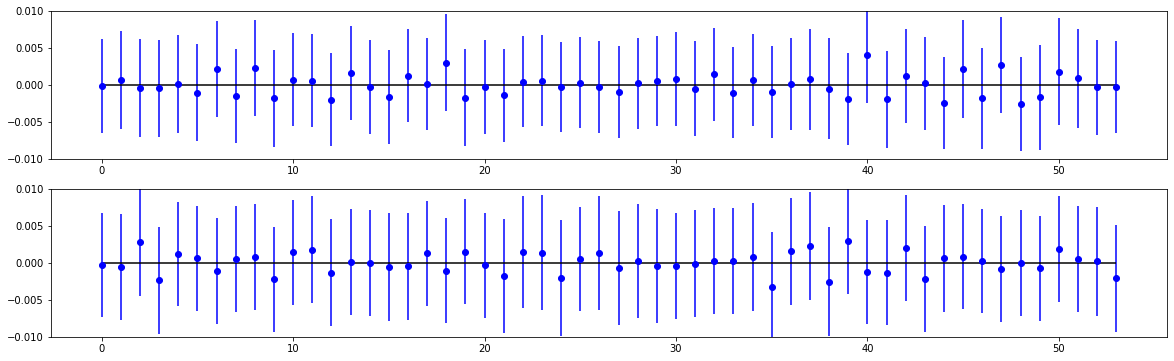

In [8]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [9]:
# Set twiss instance

twiss = Twiss(model, table, use_model=False)

dict_keys(['jx', 'sigma_jx', 'center_jx', 'spread_jx', 'jy', 'sigma_jy', 'center_jy', 'spread_jy', 'mask'])

(abs(ref_jx - center_jx)/ref_jx).item() = 0.000289838952
(abs(ref_jy - center_jy)/ref_jy).item() = 0.000101205424



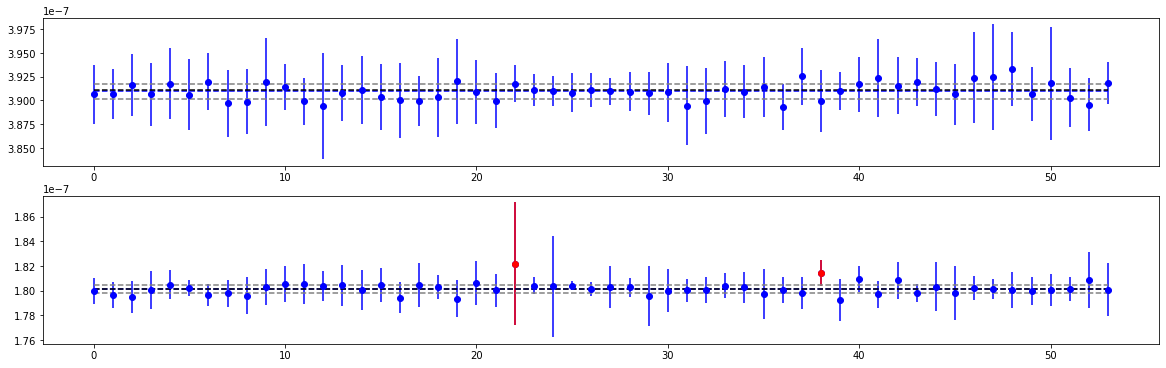

In [10]:
# Estimate action

twiss.get_action(dict_threshold={'use': True, 'factor': 3.0})
print(twiss.action.keys())
print()

jx, sigma_jx, center_jx, spread_jx = twiss.action['jx'], twiss.action['sigma_jx'], twiss.action['center_jx'], twiss.action['spread_jx']
jy, sigma_jy, center_jy, spread_jy = twiss.action['jy'], twiss.action['sigma_jy'], twiss.action['center_jy'], twiss.action['spread_jy']

ref_jx = (ref_ax**2/(2.0*model.bx[model.monitor_index])).mean()
ref_jy = (ref_ay**2/(2.0*model.by[model.monitor_index])).mean()

print(f'{(abs(ref_jx - center_jx)/ref_jx).item() = :12.9}')
print(f'{(abs(ref_jy - center_jy)/ref_jy).item() = :12.9}')
print()

mask_x, mask_y = twiss.action['mask'].logical_not()
out_jx, out_jy = torch.arange(model.monitor_count)[mask_x], torch.arange(model.monitor_count)[mask_y]

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), jx.cpu().numpy(), yerr=sigma_jx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(out_jx.cpu().numpy(), jx[out_jx].cpu().numpy(), yerr=sigma_jx[out_jx].cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.hlines([(center_jx - spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([center_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax1.hlines([(center_jx + spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([ref_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')


ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), jy.cpu().numpy(), yerr=sigma_jy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(out_jy.cpu().numpy(), jy[out_jy].cpu().numpy(), yerr=sigma_jy[out_jy].cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.hlines([(center_jy - spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([center_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax2.hlines([(center_jy + spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([ref_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')

plt.show()

dict_keys(['bx', 'sigma_bx', 'by', 'sigma_by'])

(bx - model.bx[model.monitor_index]).abs().sum().item()= 0.630264578
(by - model.by[model.monitor_index]).abs().sum().item()=  1.29792028



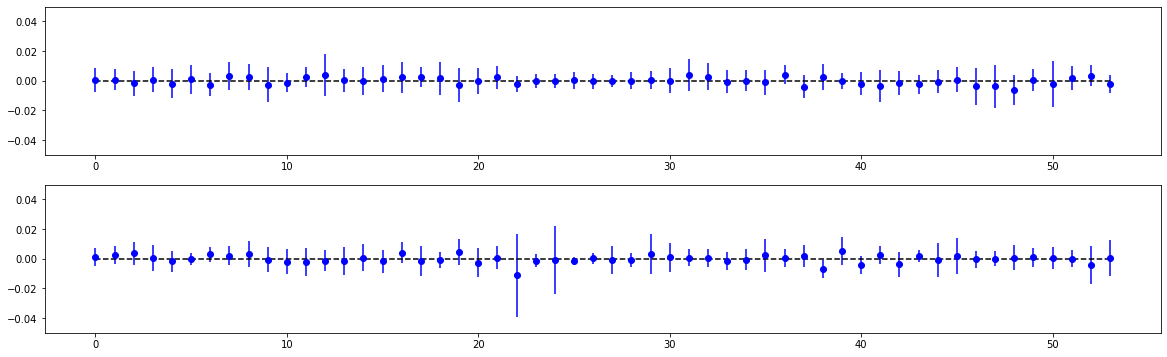

In [11]:
# Estimate twiss

twiss.get_twiss_from_amplitude()
print(twiss.data_amplitude.keys())
print()

bx, sigma_bx = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by, sigma_by = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

bx_m = model.bx[model.monitor_index]
by_m = model.by[model.monitor_index]

print(f'{(bx - model.bx[model.monitor_index]).abs().sum().item()=:12.9}')
print(f'{(by - model.by[model.monitor_index]).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), ((bx_m - bx)/bx_m).cpu().numpy(), yerr=(sigma_bx/bx_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax1.set_ylim(-0.05, +0.05)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), ((by_m - by)/by_m).cpu().numpy(), yerr=(sigma_by/by_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax2.set_ylim(-0.05, +0.05)

plt.show()

In [12]:
# Twiss values and errors can be passed to get_action()
# Data at monitor locations should be passed

twiss.get_action()
print([twiss.action['center_jx'].item(), twiss.action['center_jy'].item()])
print([twiss.action['spread_jx'].item(), twiss.action['spread_jy'].item()])

twiss.get_action(bx=model.bx[model.monitor_index], by=model.by[model.monitor_index], sigma_bx=model.sigma_bx[model.monitor_index], sigma_by=model.sigma_by[model.monitor_index])
print([twiss.action['center_jx'].item(), twiss.action['center_jy'].item()])
print([twiss.action['spread_jx'].item(), twiss.action['spread_jy'].item()])

[3.909487227999619e-07, 1.8018490116211007e-07]
[7.448010132201115e-10, 3.7963655206019855e-10]
[3.909487227999619e-07, 1.8018490116211007e-07]
[7.448010132201115e-10, 3.7963655206019855e-10]


# Example-02: Virtual phase and phase correction

In [13]:
# TbT data is only avalible at monitor locations
# Phase at other locations (virtual locations) can be estimated using measured phase at monitors and model phase advance between them
# For each virtual location, monitor locations around it are used to estimate virtual phase
# Given range limit, the corresponding number of monitors are used on each side around the probed virtual location

# Similary, monitor location itself can be treated as a virtual location, i.e. data from other locations can be used to possibly impove estimation at selected probed location
# Strong bias towards model is introduced in this case, i.e. phase correction should be avoided if real lattice is not close to the model

# In both cases, the range limit is passed to the method

In [14]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [15]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883154, sigma_nux=4.8879204e-07, error_nux=5.51145147e-08

(ax - ref_ax).abs().sum().item()=0.000110865889

(fx - ref_fx).abs().sum().item()=0.0448671217



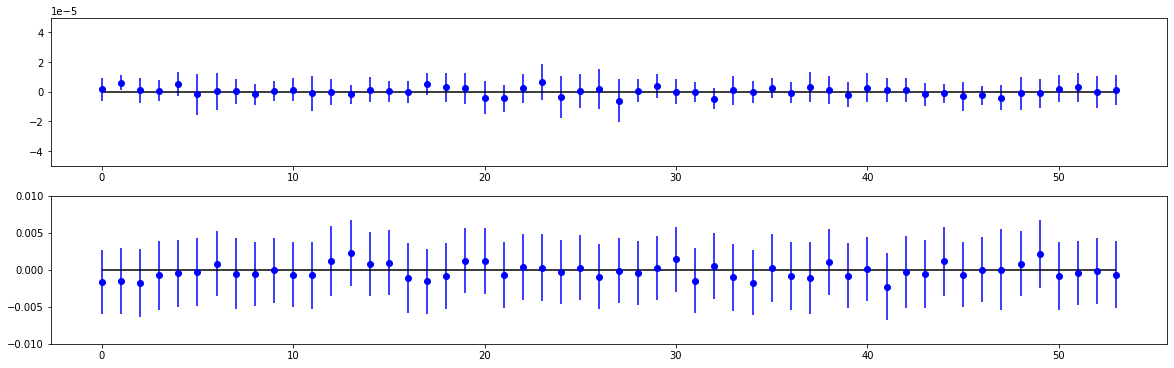

In [16]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774535, sigma_nuy=8.13911745e-07, error_nuy=9.78402412e-08

(ay - ref_ay).abs().sum().item()=9.38387847e-05

(fy - ref_fy).abs().sum().item()=0.0528595882



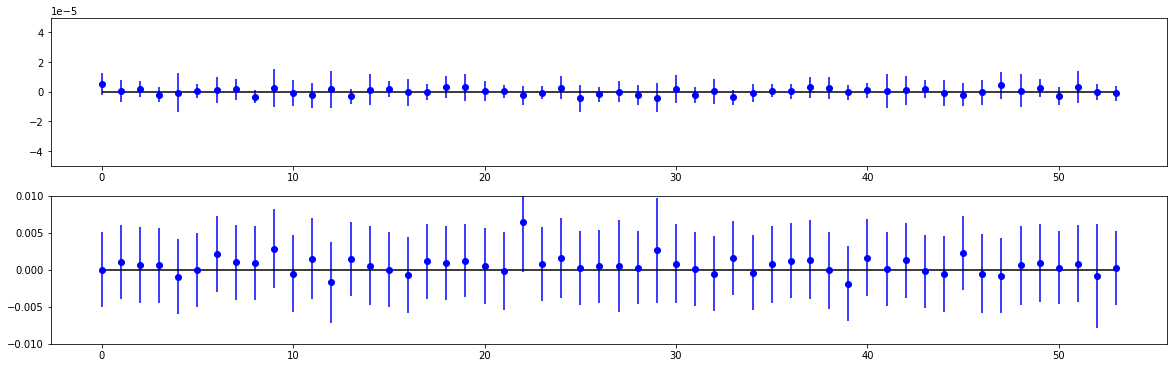

In [17]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

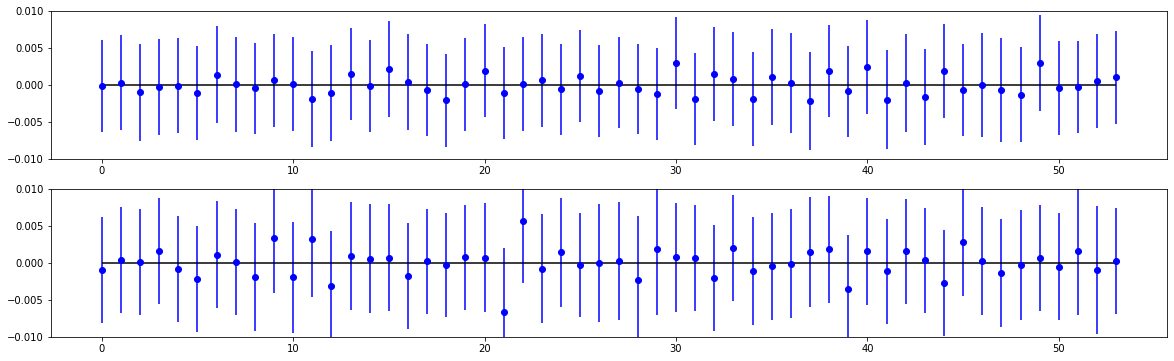

In [18]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [19]:
# Set twiss instance

twiss = Twiss(model, table)

In [20]:
# Print total number of virtual locations and corresponding index
# Note, the first and the last are special virtual locations ('HEAD' and 'TAIL')

print(twiss.model.virtual_count)
print(twiss.model.virtual_index)

# Compute virtual phase at each virtual location
# twiss.fx, twiss.fy and corresponding error are updated (zero at initialization at virtual location indices)
# twiss.correct_x and twiss.correct_y dictionaries with additional information are created or updated
# Note, kwargs can be passed to Decomposition.phase_virtual()

twiss.phase_virtual(limit=8, clean=True, factor=2.0)

5
[0, 2, 28, 54, 58]


dict_keys(['model', 'probe', 'limit', 'index', 'clean', 'phase', 'error'])
tensor([1.020492885446e+00, 8.560555384378e-04], dtype=torch.float64)
28
8
{20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36}
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


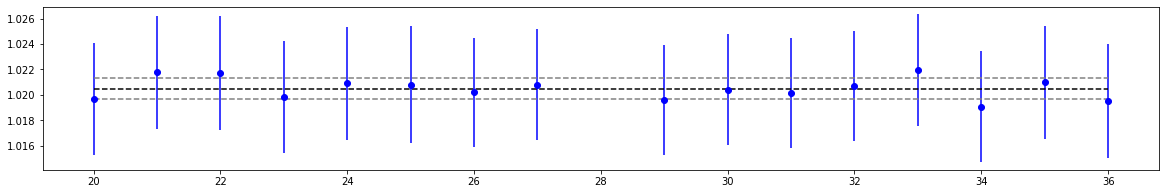

In [21]:
# Examine additional data for a virtual location at IP

_, _, index, *_ = twiss.model.virtual_index

# For each virtual location, addition data dictionary is stored

print(twiss.virtual_x[index].keys())

# Estimated value & error

print(twiss.virtual_x[index]['model'])

# Virtual location index

print(twiss.virtual_x[index]['probe'])

# Range limit

print(twiss.virtual_x[index]['limit'])

# Used locations {index: location}

print(twiss.virtual_x[index]['index'])

# Filter mask

print(twiss.virtual_x[index]['clean'].to(torch.int64))

# Plot phase data and error

keys = torch.tensor([*twiss.virtual_x[index]['index'].keys()], dtype=torch.int64)
mask = twiss.virtual_x[index]['clean'].logical_not()

center, spread = twiss.virtual_x[index]['model'].cpu().numpy()

plt.figure(figsize=(20, 3))
plt.errorbar(keys, twiss.virtual_x[index]['phase'].cpu().numpy(), yerr=twiss.virtual_x[index]['error'].cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(keys[mask], twiss.virtual_x[index]['phase'][mask].cpu().numpy(), yerr=twiss.virtual_x[index]['error'][mask].cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines([center - spread, center, center + spread], min(keys), max(keys), color=['grey', 'black', 'grey'], linestyles='dashed')
plt.show()

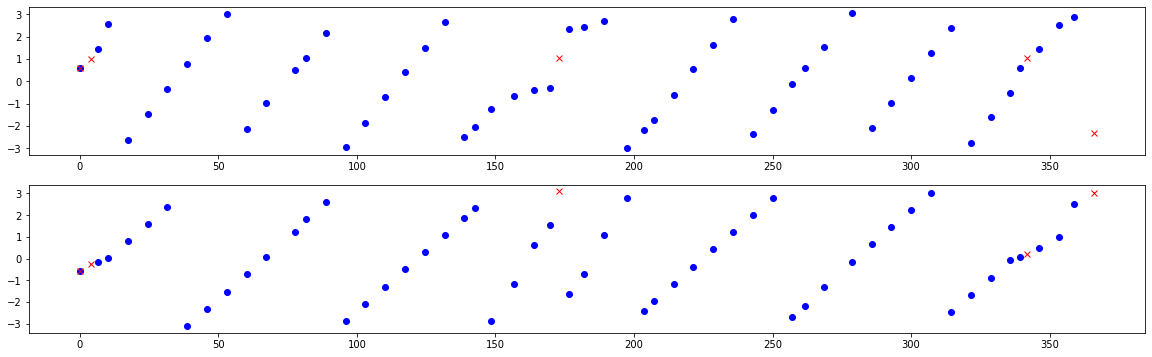

In [22]:
# Plot x & y phase for all locations vs location position

# blue -- monitor locations
# red  -- virtual locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fx[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fy[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fy[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

In [23]:
# Perform phase correction
# Note, kwargs are passed to Decomposition.phase_virtual()

# Similar to virtual phase computation, twiss.correct_x & twiss.correct_y dictionaries are created or updated
# twiss.fx_correct, twiss.fy_correct attributes and corresponding errors are created

twiss.phase_correct(limit=8, clean=True, factor=2.0)

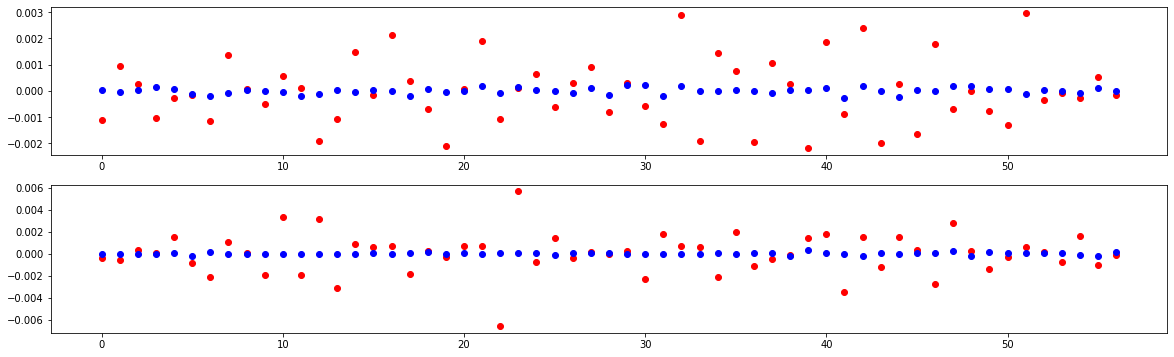

(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=0.0563974577
(muy - twiss.model.phase_y)[1:-1].abs().sum().item()= 0.076205888

(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=0.00487110165
(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=0.0044477541



In [24]:
# Compare adjacent phase advance for uncorrected and corrected case vs model (endpoints are dropped)

# Uncorrected

mux, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx)
muy, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy)

# Corrected

mux_correct, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx_corrected)
muy_correct, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy_corrected)

# Plot

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux)[1:-1].cpu().numpy(), color='red', marker='o')
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

ax2 = plt.subplot(212)
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy)[1:-1].cpu().numpy(), color='red', marker='o')
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

plt.show()

print(f'{(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-03: Twiss from phase data (adjacent)

In [25]:
# In this example, twiss parameters are computed from phase data using only adjacent monitors, i.e. range limit is one
# Results are compared with model
# Twiss beta values are also compared with twiss from amplitude data computation

In [26]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [27]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536882942, sigma_nux=7.18573294e-07, error_nux=1.56572035e-07

(ax - ref_ax).abs().sum().item()=0.000130416447

(fx - ref_fx).abs().sum().item()=0.0439716155



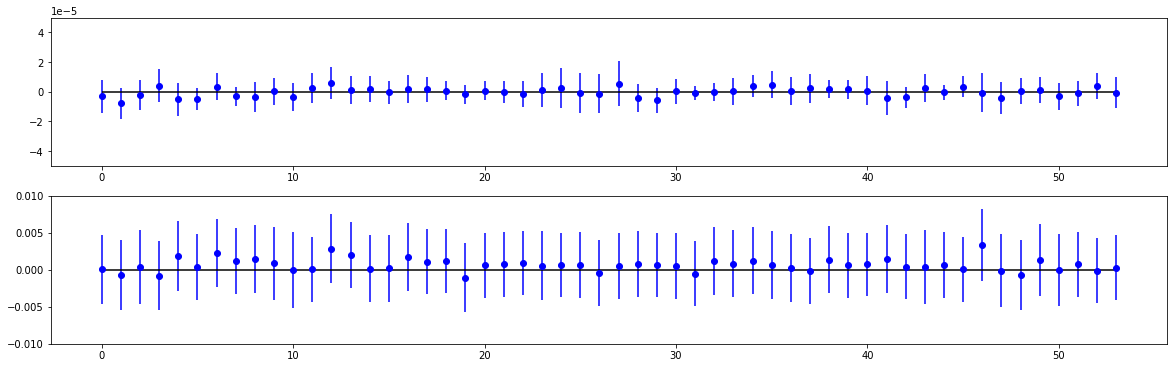

In [28]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774418, sigma_nuy=8.98843886e-07, error_nuy=2.15031477e-07

(ay - ref_ay).abs().sum().item()=9.91424385e-05

(fy - ref_fy).abs().sum().item()= 0.050776595



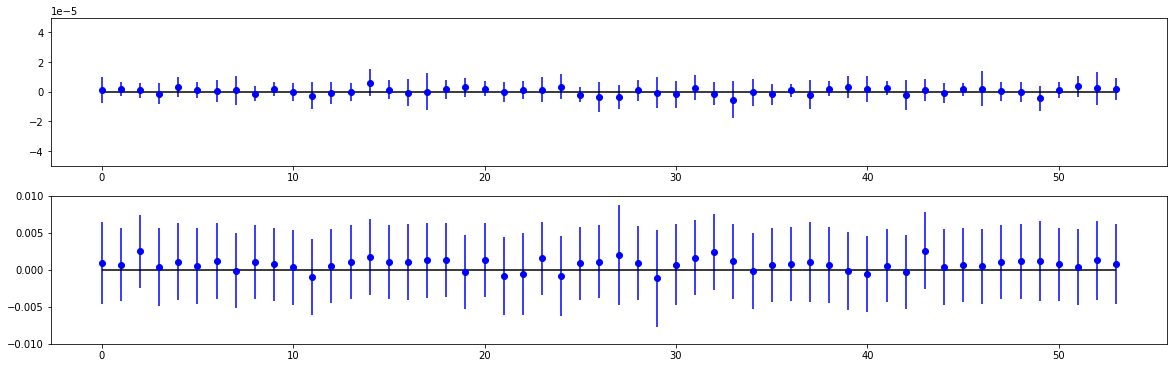

In [29]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

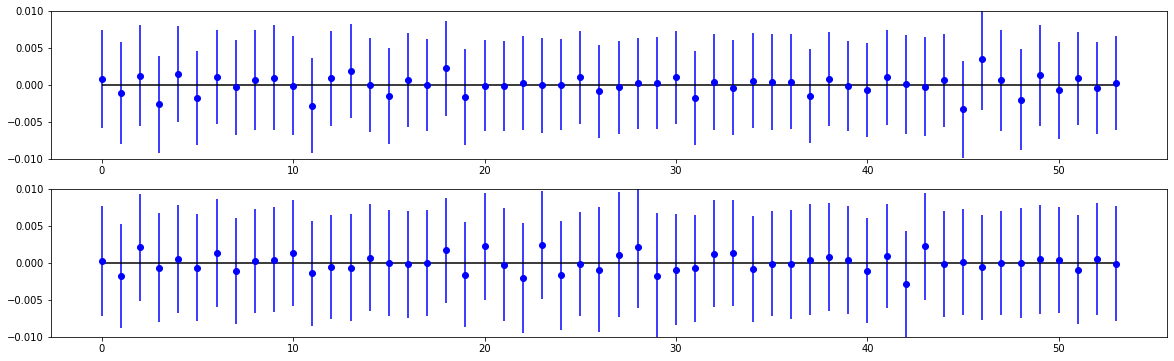

In [30]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [31]:
# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [32]:
# Invocation of get_twiss_from_phase sets twiss.data_phase dictionary
# This dictionary contains model and estimated results for each triplet (phase advance, twiss parameters and corresponding errors)

for key in twiss.data_phase:
    print(key)
    
# i -- probed index, j & k -- other used indices, each combination is given by two pairs (i, j) & (i, k), phase advance is always from i and is negative if i is behind j or k timewise

# fx_ij, fx_m_ij -- estimated and model phase advance for i to j or k for x plane and corresponding errors with 'sigma' prefix
# fy_ij, fy_m_ij -- estimated and model phase advance for i to j or k for y plane and corresponding errors with 'sigma' prefix

# ax, bx -- estimated twiss parameters and corresponding error for x plane and corresponding errors with 'sigma' prefix
# ay, by -- estimated twiss parameters and corresponding error for y plane and corresponding errors with 'sigma' prefix

fx_ij
sigma_fx_ij
fx_m_ij
sigma_fx_m_ij
fx_ik
sigma_fx_ik
fx_m_ik
sigma_fx_m_ik
fy_ij
sigma_fy_ij
fy_m_ij
sigma_fy_m_ij
fy_ik
sigma_fy_ik
fy_m_ik
sigma_fy_m_ik
ax
sigma_ax
bx
sigma_bx
ay
sigma_ay
by
sigma_by


In [33]:
# Since range limit is one here, each location has only one computed value

print(twiss.data_phase['bx'].shape)

torch.Size([59, 1])


In [34]:
# Note, here 'HEAD' virtual location is at the same place as the 1st monitor location
# Phase advance in this case is zero and twiss parameters are not meaningful for 'HEAD' virtual location

print(model.is_same(0, 1))

True


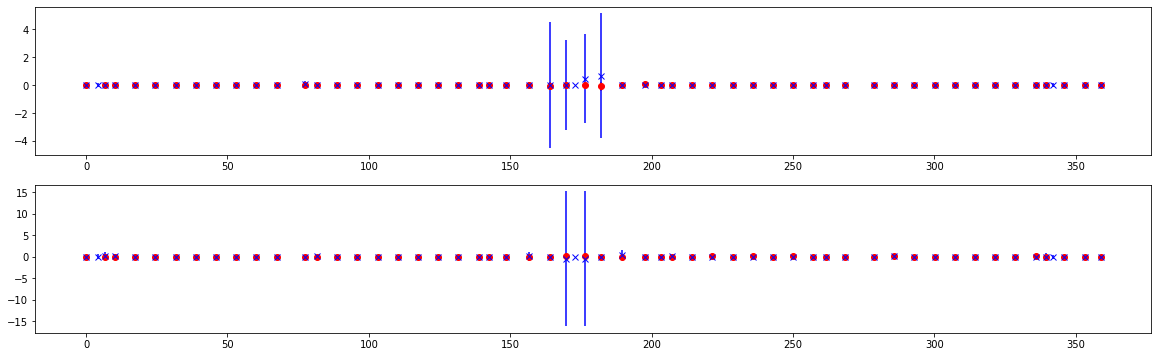

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=  0.84145138
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.18262287

(bx_m - bx_f)[1:-1].abs().sum().item()=  1.55261174
(by_m - by_f)[1:-1].abs().sum().item()=  2.25528278



In [35]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f)[1:-1].cpu().numpy(), yerr=sigma_bx_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f)[1:-1].cpu().numpy(), yerr=sigma_by_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

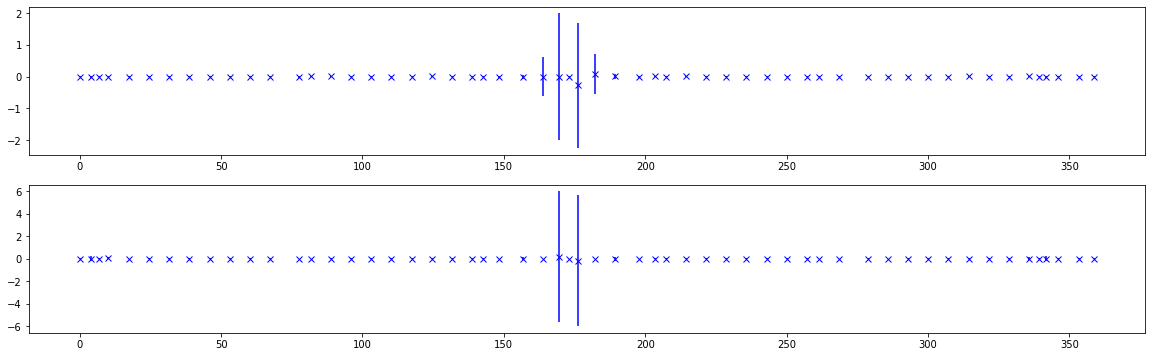

(ax_m - ax_f)[1:-1].abs().sum().item()=  0.46622079
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.554491771



In [36]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

# Twiss from phase

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f)[1:-1].cpu().numpy(), yerr=sigma_ax_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f)[1:-1].cpu().numpy(), yerr=sigma_ay_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-04: Twiss from phase data (range limit & phase correction)

In [37]:
# In this example several combinations (triplets = two diffrent pairs that include probe and two other) are used to estimate twiss parameters for given probed location
# For each combination twiss parameters and corresponding errors are computed
# Data from different combinations can be filtered (remove outlires) and processed (center and spread estimation)

# Twiss parameters are also computed using corrected phase
# Note, phase correction generates strong bias towards the used model
# In this example signals are generated using exact model and this bias is not manifested

In [38]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [39]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883066, sigma_nux=6.90225411e-07, error_nux=3.27869968e-08

(ax - ref_ax).abs().sum().item()=9.76038001e-05

(fx - ref_fx).abs().sum().item()=0.0264994951



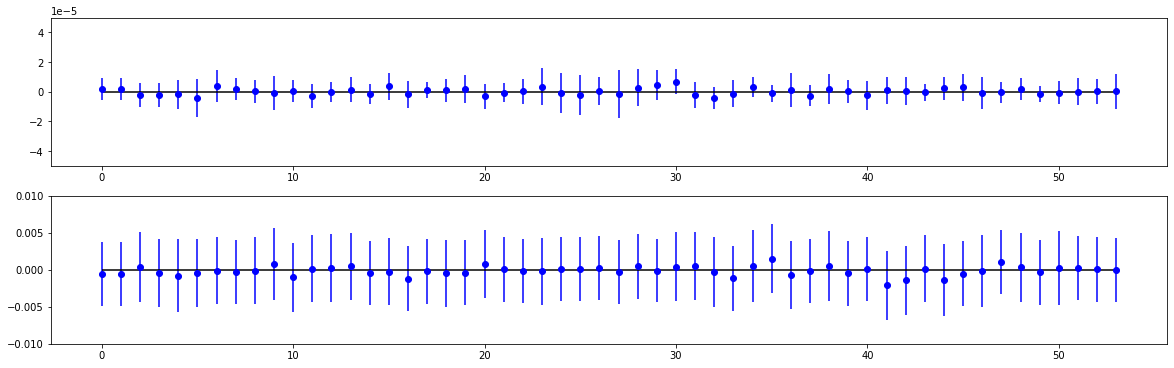

In [40]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774468, sigma_nuy=8.71505138e-07, error_nuy=1.65813309e-07

(ay - ref_ay).abs().sum().item()=0.000108886341

(fy - ref_fy).abs().sum().item()=0.0507088993



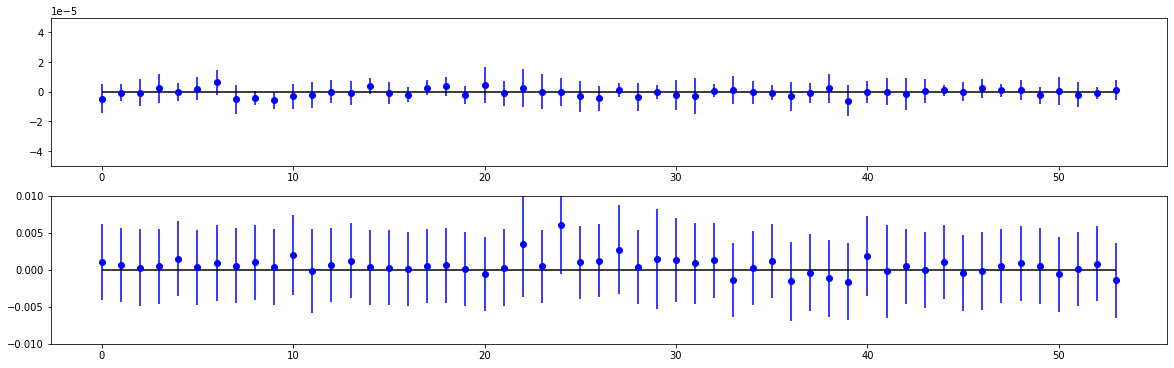

In [41]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

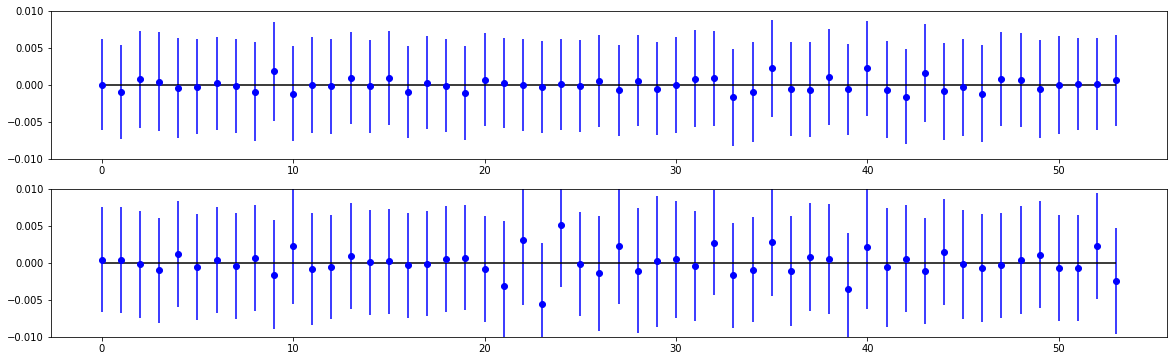

In [42]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [43]:
# Estimate twiss parameters using adjacent monitors
# For each probed location the closest monitor location is used on each side

# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

In [44]:
# Estimate using range of monitors
# Here, for each probed location 8 monitor locations are used on each side

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [45]:
# Note, for given range limit, the number of combinations is limit*(2*limit - 1)

print(max(twiss.limit))
print(max(twiss.limit)*(2*max(twiss.limit) - 1))
print(twiss.data_phase['bx'].shape)

8
120
torch.Size([59, 120])


In [46]:
# Pairs are also generated for each location
# Note, virtual locations do not appear as other indices
# Combinations are also sorted by limit

print(twiss.combo[0].shape)
print(twiss.combo[0, 0].cpu().numpy().tolist())
# [[i, j], [i, k]]

torch.Size([120, 2, 2])
[[0, -2], [0, 1]]


In [47]:
# Data filtering can be performed with filter_twiss method (filtering is performed for x or y plane at a time)
# This method returns a mask with True/False values, True if a combination passes all filtering methods and False otherwise
# This mask can be used as weights, i.e. combinations with False have zero weight

# Several filtering options are avaliable (by default all are used)
# Set 'use' value to True or False

mask_x = twiss.filter_twiss(plane='x',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

mask_y = twiss.filter_twiss(plane='y',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

# phase -- clean based on absolute cotangents value for (i, j) or (i, k) model and measured advance
# model -- clean based on advance proximity to model
# value -- clean based on beta proximity to model
# sigma -- clean based on estimated phase advance error value
# limit -- clean outliers outside interval computed using robust center and spread estimators

print(len(mask_x.flatten()), mask_x.count_nonzero().item())
print(len(mask_y.flatten()), mask_y.count_nonzero().item())

7080 6092
7080 5544


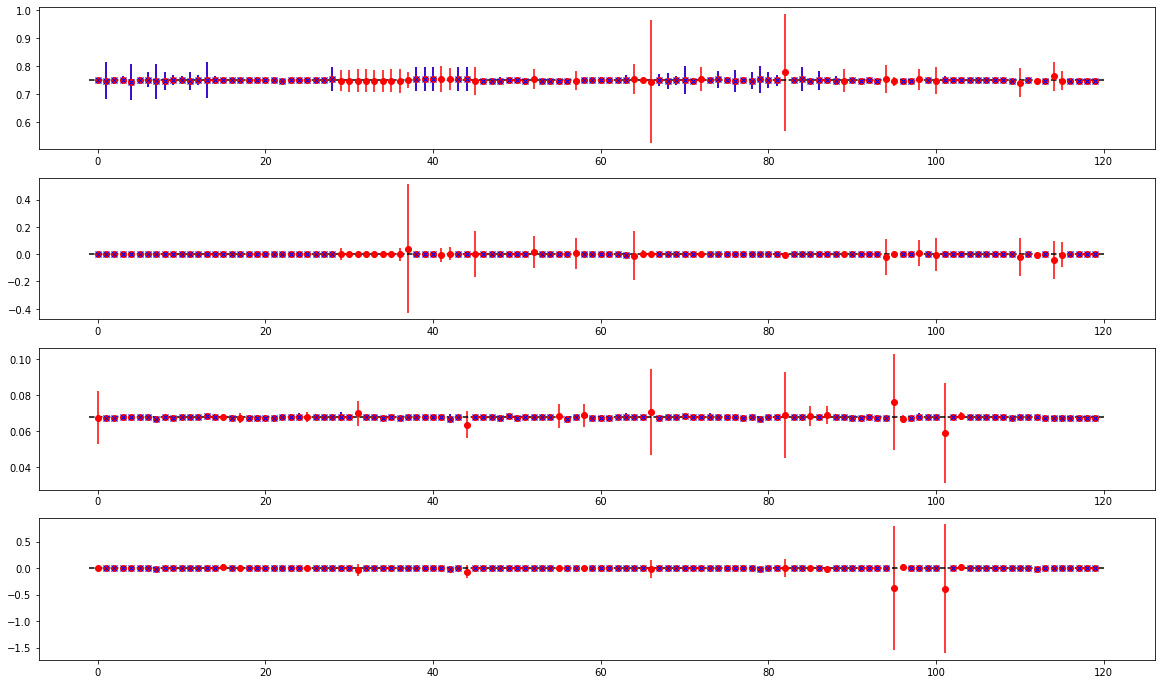

In [48]:
# Plot all combinations (red) and indicate selected (blue) for a selected location
# Note, 'HEAD' and 'TAIL' locations should not be used
# Change probe value

probe = 28

index = torch.arange(max(twiss.limit)*(2*max(twiss.limit) - 1), device=device)

bx, sigma_bx = twiss.data_phase['bx'][probe], twiss.data_phase['sigma_bx'][probe]
ax, sigma_ax = twiss.data_phase['ax'][probe], twiss.data_phase['sigma_ax'][probe]

by, sigma_by = twiss.data_phase['by'][probe], twiss.data_phase['sigma_by'][probe]
ay, sigma_ay = twiss.data_phase['ay'][probe], twiss.data_phase['sigma_ay'][probe]

plt.figure(figsize=(20, 3*4))

# bx
ax1 = plt.subplot(411)
ax1.errorbar(index.cpu().numpy(), bx.cpu().numpy(), yerr=sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
ax1.errorbar(index[mask_x[probe]].cpu().numpy(), bx[mask_x[probe]].cpu().numpy(), yerr=sigma_bx[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax1.hlines(model.bx[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ax
ax2 = plt.subplot(412)
ax2.errorbar(index.cpu().numpy(), ax.cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
ax2.errorbar(index[mask_x[probe]].cpu().numpy(), ax[mask_x[probe]].cpu().numpy(), yerr=sigma_ax[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax2.hlines(model.ax[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# by
ax3 = plt.subplot(413)
ax3.errorbar(index.cpu().numpy(), by.cpu().numpy(), yerr=sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
ax3.errorbar(index[mask_y[probe]].cpu().numpy(), by[mask_y[probe]].cpu().numpy(), yerr=sigma_by[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax3.hlines(model.by[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ay
ax4 = plt.subplot(414)
ax4.errorbar(index.cpu().numpy(), ay.cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
ax4.errorbar(index[mask_y[probe]].cpu().numpy(), ay[mask_y[probe]].cpu().numpy(), yerr=sigma_ay[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax4.hlines(model.ay[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

plt.show()

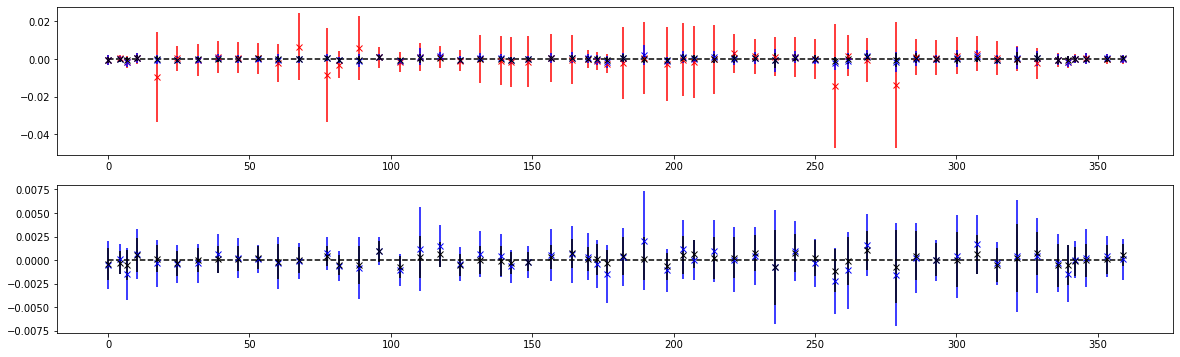

(bx_m - bx_1)[1:-1].abs().sum().item()= 0.891693969
(bx_m - bx_2)[1:-1].abs().sum().item()= 0.356907627
(bx_m - bx_3)[1:-1].abs().sum().item()= 0.228348634



In [49]:
# Twiss data processing can be performed with process_twiss method
# This method returns the result as a dictionary
# dict_keys(['value_a', 'sigma_a', 'error_a', 'value_b', 'sigma_b', 'error_b'])
# And updates self.ax, self.bx, self.ay, self.by and corresponding errors
# Processing is done for one plane ('x' or 'y') at a time

# This method uses weighted estimator for center and spread
# If weight is True, estimated errors for each combinations are used as weights
# If mask is provided, it is used as weights (weight is False) or weights are multiplied by given mask (weight is True)
# Combinations with False values thus have zero weight

# Compare different processing options

# No filtering or weights

out1 = twiss.process_twiss(plane='x', mask=None, weight=False)

# Filter mask is used as weights

out2 = twiss.process_twiss(plane='x', mask=mask_x, weight=False)

# Weights for each combitations are multiplied by filter mask

out3 = twiss.process_twiss(plane='x', mask=mask_x, weight=True)

bx_m = twiss.model.bx

bx_1, sigma_bx_1 = out1['value_b'], out1['sigma_b']
bx_2, sigma_bx_2 = out2['value_b'], out2['sigma_b']
bx_3, sigma_bx_3 = out3['value_b'], out3['sigma_b']

# red - 1, blue - 2, black - 3

plt.figure(figsize=(20, 3*2))

# 1 & 2 & 3
ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_1)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_1/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax1.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

# 2 & 3
ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax2.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

plt.show()

print(f'{(bx_m - bx_1)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_2)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_3)[1:-1].abs().sum().item()=:12.9}')
print()

In [50]:
# Compare different cases of twiss computation

# 1 -- from amplitude
# 2 -- from phase (range limit)
# 3 -- from phase (range limit & correction)

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.phase_correct()

# Uncorrected 

twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_combo, sigma_ax_f_combo = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_combo, sigma_bx_f_combo = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_combo, sigma_ay_f_combo = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_combo, sigma_by_f_combo = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

# Corrected

twiss.get_twiss_from_phase(use_correct=True)
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_correct, sigma_ax_f_correct = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_correct, sigma_bx_f_correct = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_correct, sigma_ay_f_correct = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_correct, sigma_by_f_correct = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()= 0.610314341
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.34138355

(bx_m - bx_f)[1:-1].abs().sum().item()=  0.96986129
(by_m - by_f)[1:-1].abs().sum().item()=  2.26962003

(bx_m - bx_f_combo)[1:-1].abs().sum().item()= 0.228348634
(by_m - by_f_combo)[1:-1].abs().sum().item()= 0.587657818

(bx_m - bx_f_correct)[1:-1].abs().sum().item()=0.0262937441
(by_m - by_f_correct)[1:-1].abs().sum().item()=0.0553285505



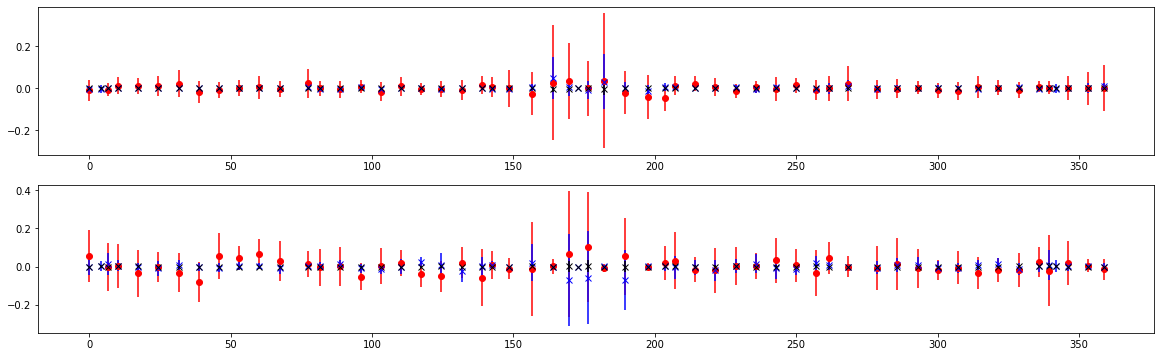

In [51]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_combo)[1:-1].cpu().numpy(), yerr=sigma_bx_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_correct)[1:-1].cpu().numpy(), yerr=sigma_bx_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_combo)[1:-1].cpu().numpy(), yerr=sigma_by_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_correct)[1:-1].cpu().numpy(), yerr=sigma_by_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.323230359
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.589475107

(ax_m - ax_f_combo)[1:-1].abs().sum().item()= 0.061669132
(ay_m - ay_f_combo)[1:-1].abs().sum().item()= 0.144268164

(ax_m - ax_f_correct)[1:-1].abs().sum().item()=0.00859929759
(ay_m - ay_f_correct)[1:-1].abs().sum().item()=0.0136680897



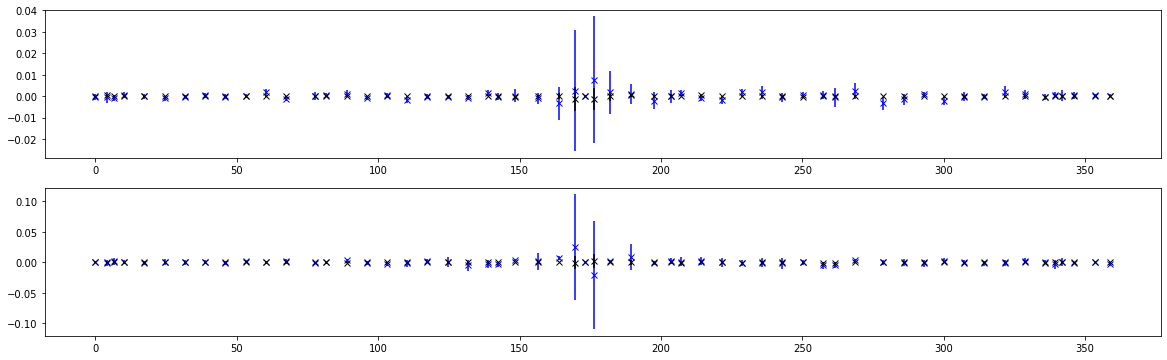

In [52]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ax_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ax_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ay_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ay_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

In [53]:
# Using several combinations can significanty impove twiss estimation accuracy based on phase data
# In this example random noise is the only error source
# Since signals are generated using the model, phase correction improves accuracy significantly in this case

# Example-05: Default twiss (__call__ method)

In [54]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [55]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [56]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883154, sigma_nux=6.73394997e-07, error_nux=5.56975916e-08

(ax - ref_ax).abs().sum().item()=0.000115019054

(fx - ref_fx).abs().sum().item()=0.0407508299



In [57]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774606, sigma_nuy=6.59245231e-07, error_nuy=2.751037e-08

(ay - ref_ay).abs().sum().item()=0.00010917337

(fy - ref_fy).abs().sum().item()=0.0430041587



In [58]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [59]:
# Default twiss (compute action, beta from amplitude, virtual phase, corrected phase and twiss from phase)

twiss = Twiss(model, table, limit=8)
twiss()

,name,kind,flag,time,ax,sigma_ax,bx,sigma_bx,fx,sigma_fx,ay,sigma_ay,by,sigma_by,fy,sigma_fy
0,HEAD,VIRTUAL,0,0.000000,-0.676978,0.002456,7.454189,0.022433,0.595824,0.001227,0.654598,0.001700,15.858694,0.031419,-0.579505,0.000910
1,STP2,MONITOR,1,0.000000,-0.677235,0.002549,7.457103,0.022571,0.595957,0.004458,0.654660,0.001119,15.861055,0.025344,-0.579418,0.004980
2,IV4P,VIRTUAL,0,4.153500,1.952173,0.005456,14.215995,0.042270,0.981764,0.001230,-2.760947,0.007631,13.858979,0.033809,-0.275732,0.000918
3,STP4,MONITOR,1,6.667000,0.377629,0.002901,3.119230,0.015647,1.436374,0.004722,3.092889,0.006736,30.447449,0.076526,-0.172318,0.004943
4,SRP1,MONITOR,1,10.190565,-0.803247,0.004083,4.735487,0.024076,2.561956,0.004422,1.836876,0.005937,13.260778,0.049866,0.003696,0.005033
5,SRP2,MONITOR,1,17.337624,-0.717555,0.003019,4.553943,0.015080,-2.623603,0.004957,1.836837,0.006533,13.274200,0.048464,0.797279,0.005016
6,SRP3,MONITOR,1,24.484683,-0.769231,0.002652,4.487207,0.015207,-1.466679,0.004695,1.846298,0.004951,13.317456,0.030811,1.587811,0.004967
7,SRP4,MONITOR,1,31.631742,-0.787190,0.001628,4.756675,0.012539,-0.354842,0.004504,1.847124,0.003084,13.303362,0.021935,2.378686,0.005079
8,SRP5,MONITOR,1,38.778801,-0.714542,0.002479,4.484446,0.011954,0.756768,0.004718,1.843019,0.003531,13.273473,0.030971,-3.112233,0.005111
9,SRP6,MONITOR,1,45.925860,-0.791023,0.002756,4.556823,0.015743,1.915023,0.004744,1.837952,0.004447,13.282504,0.031010,-2.316570,0.005107


In [60]:
# Get twiss parameter by index/name

print(twiss.get_ax(28))
print(twiss.get_ax('IP'))

tensor([-7.226829808179e-05,  7.066381899508e-04], dtype=torch.float64)
tensor([-7.226829808179e-05,  7.066381899508e-04], dtype=torch.float64)


In [61]:
# Get all twiss parameters by index/name

for key, value in twiss.get_twiss(28).items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()
    
for key, value in twiss.get_twiss('IP').items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()

ax          : -7.22682981e-05
sigma_ax    : 0.00070663819
bx          :  0.749165885
sigma_bx    : 0.00172123183
fx          :   1.02025331
sigma_fx    : 0.000806434905
ay          : -5.25137163e-05
sigma_ay    : 0.00145564116
by          : 0.0677936786
sigma_by    : 0.000248196595
fy          :   3.10021839
sigma_fy    : 0.00144737282

ax          : -7.22682981e-05
sigma_ax    : 0.00070663819
bx          :  0.749165885
sigma_bx    : 0.00172123183
fx          :   1.02025331
sigma_fx    : 0.000806434905
ay          : -5.25137163e-05
sigma_ay    : 0.00145564116
by          : 0.0677936786
sigma_by    : 0.000248196595
fy          :   3.10021839
sigma_fy    : 0.00144737282



# Example-06: Twiss from phase data (precomputed model & weight mask)

In [62]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [63]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [64]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883014, sigma_nux=6.57026129e-07, error_nux=8.47069896e-08

(ax - ref_ax).abs().sum().item()=9.8301419e-05

(fx - ref_fx).abs().sum().item()=0.0361871765



In [65]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774554, sigma_nuy=7.05364112e-07, error_nuy=7.94942403e-08

(ay - ref_ay).abs().sum().item()=9.28419356e-05

(fy - ref_fy).abs().sum().item()=0.0369849419



In [66]:
# Set model & table
# If limit is passed, model phase advance data is computed

model = Model(path='../config.yaml', limit=8, dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [67]:
# Set twiss
# Keep combinations with distance 2, 3 and 4
# Note, with get_twiss_from_phase(use_model=True), precomputed model phase advance is used

twiss = Twiss(model, table, limit=(1, 4), use_model=True)
print(model.combo.shape)
print(twiss.combo.shape)

torch.Size([59, 120, 2, 2])
torch.Size([59, 27, 2, 2])


In [68]:
# Set twiss with external flags
# External flags can be used to mark monitors with anomalies
# If flag is passed, mask for all combinations is generated with zero weight for combinations having marked locations as other
# This mask can be used for twiss processing

flag = torch.clone(model.flag)
flag[10] = 0

twiss = Twiss(model, table, limit=1, use_model=True, flag=flag)
print(twiss.mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[twiss.mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [69]:
# This mask can be generated with mask_location method

mask = twiss.mask_location([10])
print(mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [70]:
# Mask based on limit range

# Set twiss

twiss = Twiss(model, table, limit=2, use_model=True)

# Generate mask with zeros for limit one

mask, *_ = twiss.mask_range((1, 2))
print(mask)

# Generate mask with zeros for limit two

mask, *_ = twiss.mask_range((1, 1))
print(mask)

tensor([0, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 0])


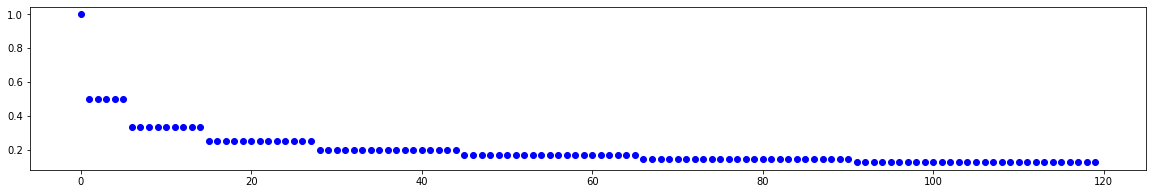

In [71]:
# Mask based on distance

# Set twiss

twiss = Twiss(model, table, limit=8, use_model=True)

# Generate mask

mask, *_ = twiss.mask_distance(lambda x: 1/x)

# Plot weights

plt.figure(figsize=(20, 3))
plt.scatter(range(len(mask)), mask.cpu().numpy(), color='blue')
plt.show()

# Example-07: Bias vs range limit & informed action estimation

In [72]:
# In this example TbT data generated from model with errors is used for twiss inference (without random noise)

# In the case of twiss estimation from phase data, increasing range limit value introduces bias in general
# This bias tends to increase with range limit, but optimal limit might not be equal to one

# In the case of twiss estimation from amplitude data, model twiss is used for action estimation
# If the actual twiss values are off, action estimation is poor and all estimated twiss values are shifted
# Twiss from phase can be used for informed action estimation is this case

In [73]:
# Import correct twiss data at monitor locations

bx_m, ax_m, fx_m, by_m, ay_m, fy_m = numpy.load('../twiss.npy').T

In [74]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../error_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [75]:
# Set near zero noise

noise_x = 1.0E-15*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-15*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.544331291, sigma_nux=5.28138579e-10, error_nux=3.11100035e-11

(ax - ref_ax).abs().sum().item()=4.20373103e-08

(fx - ref_fx).abs().sum().item()=5.50172845e-06



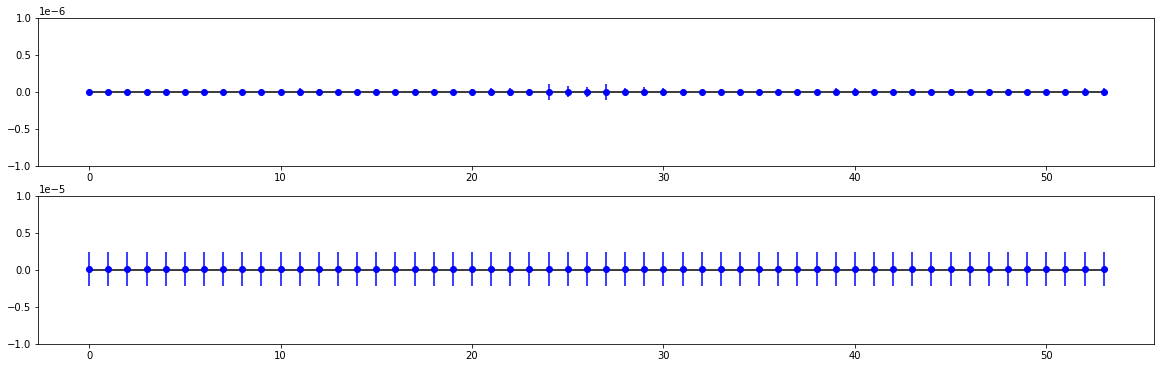

In [76]:
# Compute frequency, amplitude and phase for x plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

nuy= 0.574277342, sigma_nuy=1.42758561e-10, error_nuy=1.42219569e-12

(ay - ref_ay).abs().sum().item()=3.30818121e-10

(fy - ref_fy).abs().sum().item()=2.46965934e-07



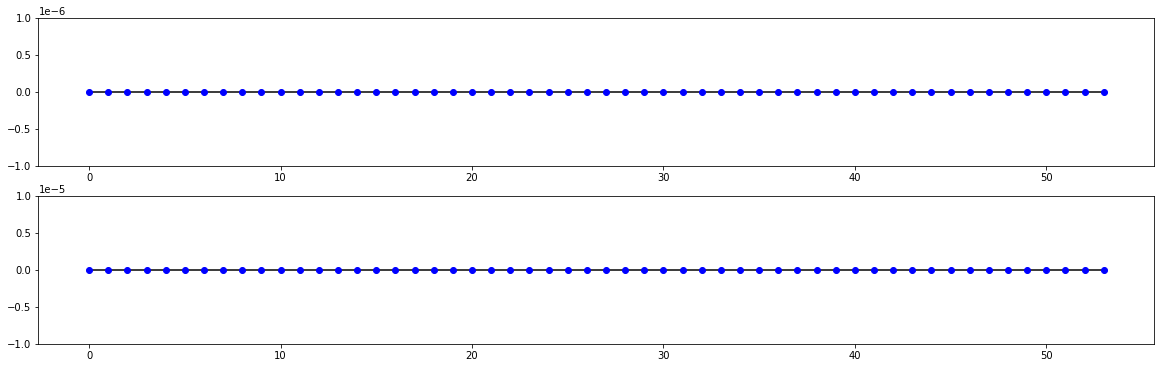

In [77]:
# Compute frequency, amplitude and phase for y plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

In [78]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

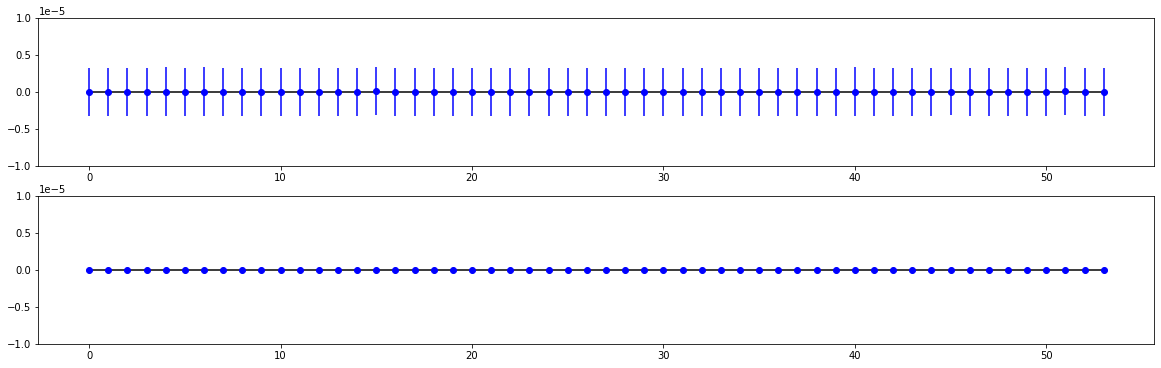

In [79]:
# Compare phase advance between adjacent monitor locations with correct data

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (fx_m - table.phase_x.cpu().numpy()), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-5, +1.0E-5)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy_m - table.phase_y.cpu().numpy()), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)

plt.show()

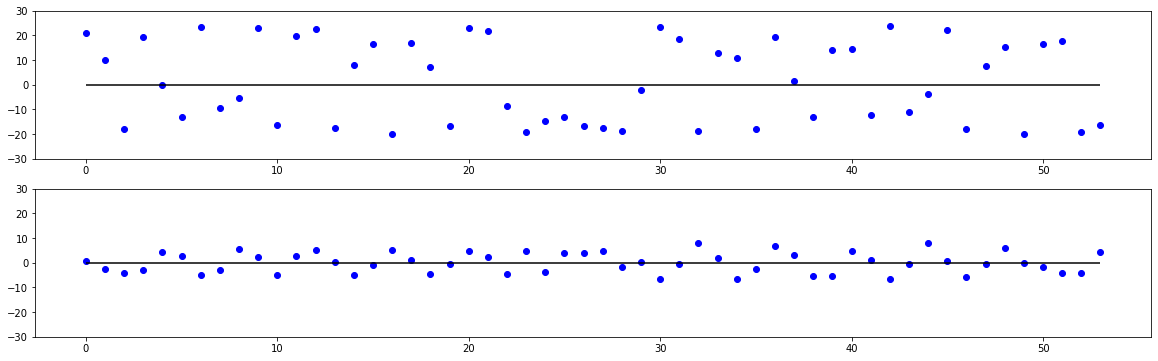

In [80]:
# Compare model twiss with correct twiss

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(model.monitor_count), 100*(bx_m - model.bx[model.monitor_index].cpu().numpy())/model.bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-30, +30)

ax2 = plt.subplot(212)
ax2.scatter(range(model.monitor_count), 100*(by_m - model.by[model.monitor_index].cpu().numpy())/model.by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-30, +30)

plt.show()

In [81]:
# Compute twiss from phase data using different range limit (upto 32)

box = []

for limit in range(1, 32 + 1):

    twiss = Twiss(model, table, limit=limit)

    twiss.phase_virtual()
    twiss.get_twiss_from_phase()
    mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
    mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})

    if twiss.limit != (1, 1):

        twiss.process_twiss(plane='x', mask=mask_x, weight=True)
        twiss.process_twiss(plane='y', mask=mask_y, weight=True)

    else:

        twiss.ax = twiss.data_phase['ax'].flatten()
        twiss.bx = twiss.data_phase['bx'].flatten()
        twiss.ay = twiss.data_phase['ay'].flatten()
        twiss.by = twiss.data_phase['by'].flatten()

        twiss.sigma_ax = twiss.data_phase['sigma_ax'].flatten()
        twiss.sigma_bx = twiss.data_phase['sigma_bx'].flatten()
        twiss.sigma_ay = twiss.data_phase['sigma_ay'].flatten()
        twiss.sigma_by = twiss.data_phase['sigma_by'].flatten()

    bx = twiss.bx[model.monitor_index].cpu().numpy()
    ax = twiss.ax[model.monitor_index].cpu().numpy()
    by = twiss.by[model.monitor_index].cpu().numpy()
    ay = twiss.ay[model.monitor_index].cpu().numpy()

    sigma_bx = twiss.sigma_bx[model.monitor_index].cpu().numpy()
    sigma_ax = twiss.sigma_ax[model.monitor_index].cpu().numpy()
    sigma_by = twiss.sigma_by[model.monitor_index].cpu().numpy()
    sigma_ay = twiss.sigma_ay[model.monitor_index].cpu().numpy()

    box.append(numpy.array([[bx, sigma_bx], [ax, sigma_ax], [by, sigma_by], [ay, sigma_ay]]))
    
    if limit <= 8:
        print(f'limit= {limit}: {"model":>12} {"error":>12}')
        print(f'error_bx: {numpy.abs(model.bx[model.monitor_index].cpu() - bx).sum().item():12.9} {numpy.abs(bx_m - bx).sum().item():12.9}')
        print(f'error_by: {numpy.abs(model.by[model.monitor_index].cpu() - by).sum().item():12.9} {numpy.abs(by_m - by).sum().item():12.9}')
        print(f'error_ax: {numpy.abs(model.ax[model.monitor_index].cpu() - ax).sum().item():12.9} {numpy.abs(ax_m - ax).sum().item():12.9}')
        print(f'error_ay: {numpy.abs(model.ay[model.monitor_index].cpu() - ay).sum().item():12.9} {numpy.abs(ay_m - ay).sum().item():12.9}')
        print()

box = numpy.array(box).T

# As it can be seen, for larger range limit value, bias increases
# Since the effect of noise in this example can be neglected, the discrepancy is only due to the bias
# Still, using limit=1 doesn't provide optimal accuracy
# In this example limit=2 is optimal, for larger values bias is stronger

limit= 1:        model        error
error_bx:    80.560706  0.998768979
error_by:   29.9780695   3.57418072
error_ax:   18.8607726  0.167695822
error_ay:   5.98873447   0.55435965

limit= 2:        model        error
error_bx:   80.4203944  0.832648786
error_by:   29.0691033    2.1866305
error_ax:   18.8437274  0.211482811
error_ay:   5.80504345  0.318353795

limit= 3:        model        error
error_bx:   78.0122699   3.03292658
error_by:   29.9588942   3.22411548
error_ax:   18.0394525   1.03405142
error_ay:    6.2059565  0.664070842

limit= 4:        model        error
error_bx:    80.760411   2.58694255
error_by:   30.0307864   3.41937726
error_ax:   19.5903965   1.02884437
error_ay:   6.19538047   0.63997848

limit= 5:        model        error
error_bx:   83.5730719   3.82192152
error_by:   29.5518592   3.15102337
error_ax:   19.8256168   1.09535377
error_ay:    5.9290075  0.506343678

limit= 6:        model        error
error_bx:   84.5579541   4.98245984
error_by:   29.7464104 

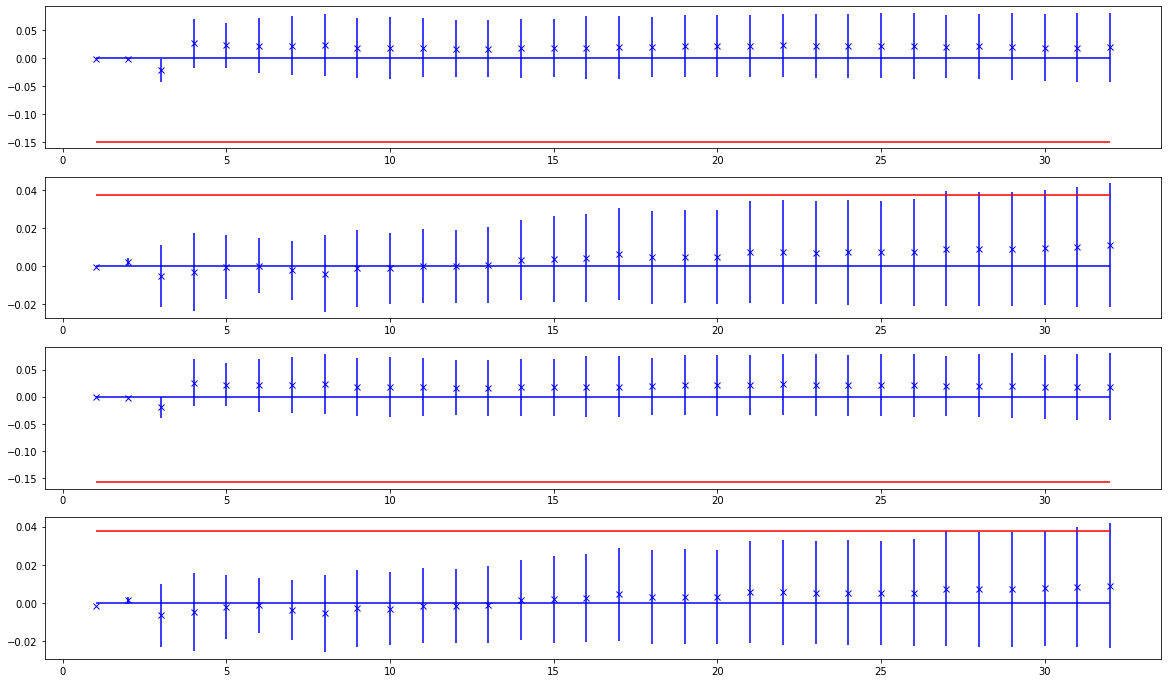

In [82]:
# Examine data for selected location

index = 25
out, sigma_out = box[index]

bx, ax, by, ay = out
sigma_bx, sigma_ax, sigma_by, sigma_ay = sigma_out

plt.figure(figsize=(20, 4*3))

ax1 = plt.subplot(411)
ax1.errorbar(range(1, 1 + len(bx)), (bx_m[index] - bx)/bx_m[index], yerr=sigma_bx/bx_m[index], fmt=' ', marker='x', color='blue')
ax1.hlines(0, 1, len(bx), colors='blue')
ax1.hlines((bx_m[index] - model.bx[model.monitor_index][index].cpu())/bx_m[index], 1, len(bx), colors='red')

ax2 = plt.subplot(412)
ax2.errorbar(range(1, 1 + len(by)), (by_m[index] - by)/by_m[index], yerr=sigma_by/by_m[index], fmt=' ', marker='x', color='blue')
ax2.hlines(0, 1, len(by), colors='blue')
ax2.hlines((by_m[index] - model.by[model.monitor_index][index].cpu())/by_m[index], 1, len(by), colors='red')

ax3 = plt.subplot(413)
ax3.errorbar(range(1, 1 + len(ax)), (ax_m[index] - ax)/ax_m[index], yerr=sigma_ax/ax_m[index], fmt=' ', marker='x', color='blue')
ax3.hlines(0, 1, len(ax), colors='blue')
ax3.hlines((ax_m[index] - model.ax[model.monitor_index][index].cpu())/ax_m[index], 1, len(bx), colors='red')

ax4 = plt.subplot(414)
ax4.errorbar(range(1, 1 + len(ay)), (ay_m[index] - ay)/ay_m[index], yerr=sigma_ay/ay_m[index], fmt=' ', marker='x', color='blue')
ax4.hlines(0, 1, len(ay), colors='blue')
ax4.hlines((ay_m[index] - model.ay[model.monitor_index][index].cpu())/ay_m[index], 1, len(bx), colors='red')

plt.show()

# Note, this bias will decrease for corrected lattice

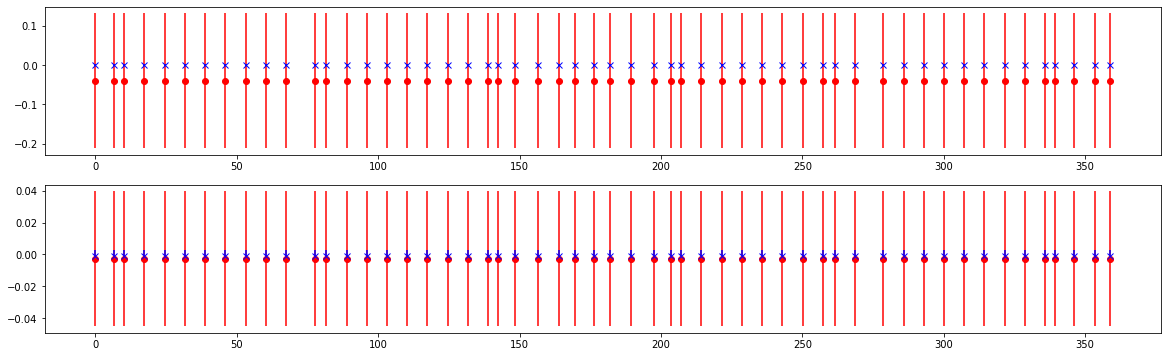

In [83]:
# Compute twiss from amplitude using twiss from phase data for action estimation

# Set twiss instance

twiss = Twiss(model, table, limit=4)


# Compute twiss from phase data
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)


# Twiss from amplitude using model for action estimation

twiss.get_action()
twiss.get_twiss_from_amplitude()
bx_1 = twiss.data_amplitude['bx'].cpu().numpy()
by_1 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_1 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_1 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Twiss from amplitude using twiss from phase for action estimation

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()
bx_2 = twiss.data_amplitude['bx'].cpu().numpy()
by_2 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_2 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_2 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Compare

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_1)/bx_m, yerr=sigma_bx_1/bx_m, fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_2)/bx_m, yerr=sigma_bx_2/bx_m, fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_1)/by_m, yerr=sigma_by_1/by_m, fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_2)/by_m, yerr=sigma_by_2/by_m, fmt=' ', marker='x', color='blue')

plt.show()

# Note, bias from action estimation (all values are shifted) is corrected

# Example-08: Twiss from test signals

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# This example is similar to the previous one, but test tbt data is generated using Model functions

In [4]:
# Set model

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

model.make_kick(5.0E-4, 1.0E-4)
model.apply_error(split=True)

# Compute one-turn matrix

model.make_turn()

# Compute twiss (not used in generation of trajectories)

flag = model.make_twiss()
print(flag)

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(length, initial)

True


In [5]:
# Set correct twiss data at monitor locations

from harmonica.parameterization import wolski_to_cs

ax_m, bx_m, ay_m, by_m = torch.stack([wolski_to_cs(model.out_twiss[i]) for i in model.monitor_index]).T

ax_m, bx_m, ay_m, by_m = ax_m.cpu().numpy(), bx_m.cpu().numpy(), ay_m.cpu().numpy(), by_m.cpu().numpy()

probe = torch.tensor(model.monitor_index)
other = probe.roll(-1, 0)

fx_m, fy_m = model.out_advance.T

fx_m = fx_m.roll(1, 0).cumsum(-1)
fx_m = fx_m[other] - fx_m[probe]
fx_m[-1] += 2.0*numpy.pi*model.out_tune[0]

fy_m = fy_m.roll(1, 0).cumsum(-1)
fy_m = fy_m[other] - fy_m[probe]
fy_m[-1] += 2.0*numpy.pi*model.out_tune[1]

fx_m, fy_m = fx_m.cpu().numpy(), fy_m.cpu().numpy()


print(torch.stack([model.nux, model.nuy]))
print(model.out_tune)

tensor([8.536883098737e+00, 7.576774633326e+00], dtype=torch.float64)
tensor([8.540575979898e+00, 7.574371759766e+00], dtype=torch.float64)


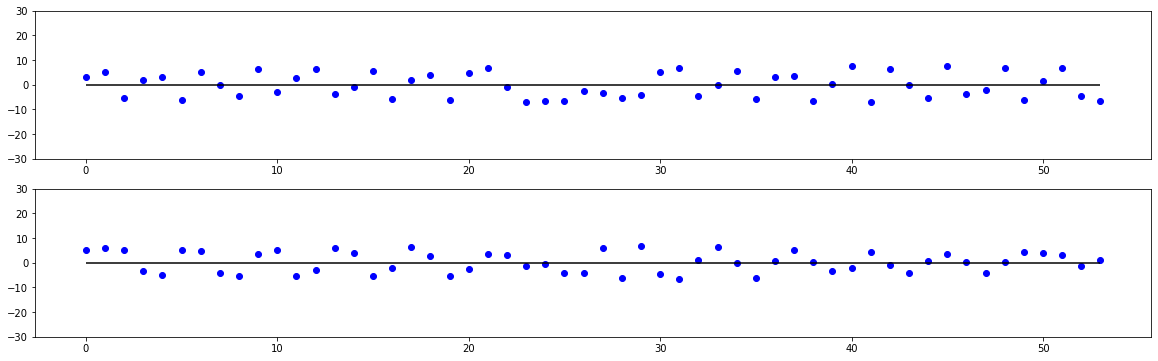

In [6]:
# Compare model twiss with correct twiss

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(model.monitor_count), 100*(bx_m - model.bx[model.monitor_index].cpu().numpy())/model.bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-30, +30)

ax2 = plt.subplot(212)
ax2.scatter(range(model.monitor_count), 100*(by_m - model.by[model.monitor_index].cpu().numpy())/model.by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-30, +30)

plt.show()

In [7]:
# Compute reference parameters (frequency, amplitude and phase)

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, trajectory[model.monitor_index, :, 0])
y = Data.from_data(w, trajectory[model.monitor_index, :, 2])

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [8]:
# Set near noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.540576047, sigma_nux=6.20969156e-07, error_nux=6.69116003e-08

(ax - ref_ax).abs().sum().item()=9.8023605e-05

(fx - ref_fx).abs().sum().item()=0.0415784134



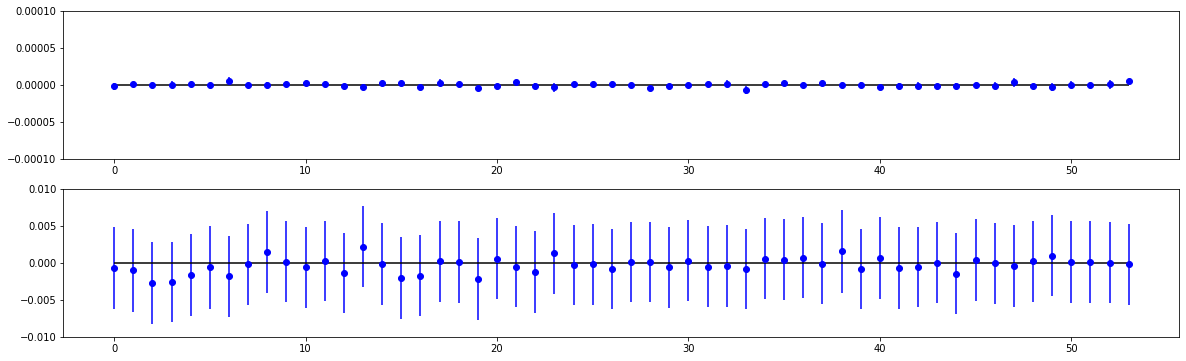

In [9]:
# Compute frequency, amplitude and phase for x plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-1.0E-4, +1.0E-4)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

# Coupling
axy, sigma_axy, _ = d.harmonic_amplitude(ref_nuy, length=256, order=1.0, error=True, sigma_frequency=None, shift=True, count=64, step=8, method='noise')

nuy= 0.574371869, sigma_nuy=8.85165397e-07, error_nuy=1.09712564e-07

(ay - ref_ay).abs().sum().item()=9.1157599e-05

(fy - ref_fy).abs().sum().item()=0.0495227429



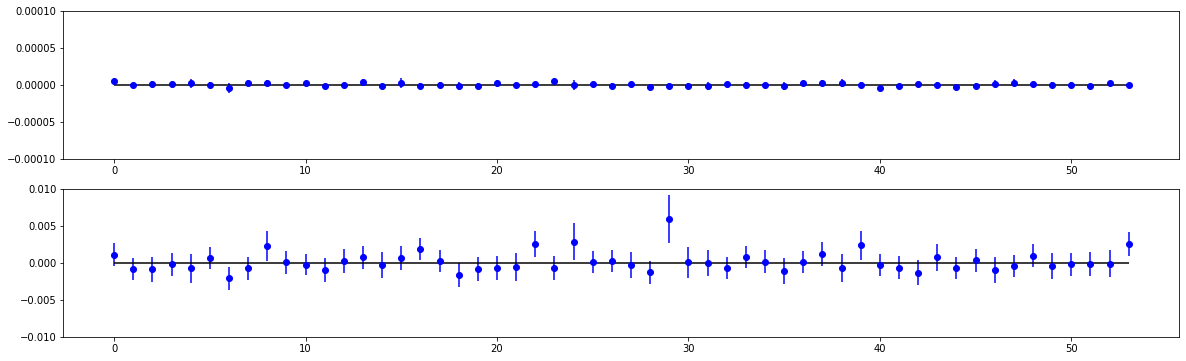

In [10]:
# Compute frequency, amplitude and phase for y plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-1.0E-4, +1.0E-4)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

# Coupling
ayx, sigma_ayx, _ = d.harmonic_amplitude(ref_nux, length=256, order=1.0, error=True, sigma_frequency=None, shift=True, count=64, step=8, method='noise')

In [11]:
# Set table

table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

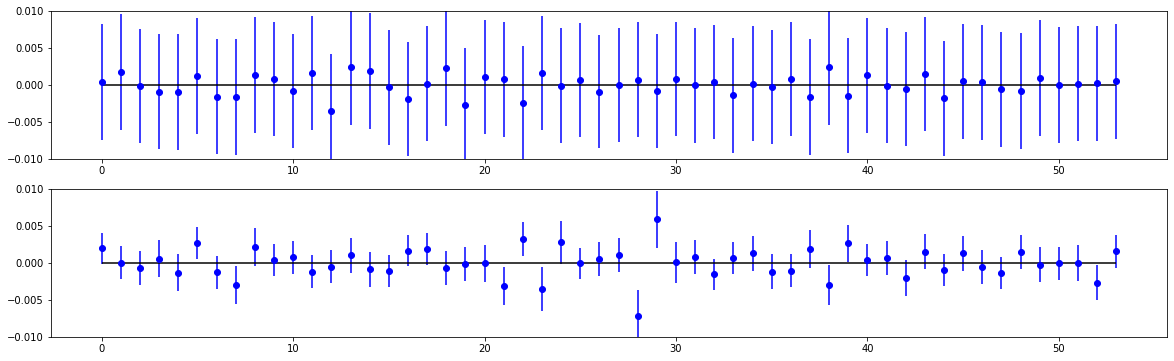

In [12]:
# Compare phase advance between adjacent monitor locations with correct data

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (fx_m - table.phase_x.cpu().numpy()), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy_m - table.phase_y.cpu().numpy()), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [13]:
# Compute twiss from phase data using different range limit (upto 32)

box = []

for limit in range(1, 32 + 1):

    twiss = Twiss(model, table, limit=limit)

    twiss.phase_virtual()
    twiss.get_twiss_from_phase()
    mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
    mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})

    if twiss.limit != (1, 1):

        twiss.process_twiss(plane='x', mask=mask_x, weight=True)
        twiss.process_twiss(plane='y', mask=mask_y, weight=True)

    else:

        twiss.ax = twiss.data_phase['ax'].flatten()
        twiss.bx = twiss.data_phase['bx'].flatten()
        twiss.ay = twiss.data_phase['ay'].flatten()
        twiss.by = twiss.data_phase['by'].flatten()

        twiss.sigma_ax = twiss.data_phase['sigma_ax'].flatten()
        twiss.sigma_bx = twiss.data_phase['sigma_bx'].flatten()
        twiss.sigma_ay = twiss.data_phase['sigma_ay'].flatten()
        twiss.sigma_by = twiss.data_phase['sigma_by'].flatten()

    bx = twiss.bx[model.monitor_index].cpu().numpy()
    ax = twiss.ax[model.monitor_index].cpu().numpy()
    by = twiss.by[model.monitor_index].cpu().numpy()
    ay = twiss.ay[model.monitor_index].cpu().numpy()

    sigma_bx = twiss.sigma_bx[model.monitor_index].cpu().numpy()
    sigma_ax = twiss.sigma_ax[model.monitor_index].cpu().numpy()
    sigma_by = twiss.sigma_by[model.monitor_index].cpu().numpy()
    sigma_ay = twiss.sigma_ay[model.monitor_index].cpu().numpy()

    box.append(numpy.array([[bx, sigma_bx], [ax, sigma_ax], [by, sigma_by], [ay, sigma_ay]]))
    
    if limit <= 8:
        print(f'limit= {limit}: {"model":>12} {"error":>12}')
        print(f'error_bx: {numpy.abs(model.bx[model.monitor_index].cpu() - bx).sum().item():12.9} {numpy.abs(bx_m - bx).sum().item():12.9}')
        print(f'error_by: {numpy.abs(model.by[model.monitor_index].cpu() - by).sum().item():12.9} {numpy.abs(by_m - by).sum().item():12.9}')
        print(f'error_ax: {numpy.abs(model.ax[model.monitor_index].cpu() - ax).sum().item():12.9} {numpy.abs(ax_m - ax).sum().item():12.9}')
        print(f'error_ay: {numpy.abs(model.ay[model.monitor_index].cpu() - ay).sum().item():12.9} {numpy.abs(ay_m - ay).sum().item():12.9}')
        print()

box = numpy.array(box).T

# As it can be seen, for larger range limit value, bias increases
# Since the effect of noise in this example can be neglected, the discrepancy is only due to the bias
# Still, using limit=1 doesn't provide optimal accuracy
# In this example limit=2 is optimal, for larger values bias is stronger

limit= 1:        model        error
error_bx:   25.2813562   2.01429553
error_by:   32.0471165   4.55823579
error_ax:    6.1678979  0.585843678
error_ay:   6.04170693   0.81750682

limit= 2:        model        error
error_bx:   23.9685752   2.48592722
error_by:   31.5546583   2.89758222
error_ax:   6.01309439   0.63622273
error_ay:   6.03647648   0.60970322

limit= 3:        model        error
error_bx:   23.1123929   2.22757342
error_by:   31.8336967   3.13641697
error_ax:   5.48578777   0.57448865
error_ay:   6.11543915  0.599471714

limit= 4:        model        error
error_bx:   24.2931101   2.56973246
error_by:   30.9668265   3.89593546
error_ax:   6.12117645  0.839592228
error_ay:   6.11415969  0.561456166

limit= 5:        model        error
error_bx:    25.469067   3.07270778
error_by:   31.4735354   3.76816196
error_ax:   6.22113877  0.810711387
error_ay:   6.27340363  0.571718871

limit= 6:        model        error
error_bx:   26.0071985   3.00537362
error_by:   31.6915498 

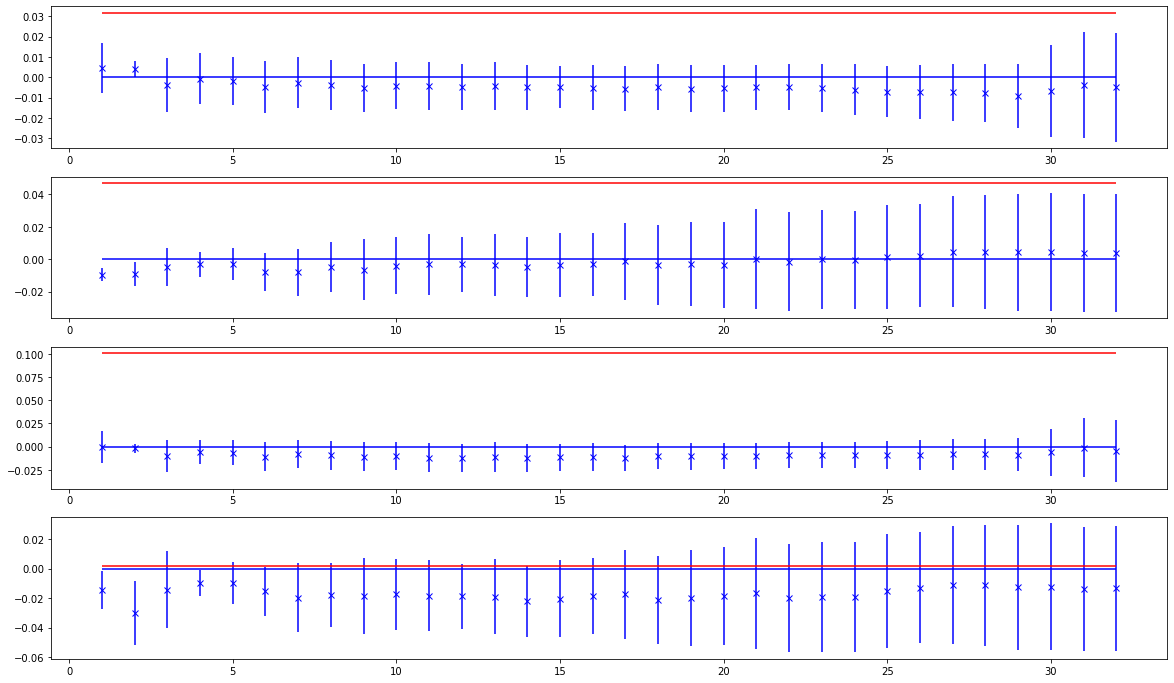

In [14]:
# Examine data for selected location

index = 0
out, sigma_out = box[index]

bx, ax, by, ay = out
sigma_bx, sigma_ax, sigma_by, sigma_ay = sigma_out

plt.figure(figsize=(20, 4*3))

ax1 = plt.subplot(411)
ax1.errorbar(range(1, 1 + len(bx)), (bx_m[index] - bx)/bx_m[index], yerr=sigma_bx/bx_m[index], fmt=' ', marker='x', color='blue')
ax1.hlines(0, 1, len(bx), colors='blue')
ax1.hlines((bx_m[index] - model.bx[model.monitor_index][index].cpu())/bx_m[index], 1, len(bx), colors='red')

ax2 = plt.subplot(412)
ax2.errorbar(range(1, 1 + len(by)), (by_m[index] - by)/by_m[index], yerr=sigma_by/by_m[index], fmt=' ', marker='x', color='blue')
ax2.hlines(0, 1, len(by), colors='blue')
ax2.hlines((by_m[index] - model.by[model.monitor_index][index].cpu())/by_m[index], 1, len(by), colors='red')

ax3 = plt.subplot(413)
ax3.errorbar(range(1, 1 + len(ax)), (ax_m[index] - ax)/ax_m[index], yerr=sigma_ax/ax_m[index], fmt=' ', marker='x', color='blue')
ax3.hlines(0, 1, len(ax), colors='blue')
ax3.hlines((ax_m[index] - model.ax[model.monitor_index][index].cpu())/ax_m[index], 1, len(bx), colors='red')

ax4 = plt.subplot(414)
ax4.errorbar(range(1, 1 + len(ay)), (ay_m[index] - ay)/ay_m[index], yerr=sigma_ay/ay_m[index], fmt=' ', marker='x', color='blue')
ax4.hlines(0, 1, len(ay), colors='blue')
ax4.hlines((ay_m[index] - model.ay[model.monitor_index][index].cpu())/ay_m[index], 1, len(bx), colors='red')

plt.show()

# Note, this bias will decrease for corrected lattice

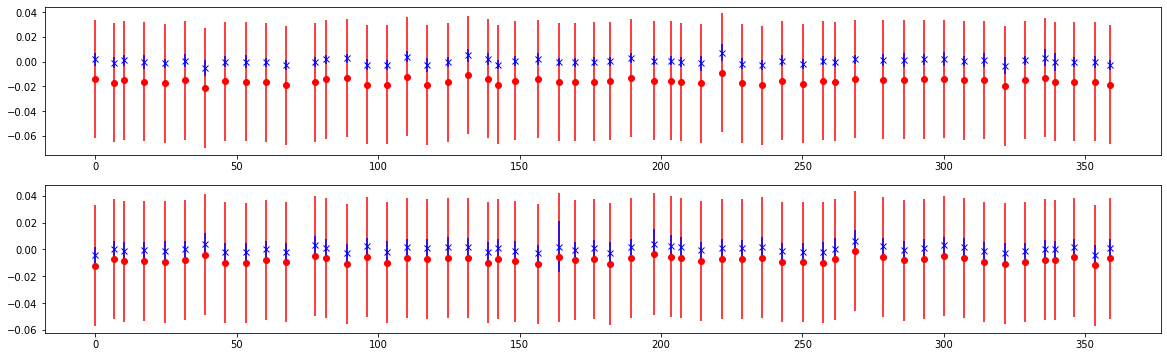

In [15]:
# Compute twiss from amplitude using twiss from phase data for action estimation

# Set twiss instance

twiss = Twiss(model, table, limit=4)


# Compute twiss from phase data
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)


# Twiss from amplitude using model for action estimation

twiss.get_action()
twiss.get_twiss_from_amplitude()
bx_1 = twiss.data_amplitude['bx'].cpu().numpy()
by_1 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_1 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_1 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Twiss from amplitude using twiss from phase for action estimation

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()
bx_2 = twiss.data_amplitude['bx'].cpu().numpy()
by_2 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_2 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_2 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Compare

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_1)/bx_m, yerr=sigma_bx_1/bx_m, fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_2)/bx_m, yerr=sigma_bx_2/bx_m, fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_1)/by_m, yerr=sigma_by_1/by_m, fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_2)/by_m, yerr=sigma_by_2/by_m, fmt=' ', marker='x', color='blue')

plt.show()

# Note, bias from action estimation (all values are shifted) is corrected

In [16]:
# Action spead (coupling)

print(twiss.action['spread_jx']/twiss.action['center_jx'])
print(twiss.action['spread_jy']/twiss.action['center_jy'])

tensor(3.450602868326e-03, dtype=torch.float64)
tensor(5.623615617450e-03, dtype=torch.float64)


tensor(4.872292150990e-03, dtype=torch.float64)
tensor(1.242149348994e-02, dtype=torch.float64)


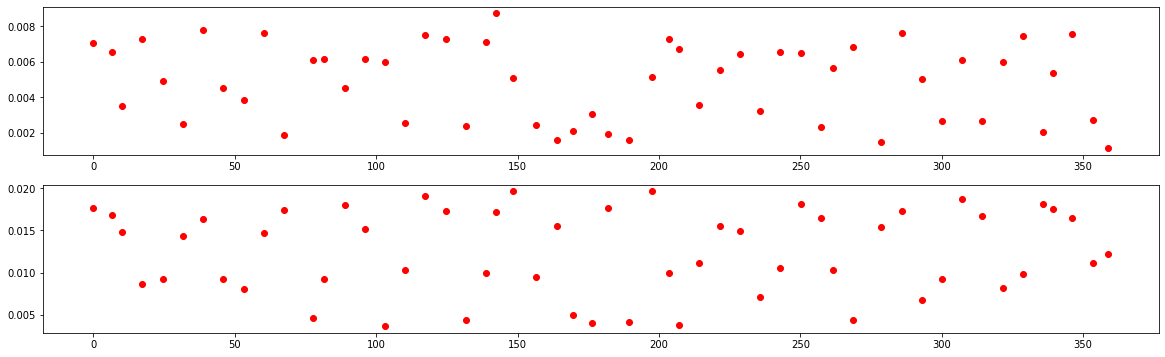

In [17]:
# Ratio (coupling)
# Can compute sigma

rx = axy/table.ax
ry = ayx/table.ay

print(rx.mean())
print(ry.mean())

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.scatter(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), rx, marker='o', color='red')
ax2 = plt.subplot(212)
ax2.scatter(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), ry, marker='o', color='red')
plt.show()

# Example-09: Momenta estimation

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# Momenta data can be used to estimate twiss parameters, but it can't be measured directly
# Given coordinates at monitor locations, momenta data can be estimated for given model or measured transport between locations

# For linear motion, monenta can be computed using transport matrix between locations
# This matrix can be obtained from model or constructed from measured twiss parameters
# For nonlinear case, generating functions can be used to estimate momenta from coordinates

# In this example linear relation between locations is assumed

# Several methods of momenta estimation are avaliable:
# 1) Estimation from a single pair (using model or measured transport matrix)
# 2) Estimation from several pairs (using model or measured transport matrix), average result over pairs
# 3) Estimation from several locations (using model or measured transport matrix), least square fit both coordinates and momenta

In [4]:
# Set model

# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

kn, ks = 0.0, 0.0
model.make_kick(kn, ks)
model.apply_error(split=True)

# Compute one-turn matrix

model.make_turn()

# Compute twiss (flag is True, if one-turn matrix is stable)

flag = model.make_twiss()
print(flag)

# Set fractional tunes

mqx, mqy = mod(model.out_tune, 1)

True


In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(length, initial, full=False)

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

In [6]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [7]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.536883099
nux= 0.536883112, sigma_nux=1.58591777e-07, error_nux=1.29862217e-08


In [8]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.576774633
nuy= 0.576774649, sigma_nuy=1.32573177e-07, error_nuy=1.56887761e-08


In [9]:
# Set table (without noise)

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], 
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=x,
    y=y,
    dtype=dtype, device=device)

In [10]:
# Set twiss

twiss = Twiss(model, table)

In [11]:
# Compute momenta at selected location

start = 16       # -- first turn
count = 128      # -- total number of turns, result is computed for (start, start + total)
probe = 10       # -- probe location
other = 11       # -- other location (can be any integer not equal to probe)
limit = 1        # -- range of locations around probe, e.g. for probe=10 and limit=11, other used locations are 9 and 11

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from a single pair

qx, px, qy, py = twiss.get_momenta(start, count, probe, other)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()


# Compute momenta from range of pairs (average)

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()


# Compute momenta from range of locations (fit)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(0., dtype=torch.float64)
tensor(4.111074409499e-18, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(3.755744088126e-18, dtype=torch.float64)

tensor(0., dtype=torch.float64)
tensor(5.958453267460e-18, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(4.230082538588e-18, dtype=torch.float64)

tensor(3.065581642703e-17, dtype=torch.float64)
tensor(8.016319812815e-18, dtype=torch.float64)
tensor(7.489126506444e-17, dtype=torch.float64)
tensor(7.187921590400e-18, dtype=torch.float64)



In [12]:
# Set table (with noise)

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], 
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

In [13]:
# Set twiss

twiss = Twiss(model, table)

In [14]:
# Compute momenta at selected location

start = 16       # -- first turn
count = 128      # -- total number of turns, result is computed for (start, start + total)
probe = 10       # -- probe location
other = 11       # -- other location (can be any integer not equal to probe)
limit = 1        # -- range of locations around probe, e.g. for probe=10 and limit=11, other used locations are 9 and 11

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from a single pair

qx, px, qy, py = twiss.get_momenta(start, count, probe, other)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()


# Compute momenta from range of pairs (average)

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()


# Compute momenta from range of locations (fit)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(5.614950796701e-04, dtype=torch.float64)
tensor(1.467436938337e-04, dtype=torch.float64)
tensor(5.704391469875e-04, dtype=torch.float64)
tensor(1.275985556735e-04, dtype=torch.float64)

tensor(5.614950796701e-04, dtype=torch.float64)
tensor(1.480682775274e-04, dtype=torch.float64)
tensor(5.704391469875e-04, dtype=torch.float64)
tensor(8.759177374449e-05, dtype=torch.float64)

tensor(5.411821963006e-04, dtype=torch.float64)
tensor(1.466342371582e-04, dtype=torch.float64)
tensor(5.042910841065e-04, dtype=torch.float64)
tensor(8.384261322896e-05, dtype=torch.float64)



In [15]:
# Set model with normal errors

# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

kn, ks = 1.0E-3, 0.0E-3
model.make_kick(kn, ks)
model.apply_error(split=True)

# Compute one-turn matrix

model.make_turn()

# Compute twiss (flag is True, if one-turn matrix is stable)

flag = model.make_twiss()
print(flag)

# Set fractional tunes

mqx, mqy = mod(model.out_tune, 1)

True


In [16]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(length, initial, full=False)

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

In [17]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [18]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.540234005
nux= 0.540234007, sigma_nux=1.15841984e-07, error_nux=1.16489363e-09


In [19]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.583042159
nuy= 0.583042154, sigma_nuy=1.59154851e-07, error_nuy=5.59878943e-09


In [20]:
# Set table (without noise)

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], 
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

In [21]:
# Set & compute twiss

twiss = Twiss(model, table)
twiss() ;

In [22]:
# Compute momenta at selected location

start = 16
count = 128
probe = 10
other = 11

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from a single pair

qx, px, qy, py = twiss.get_momenta(start, count, probe, other)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from a single pair (measured transport)

qx, px, qy, py = twiss.get_momenta(start, count, probe, other, model=False)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(6.203825611114e-04, dtype=torch.float64)
tensor(1.522405205493e-04, dtype=torch.float64)
tensor(1.084341373459e-03, dtype=torch.float64)
tensor(2.080521169599e-04, dtype=torch.float64)

tensor(6.203825611114e-04, dtype=torch.float64)
tensor(1.909781299175e-04, dtype=torch.float64)
tensor(1.084341373459e-03, dtype=torch.float64)
tensor(2.070013140085e-04, dtype=torch.float64)



In [23]:
# Compute momenta at selected location

start = 16
count = 128
probe = 10
limit = 4

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from range of pairs (average) 

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from range of pairs (average) (measured transport)

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit, model=False)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(6.203825611114e-04, dtype=torch.float64)
tensor(2.184131101830e-03, dtype=torch.float64)
tensor(1.084341373459e-03, dtype=torch.float64)
tensor(8.896397601276e-04, dtype=torch.float64)

tensor(6.203825611114e-04, dtype=torch.float64)
tensor(4.392182150030e-04, dtype=torch.float64)
tensor(1.084341373459e-03, dtype=torch.float64)
tensor(6.158827431441e-04, dtype=torch.float64)



In [24]:
# Compute momenta at selected location

start = 16
count = 128
probe = 10
limit = 4

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from range of locations (fit)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from range of locations (fit) (measured transport)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit, model=False)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(8.023787388432e-04, dtype=torch.float64)
tensor(1.384216671530e-04, dtype=torch.float64)
tensor(7.449430030682e-04, dtype=torch.float64)
tensor(8.319668753204e-05, dtype=torch.float64)

tensor(3.478838780971e-04, dtype=torch.float64)
tensor(1.158451834997e-04, dtype=torch.float64)
tensor(4.517421673127e-04, dtype=torch.float64)
tensor(9.146383832982e-05, dtype=torch.float64)



# Example-10: Twiss from invariant fit (uncoupled)

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example CS twiss parameters are estimated from (linear) invariants fit

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# Using coordinates and momenta linear invariants are fitted
# Known invariant values can be passed, else both invariant values and twiss parameters are fitted
# Fit objective is ((jx(qx, px, qy, py; beta) - ix)**2 + (jy(qx, px, qy, py; beta) - iy)**2).sqrt()
# Or ((jx(qx, px, qy, py; beta) - ix)**2 * (jy(qx, px, qy, py; beta) - iy)**2).sqrt() (default)
# Where, for uncoupled case, beta = (ax, bx, ay, by) and ix & iy are invariant values (can be fixed on input or estimated)
# Fitting is be performed using nonlinear least squares
# Note, fitting is bootstrapped (signals are randomly sampled with replacement)
# The result is returned for each sample (values and errors) at each monitor location (beta or beta and invariants)
# Processing (filtering and weighting) is then performed over samples for each monitor location
# Ones invariants are estimated, fit can be performed with fixed invariants (this can improve result quality in some cases)

# Here, random normal thin quadrupole errors are introduced and twiss parameters estimation is performed using amplitude & phase data
# These results are compared with fitted values

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with errors

# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

kn, ks = 1.0E-3, 0.0E-3
model.make_kick(kn, ks)
model.apply_error(split=True)

# Compute one-turn matrix

model.make_turn()

# Compute twiss (flag is True, if one-turn matrix is stable)

flag = model.make_twiss()
print(flag)

# Set fractional tunes

mqx, mqy = mod(model.out_tune, 1)

True


torch.Size([54, 1024, 4])

2.994829577e-07, 4.995212943e-19
2.093268871e-07, 1.140612161e-19



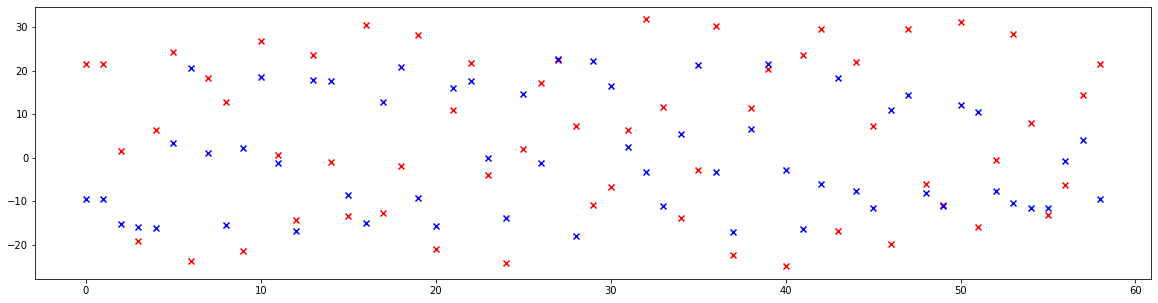

tensor(8.064859045993e+01, dtype=torch.float64)
tensor(1.089354725359e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(length, initial, full=False)
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [6]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [7]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.536493683
nux= 0.536493662, sigma_nux=1.5500709e-07, error_nux=2.12249236e-08


In [8]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqy.item():12.9}')
print(f'nux={nuy.item():12.9}, sigma_nux={sigma_nuy.item():12.9}, error_nux={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqx= 0.570409848
nux= 0.570409856, sigma_nux=1.31831631e-07, error_nux=8.66002592e-09


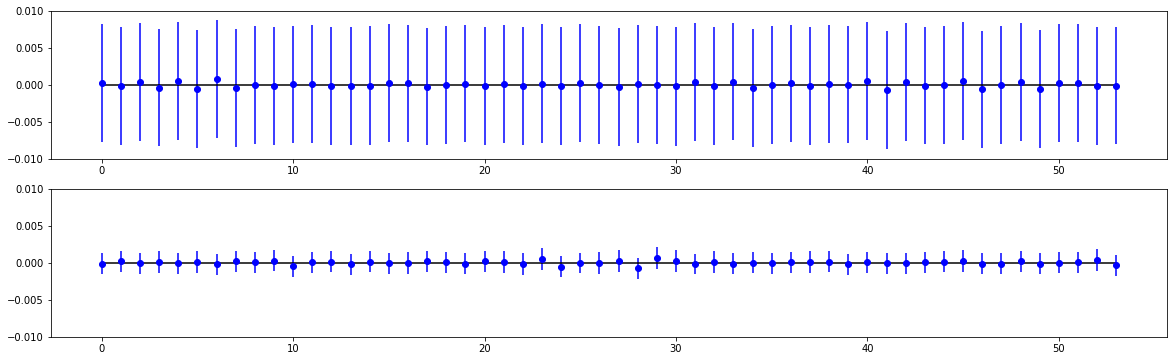

In [9]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

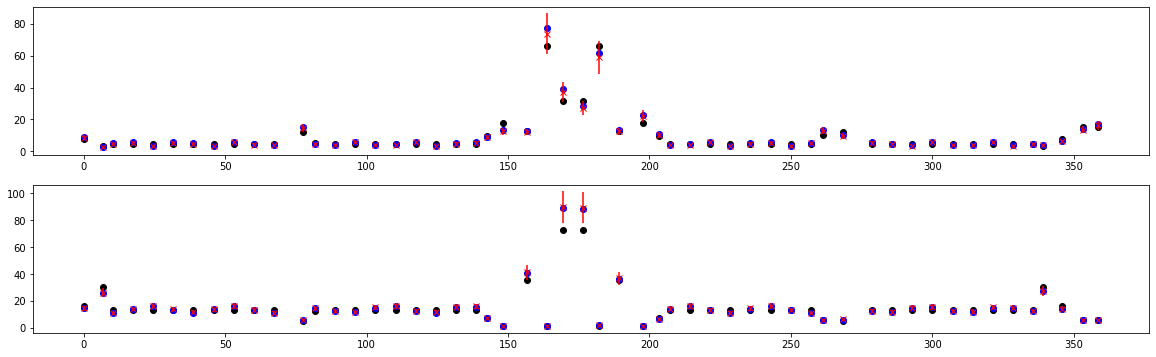

tensor(8.064859045993e+01, dtype=torch.float64)
tensor(2.410941750627e+01, dtype=torch.float64)

tensor(1.089354725359e+02, dtype=torch.float64)
tensor(8.934272019643e+00, dtype=torch.float64)



In [10]:
# Estimate twiss from amplitude

twiss = Twiss(model, table, limit=1)
twiss.get_action()
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_1 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_1 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print()

print(error_y)
print(error_y_1)
print()

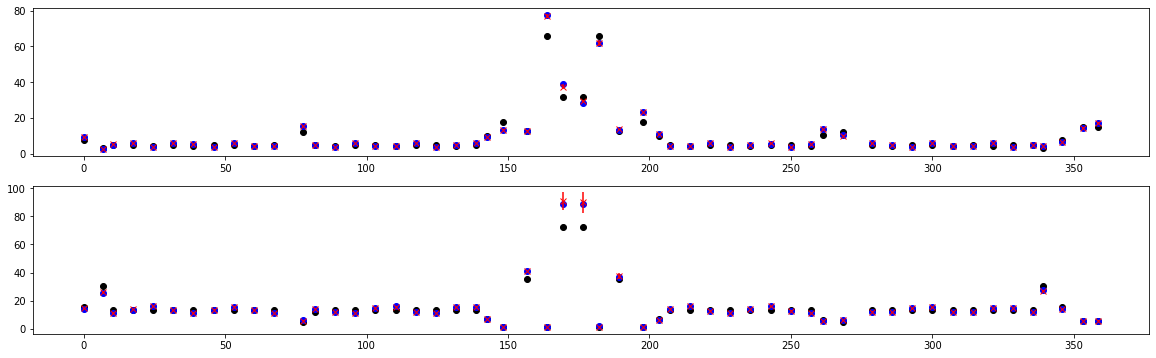

tensor(8.064859045993e+01, dtype=torch.float64)
tensor(2.410941750627e+01, dtype=torch.float64)
tensor(5.074310863024e+00, dtype=torch.float64)

tensor(1.089354725359e+02, dtype=torch.float64)
tensor(8.934272019643e+00, dtype=torch.float64)
tensor(9.756738746922e+00, dtype=torch.float64)



In [11]:
# Estimate twiss from phase

twiss = Twiss(model, table, limit=4)
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_2 = (cs_bx[model.monitor_index] - twiss.bx[model.monitor_index]).abs().sum()
error_y_2 = (cs_by[model.monitor_index] - twiss.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print()

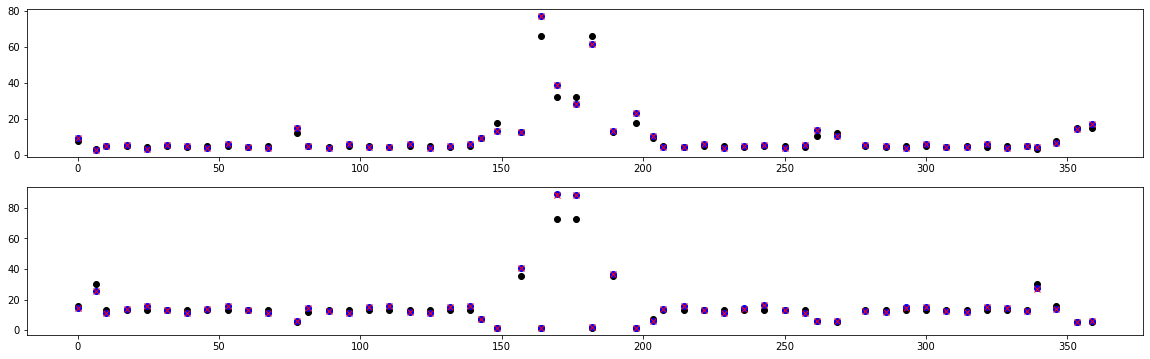

tensor(8.064859045993e+01, dtype=torch.float64)
tensor(2.410941750627e+01, dtype=torch.float64)
tensor(5.074310863024e+00, dtype=torch.float64)
tensor(1.316674387389e-01, dtype=torch.float64)

tensor(1.089354725359e+02, dtype=torch.float64)
tensor(8.934272019643e+00, dtype=torch.float64)
tensor(9.756738746922e+00, dtype=torch.float64)
tensor(1.242322413096e+00, dtype=torch.float64)



In [12]:
# Estimate twiss from amplitude (corrected action)

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_3 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_3 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print()

In [13]:
%%time

# Estimate twiss from invariant fit
# Note, **kwargs are passed to leastsq

from harmonica.parameterization import cs_normal
data = twiss.get_twiss_from_data(1,                # -- first turn
                                 256,              # -- total number of turns, orbits are computed for (start, start + total)
                                 cs_normal,        # -- normalization
                                 twiss=None,       # -- initial twiss for each location or None (use model values)
                                 method='pair',    # -- momenta computation method
                                 limit=1,          # -- range limit or direction/shift
                                 model=True,       # -- flag to use model transport
                                 product=True,     # -- flag to use product objective
                                 jacobian=False,   # -- flag to use objective jacobian
                                 count=512,        # -- number of samples
                                 fraction=0.75,    # -- sample length fraction
                                 ix=None,          # -- ix invariant value
                                 iy=None,          # -- iy invariant value  (both should present for fixed fit)
                                 n_jobs=6,         # -- number of parallel jobs (loop over samples)
                                 verbose=False)    # -- verbose flag
print(data.shape)

torch.Size([54, 2, 6, 512])
CPU times: user 4min 58s, sys: 8.08 s, total: 5min 6s
Wall time: 5min 16s


In [14]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

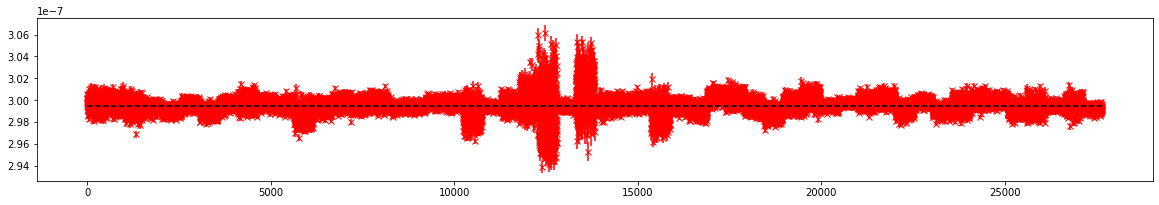

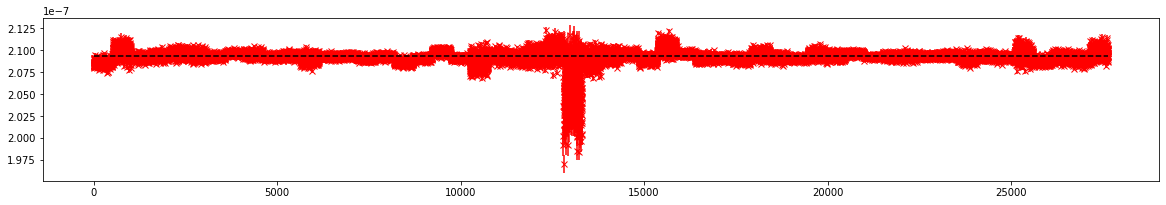

In [15]:
# Plot invariants for each sample in each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), ix.flatten().cpu().numpy(), yerr=sigma_ix.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_x, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), iy.flatten().cpu().numpy(), yerr=sigma_iy.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_y, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

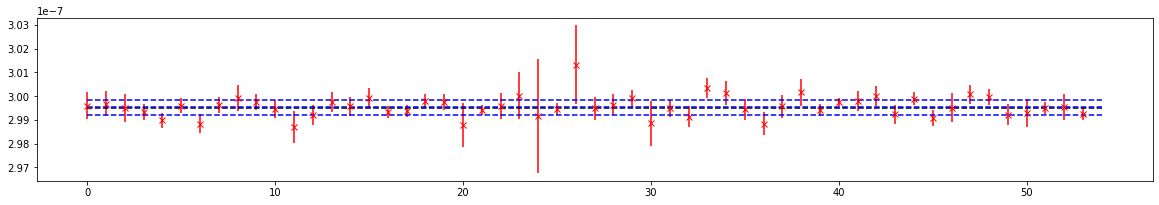

tensor(2.994829576675e-07, dtype=torch.float64)
tensor(2.995342513577e-07, dtype=torch.float64)
tensor(3.161852027273e-10, dtype=torch.float64)



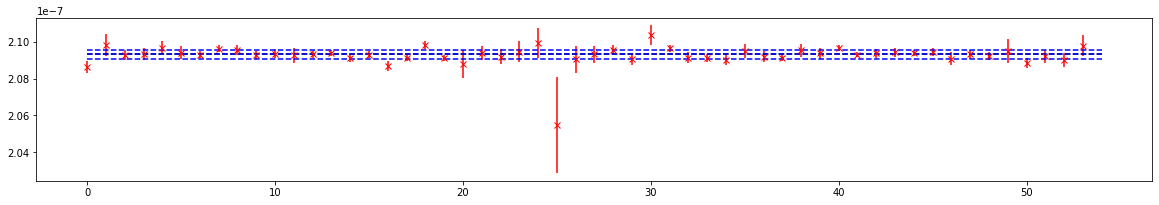

tensor(2.093268870678e-07, dtype=torch.float64)
tensor(2.093166935707e-07, dtype=torch.float64)
tensor(2.444571802027e-10, dtype=torch.float64)



In [16]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

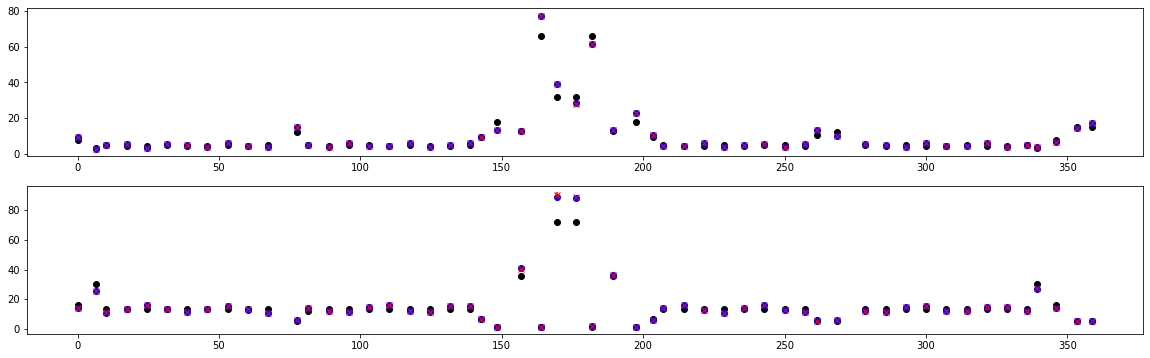

tensor(8.064859045993e+01, dtype=torch.float64)
tensor(2.410941750627e+01, dtype=torch.float64)
tensor(5.074310863024e+00, dtype=torch.float64)
tensor(1.316674387389e-01, dtype=torch.float64)
tensor(6.531978580468e-01, dtype=torch.float64)

tensor(1.089354725359e+02, dtype=torch.float64)
tensor(8.934272019643e+00, dtype=torch.float64)
tensor(9.756738746922e+00, dtype=torch.float64)
tensor(1.242322413096e+00, dtype=torch.float64)
tensor(2.770307127428e+00, dtype=torch.float64)



In [17]:
# Process twiss & compare

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value_ax = data[:, 0, 2]
error_ax = data[:, 1, 2]

value_bx = data[:, 0, 3]
error_bx = data[:, 1, 3]

value_ay = data[:, 0, 4]
error_ay = data[:, 1, 4]

value_by = data[:, 0, 5]
error_by = data[:, 1, 5]

value_ax, error_ax = twiss.process(value_ax, error_ax, mask=mask)
value_bx, error_bx = twiss.process(value_bx, error_bx, mask=mask)
value_ay, error_ay = twiss.process(value_ay, error_ay, mask=mask)
value_by, error_by = twiss.process(value_by, error_by, mask=mask)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_4 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_4 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print()

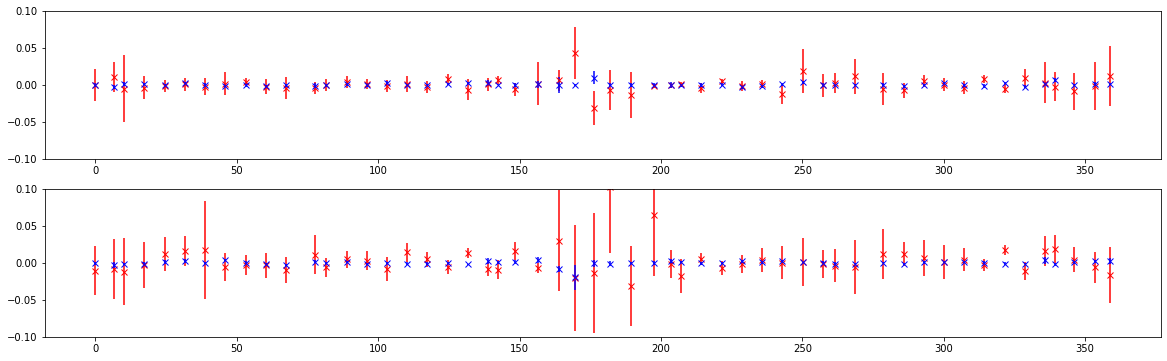

In [18]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [19]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples and fixed invariants)

from harmonica.parameterization import cs_normal
data = twiss.get_twiss_from_data(1, 256, cs_normal, twiss=None, method='pair', limit=1, model=True, product=True, jacobian=False, count=512, fraction=0.75, ix=invariant['ix_value'], iy=invariant['iy_value'], n_jobs=6, verbose=False)
print(data.shape)

torch.Size([54, 2, 4, 512])
CPU times: user 4min 44s, sys: 7.29 s, total: 4min 52s
Wall time: 4min 59s


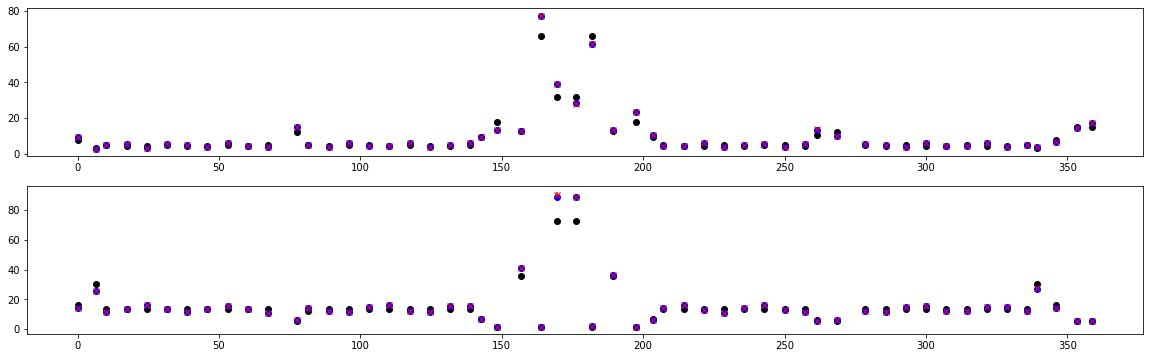

tensor(8.064859045993e+01, dtype=torch.float64)
tensor(2.410941750627e+01, dtype=torch.float64)
tensor(5.074310863024e+00, dtype=torch.float64)
tensor(1.316674387389e-01, dtype=torch.float64)
tensor(6.531978580468e-01, dtype=torch.float64)
tensor(7.420387228492e-01, dtype=torch.float64)

tensor(1.089354725359e+02, dtype=torch.float64)
tensor(8.934272019643e+00, dtype=torch.float64)
tensor(9.756738746922e+00, dtype=torch.float64)
tensor(1.242322413096e+00, dtype=torch.float64)
tensor(2.770307127428e+00, dtype=torch.float64)
tensor(2.457504094398e+00, dtype=torch.float64)



In [20]:
# Process twiss & compare

value_ax = data[:, 0, 0]
error_ax = data[:, 1, 0]

value_bx = data[:, 0, 1]
error_bx = data[:, 1, 1]

value_ay = data[:, 0, 2]
error_ay = data[:, 1, 2]

value_by = data[:, 0, 3]
error_by = data[:, 1, 3]

value_ax, error_ax = twiss.process(value_ax, error_ax)
value_bx, error_bx = twiss.process(value_bx, error_bx)
value_ay, error_ay = twiss.process(value_ay, error_ay)
value_by, error_by = twiss.process(value_by, error_by)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_5 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_5 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print()

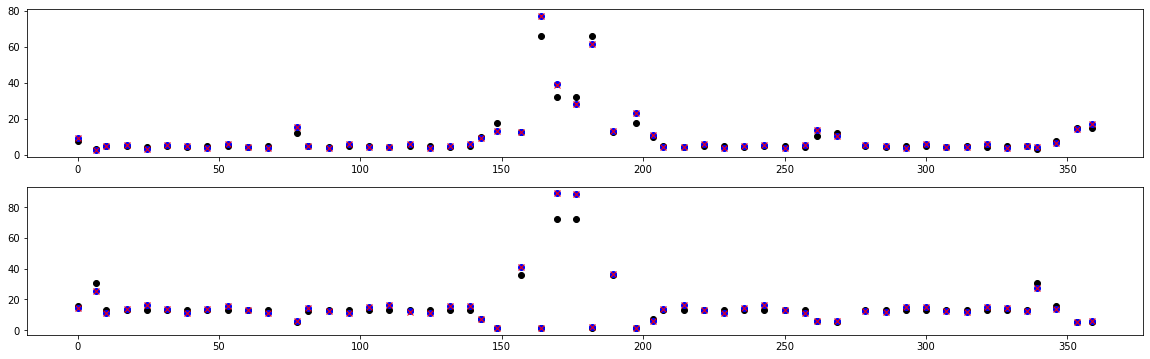

tensor(8.064859045993e+01, dtype=torch.float64)
tensor(2.410941750627e+01, dtype=torch.float64)
tensor(5.074310863024e+00, dtype=torch.float64)
tensor(1.316674387389e-01, dtype=torch.float64)
tensor(6.531978580468e-01, dtype=torch.float64)
tensor(7.420387228492e-01, dtype=torch.float64)
tensor(1.242434570606e-01, dtype=torch.float64)

tensor(1.089354725359e+02, dtype=torch.float64)
tensor(8.934272019643e+00, dtype=torch.float64)
tensor(9.756738746922e+00, dtype=torch.float64)
tensor(1.242322413096e+00, dtype=torch.float64)
tensor(2.770307127428e+00, dtype=torch.float64)
tensor(2.457504094398e+00, dtype=torch.float64)
tensor(2.287099115334e-01, dtype=torch.float64)



In [21]:
# Estimate twiss from amplitude (fixed action)

twiss.get_action(jx=invariant['ix_center'], jy=invariant['iy_center'], sigma_jx=invariant['ix_spread'], sigma_jy=invariant['iy_spread'])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_6 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_6 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print(error_x_6)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print(error_y_6)
print()

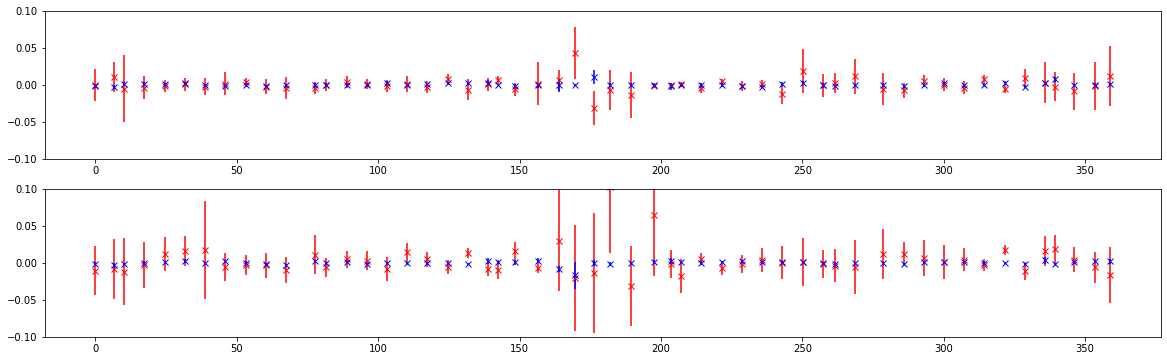

In [22]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [23]:
# Compare alpha from phase vs fitted

print((cs_ax[model.monitor_index] - twiss.ax[model.monitor_index]).abs().sum())
print((cs_ax[model.monitor_index] - value_ax).abs().sum())
print()

print((cs_ay[model.monitor_index] - twiss.ay[model.monitor_index]).abs().sum())
print((cs_ay[model.monitor_index] - value_ay).abs().sum())
print()

tensor(1.878096284330e+00, dtype=torch.float64)
tensor(5.086490230797e-01, dtype=torch.float64)

tensor(2.014986262193e+00, dtype=torch.float64)
tensor(9.393176906238e-01, dtype=torch.float64)



# Example-11: Twiss from invariant fit (coupled)

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example coupled twiss parameters are estimated from (linear) invariant fit

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# Using coordinates and momenta linear invariants are fitted
# Known invariant values can be passed, else both invariant values and twiss parameters are fitted
# Fit objective is ((jx(qx, px, qy, py; beta) - ix)**2 + (jy(qx, px, qy, py; beta) - iy)**2).sqrt()
# Or ((jx(qx, px, qy, py; beta) - ix)**2 * (jy(qx, px, qy, py; beta) - iy)**2).sqrt() (default)
# Where, for coupled case, beta = (n11, n33, n21, n43, n13, n31, n14, and n41) and ix & iy are invariant values (can be fixed on input or estimated)

# Fitting is performed using nonlinear least squares
# Note, fitting is bootstrapped (signals are randomly sampled with replacement)
# The result is returned for each sample (values and errors) at each monitor location (beta or beta and invariants)
# Processing (filtering and weighting) is then performed over samples for each monitor location
# Ones invariants are estimated, fit can be performed with fixed invariants (this can improve result quality in some cases)

# Here, random normal & skew thin quadrupole errors are introduced are twiss estimation is performed using amplitude & phase data
# These estimations are compared with fitted values

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with errors

# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

kn, ks = 1.0E-3, 0.5E-3
model.make_kick(kn, ks)
model.apply_error(split=True)

# Compute one-turn matrix

model.make_turn()

# Compute twiss (flag is True, if one-turn matrix is stable)

flag = model.make_twiss()
print(flag)

# Set fractional tunes

mqx, mqy = mod(model.out_tune, 1)

True


torch.Size([54, 1024, 4])

3.345826908e-07, 1.057201757e-18
2.597958378e-07, 8.049910473e-20



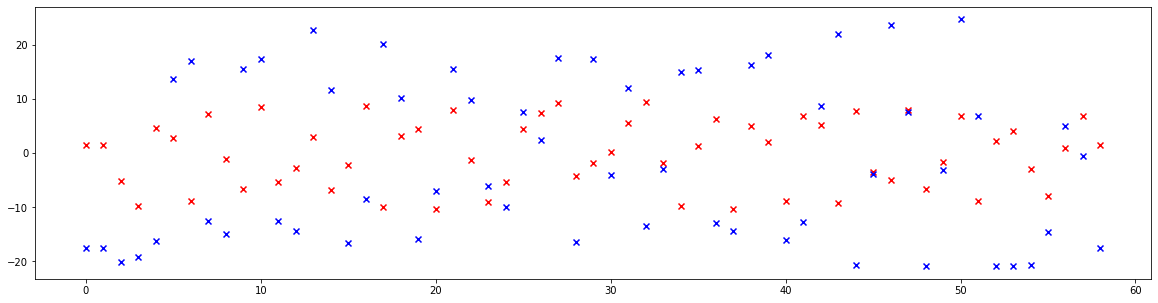

tensor(2.717158945057e+01, dtype=torch.float64)
tensor(1.205562459008e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(length, initial, full=False)
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [6]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from harmonica.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [7]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.532410965
nux= 0.532411005, sigma_nux=1.64860074e-07, error_nux=4.07505824e-08


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqy.item():12.9}')
print(f'nux={nuy.item():12.9}, sigma_nux={sigma_nuy.item():12.9}, error_nux={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqx= 0.577381961
nux= 0.577381941, sigma_nux=1.66521643e-07, error_nux=2.02420427e-08


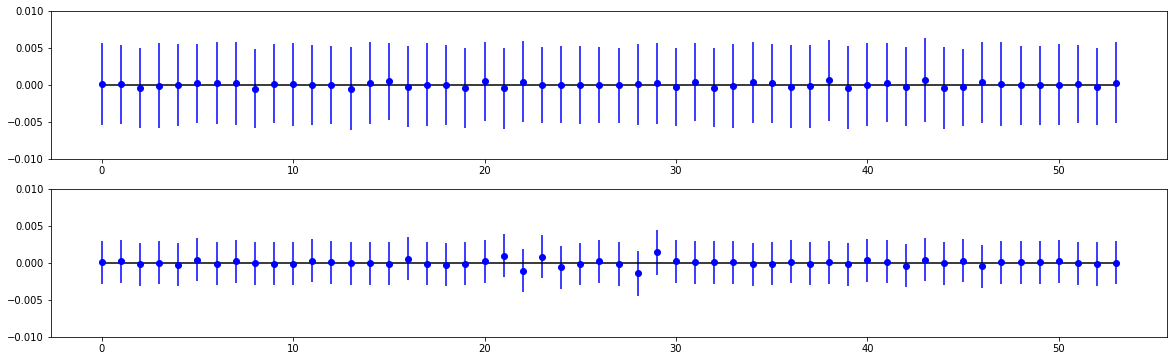

In [10]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

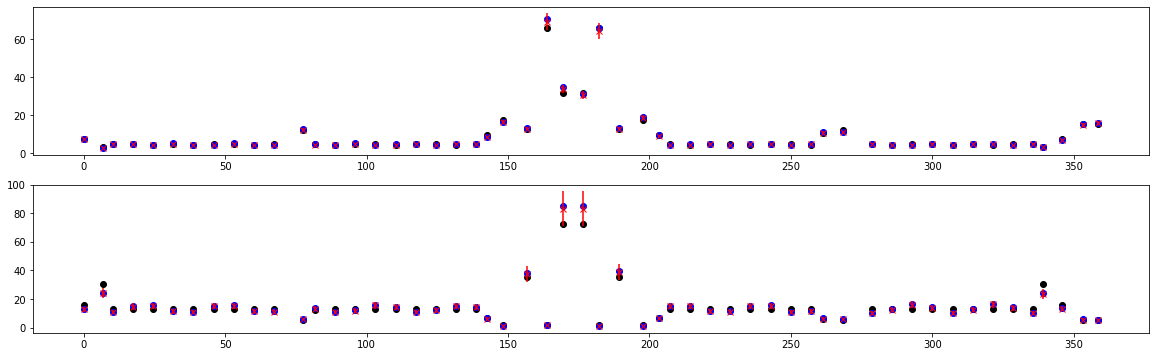

tensor(2.717158945057e+01, dtype=torch.float64)
tensor(1.207258844837e+01, dtype=torch.float64)

tensor(1.205562459008e+02, dtype=torch.float64)
tensor(1.908086640959e+01, dtype=torch.float64)



In [11]:
# Estimate twiss from amplitude

twiss = Twiss(model, table, limit=1)
twiss.get_action()
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_1 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_1 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print()

print(error_y)
print(error_y_1)
print()

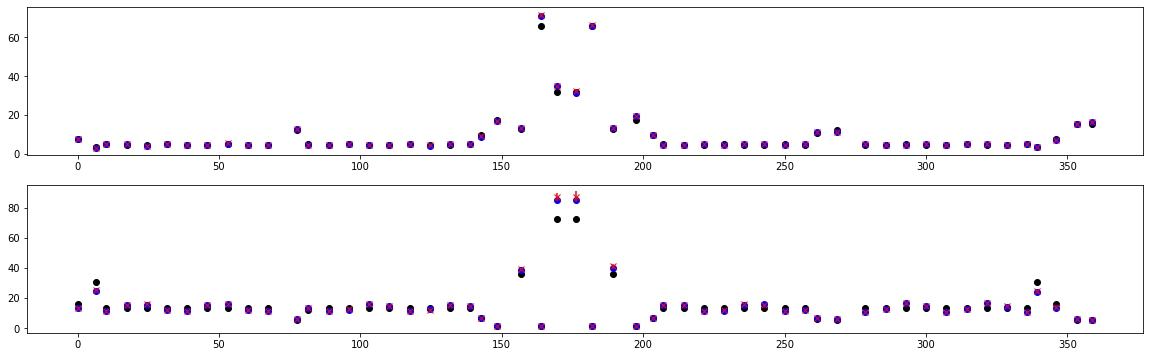

tensor(2.717158945057e+01, dtype=torch.float64)
tensor(1.207258844837e+01, dtype=torch.float64)
tensor(5.103944462191e+00, dtype=torch.float64)

tensor(1.205562459008e+02, dtype=torch.float64)
tensor(1.908086640959e+01, dtype=torch.float64)
tensor(1.321969722570e+01, dtype=torch.float64)



In [12]:
# Estimate twiss from phase

twiss = Twiss(model, table, limit=4)
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_2 = (cs_bx[model.monitor_index] - twiss.bx[model.monitor_index]).abs().sum()
error_y_2 = (cs_by[model.monitor_index] - twiss.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print()

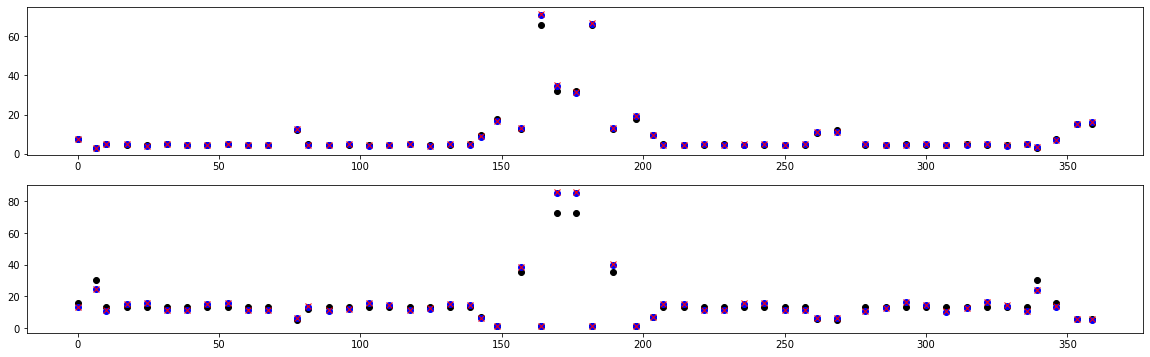

tensor(2.717158945057e+01, dtype=torch.float64)
tensor(1.207258844837e+01, dtype=torch.float64)
tensor(5.103944462191e+00, dtype=torch.float64)
tensor(4.811611704592e+00, dtype=torch.float64)

tensor(1.205562459008e+02, dtype=torch.float64)
tensor(1.908086640959e+01, dtype=torch.float64)
tensor(1.321969722570e+01, dtype=torch.float64)
tensor(7.193268184695e+00, dtype=torch.float64)



In [13]:
# Estimate twiss from amplitude (corrected action)

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_3 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_3 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print()

In [14]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,                # -- first turn
                                 256,              # -- total number of turns, orbits are computed for (start, start + total)
                                 parametric_normal,# -- normalization
                                 twiss=None,       # -- initial twiss for each location or None (use model values)
                                 method='pair',    # -- momenta computation method
                                 limit=1,          # -- range limit or direction/shift
                                 model=True,       # -- flag to use model transport
                                 product=True,     # -- flag to use product objective
                                 jacobian=False,   # -- flag to use objective jacobian
                                 count=512,        # -- number of samples
                                 fraction=0.75,    # -- sample length fraction
                                 ix=None,          # -- ix invariant value
                                 iy=None,          # -- iy invariant value  (both should present for fixed fit)
                                 n_jobs=6,         # -- number of parallel jobs (loop over samples)
                                 verbose=False)    # -- verbose flag
print(data.shape)

torch.Size([54, 2, 10, 512])
CPU times: user 6min 10s, sys: 8.13 s, total: 6min 18s
Wall time: 7min 53s


In [15]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

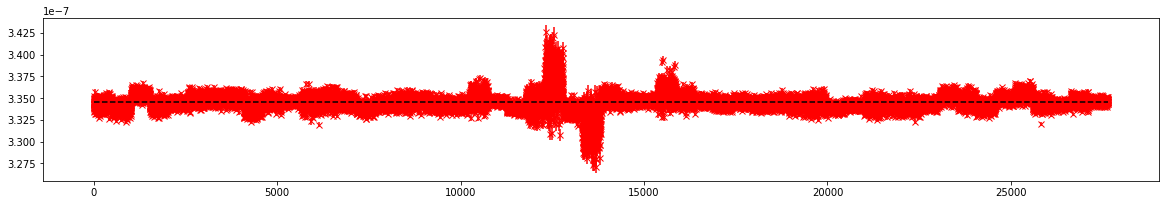

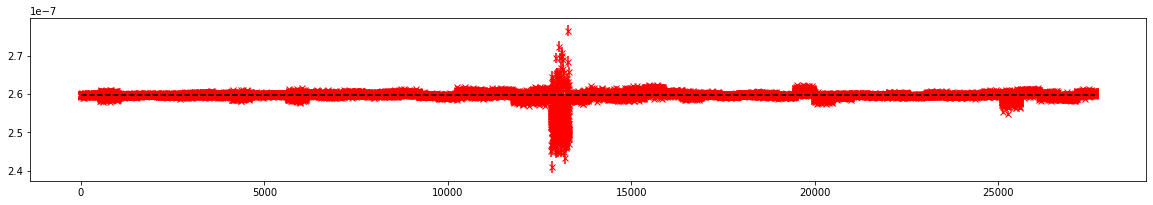

In [16]:
# Plot invariants for each sample in each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), ix.flatten().cpu().numpy(), yerr=sigma_ix.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_x, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), iy.flatten().cpu().numpy(), yerr=sigma_iy.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_y, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

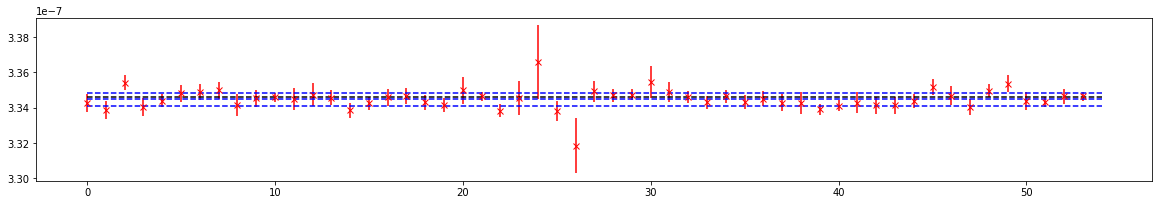

tensor(3.345826908444e-07, dtype=torch.float64)
tensor(3.344809128486e-07, dtype=torch.float64)
tensor(3.663308427873e-10, dtype=torch.float64)



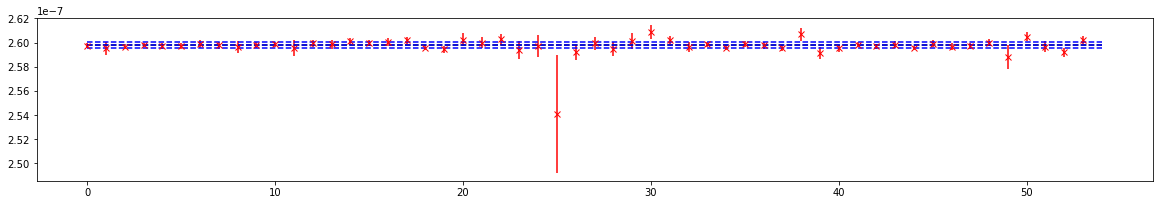

tensor(2.597958378135e-07, dtype=torch.float64)
tensor(2.597799397718e-07, dtype=torch.float64)
tensor(2.456062263423e-10, dtype=torch.float64)



In [17]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

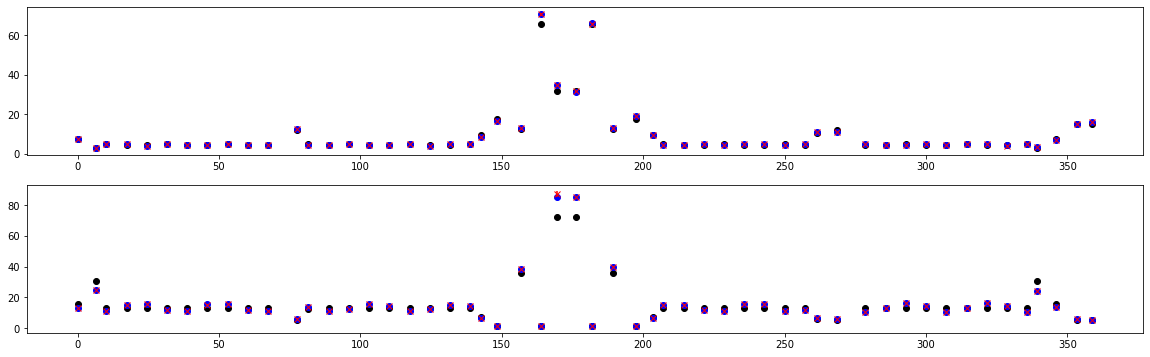

tensor(2.717158945057e+01, dtype=torch.float64)
tensor(1.207258844837e+01, dtype=torch.float64)
tensor(5.103944462191e+00, dtype=torch.float64)
tensor(4.811611704592e+00, dtype=torch.float64)
tensor(1.200104989259e+00, dtype=torch.float64)

tensor(1.205562459008e+02, dtype=torch.float64)
tensor(1.908086640959e+01, dtype=torch.float64)
tensor(1.321969722570e+01, dtype=torch.float64)
tensor(7.193268184695e+00, dtype=torch.float64)
tensor(3.067643756649e+00, dtype=torch.float64)



In [18]:
# Process twiss & compare

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value_n11 = data[:, 0, 2]
error_n11 = data[:, 1, 2]

value_n33 = data[:, 0, 3]
error_n33 = data[:, 1, 3]

value_n21 = data[:, 0, 4]
error_n21 = data[:, 1, 4]

value_n43 = data[:, 0, 5]
error_n43 = data[:, 1, 5]

value_n13 = data[:, 0, 6]
error_n13 = data[:, 1, 6]

value_n31 = data[:, 0, 7]
error_n31 = data[:, 1, 7]

value_n14 = data[:, 0, 8]
error_n14 = data[:, 1, 8]

value_n41 = data[:, 0, 9]
error_n41 = data[:, 1, 9]

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

cs_value, cs_error = [], []

for value_loc, error_loc in zip(value, error):
    table = value_loc.reshape(-1, 1) + error_loc.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_4 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_4 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print()

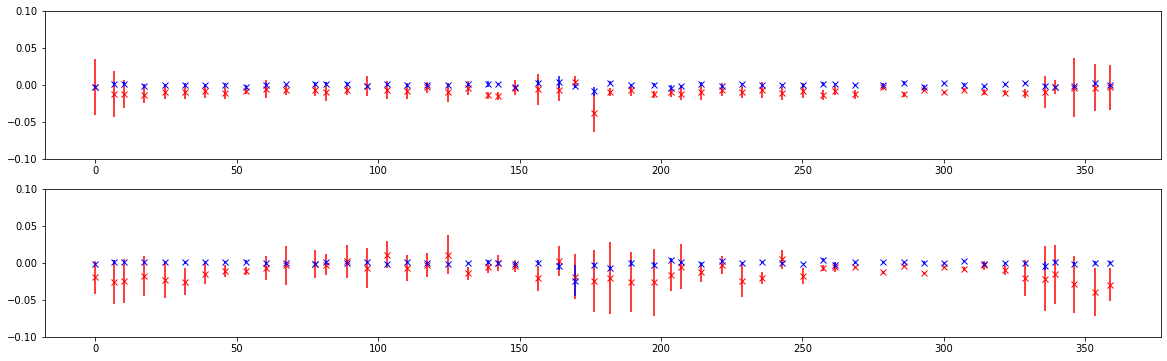

In [19]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [20]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples and fixed invariants)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1, 256, parametric_normal, twiss=None, method='pair', limit=1, model=True, product=True, jacobian=False, count=512, fraction=0.75, ix=invariant['ix_value'], iy=invariant['iy_value'], n_jobs=6, verbose=False)
print(data.shape)

torch.Size([54, 2, 8, 512])
CPU times: user 5min 35s, sys: 7.58 s, total: 5min 43s
Wall time: 6min 26s


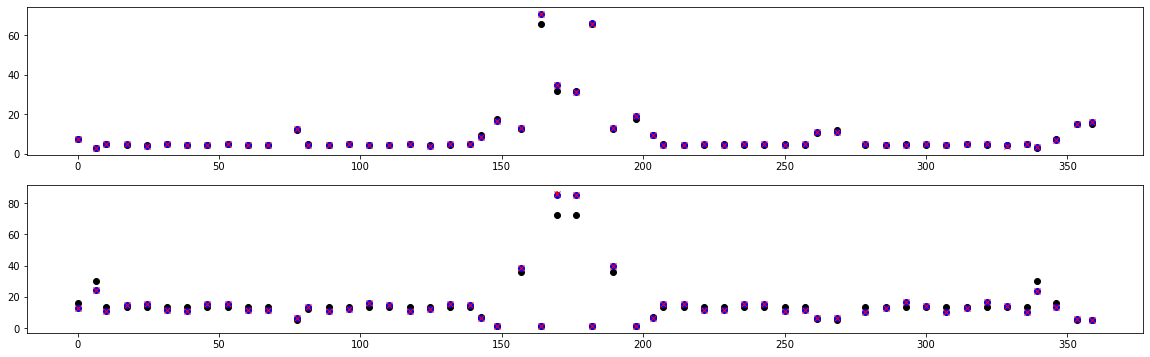

tensor(2.717158945057e+01, dtype=torch.float64)
tensor(1.207258844837e+01, dtype=torch.float64)
tensor(5.103944462191e+00, dtype=torch.float64)
tensor(4.811611704592e+00, dtype=torch.float64)
tensor(1.200104989259e+00, dtype=torch.float64)
tensor(9.878721054526e-01, dtype=torch.float64)

tensor(1.205562459008e+02, dtype=torch.float64)
tensor(1.908086640959e+01, dtype=torch.float64)
tensor(1.321969722570e+01, dtype=torch.float64)
tensor(7.193268184695e+00, dtype=torch.float64)
tensor(3.067643756649e+00, dtype=torch.float64)
tensor(1.772580776772e+00, dtype=torch.float64)



In [21]:
# Process twiss & compare

value_n11 = data[:, 0, 0]
error_n11 = data[:, 1, 0]

value_n33 = data[:, 0, 1]
error_n33 = data[:, 1, 1]

value_n21 = data[:, 0, 2]
error_n21 = data[:, 1, 2]

value_n43 = data[:, 0, 3]
error_n43 = data[:, 1, 3]

value_n13 = data[:, 0, 4]
error_n13 = data[:, 1, 4]

value_n31 = data[:, 0, 5]
error_n31 = data[:, 1, 5]

value_n14 = data[:, 0, 6]
error_n14 = data[:, 1, 6]

value_n41 = data[:, 0, 7]
error_n41 = data[:, 1, 7]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

cs_value, cs_error = [], []

for value_loc, error_loc in zip(value, error):
    table = value_loc.reshape(-1, 1) + error_loc.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_5 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_5 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print()

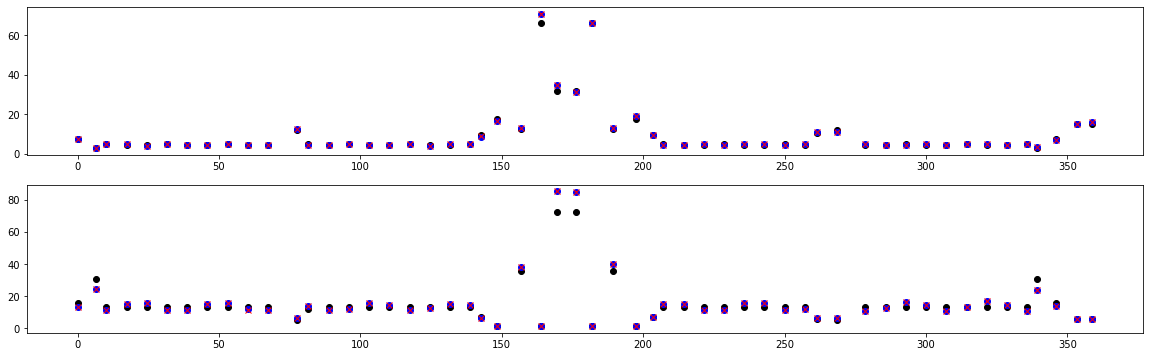

tensor(2.717158945057e+01, dtype=torch.float64)
tensor(1.207258844837e+01, dtype=torch.float64)
tensor(5.103944462191e+00, dtype=torch.float64)
tensor(4.811611704592e+00, dtype=torch.float64)
tensor(1.200104989259e+00, dtype=torch.float64)
tensor(9.878721054526e-01, dtype=torch.float64)
tensor(1.823933603782e-01, dtype=torch.float64)

tensor(1.205562459008e+02, dtype=torch.float64)
tensor(1.908086640959e+01, dtype=torch.float64)
tensor(1.321969722570e+01, dtype=torch.float64)
tensor(7.193268184695e+00, dtype=torch.float64)
tensor(3.067643756649e+00, dtype=torch.float64)
tensor(1.772580776772e+00, dtype=torch.float64)
tensor(1.888950543053e-01, dtype=torch.float64)



In [22]:
# Estimate twiss from amplitude (fixed action)

twiss.get_action(jx=invariant['ix_center'], jy=invariant['iy_center'], sigma_jx=invariant['ix_spread'], sigma_jy=invariant['iy_spread'])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_6 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_6 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print(error_x_6)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print(error_y_6)
print()

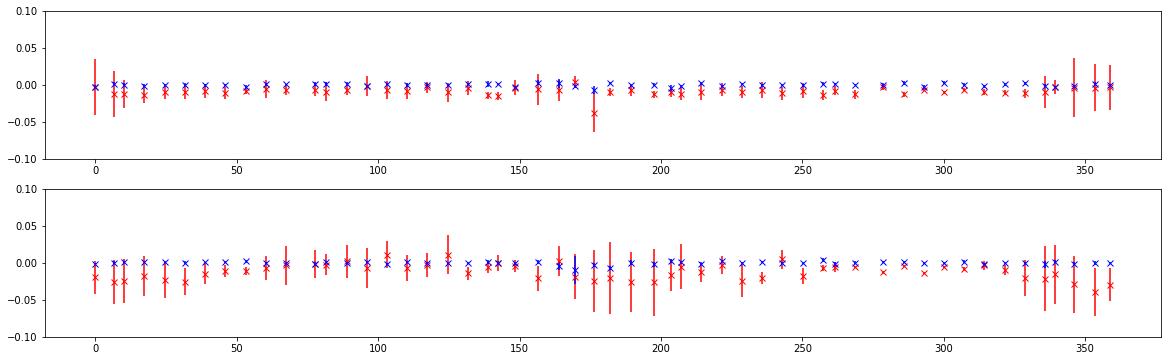

In [23]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [24]:
# Compare alpha from phase vs fitted

print((cs_ax[model.monitor_index] - twiss.ax[model.monitor_index]).abs().sum())
print((cs_ax[model.monitor_index] - value_ax).abs().sum())
print()

print((cs_ay[model.monitor_index] - twiss.ay[model.monitor_index]).abs().sum())
print((cs_ay[model.monitor_index] - value_ay).abs().sum())
print()

tensor(1.227799270297e+00, dtype=torch.float64)
tensor(4.072956511151e-01, dtype=torch.float64)

tensor(2.512989638977e+00, dtype=torch.float64)
tensor(7.897842946226e-01, dtype=torch.float64)



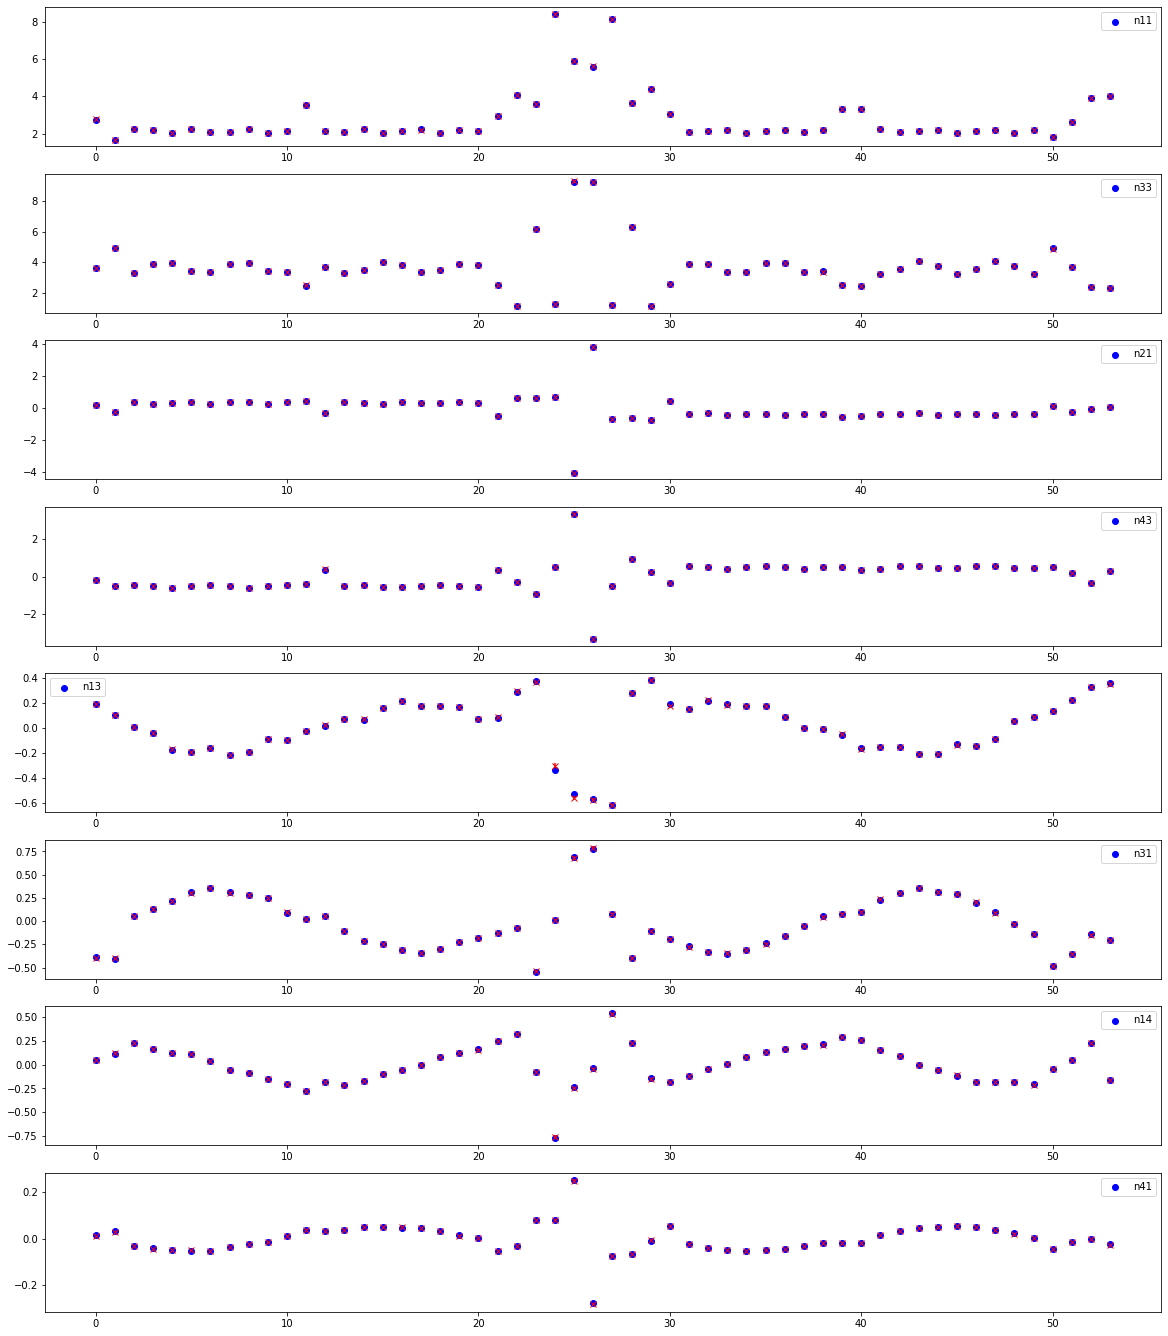

In [25]:
# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

# Example-12: Twiss from ratio minimization

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example coupled twiss parameters are estimated ratio minimization

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# Normalization matrix transforms phase space coordinates into Floquet frame (qx, px, qy, py) -> (QX, PX, QY, PY)
# If normalization matrix is correct, complex coordinates (WX = QX + i PX, WY = QY + i PY) are expected to have only one peak in FFT spectrum
# Matrix elements are fitted to minimize ratio of peak amplitudes

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with errors

# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

kn, ks = 1.0E-3, 0.5E-3
model.make_kick(kn, ks)
model.apply_error(split=True)

# Compute one-turn matrix

model.make_turn()

# Compute twiss (flag is True, if one-turn matrix is stable)

flag = model.make_twiss()
print(flag)

# Set fractional tunes

mqx, mqy = mod(model.out_tune, 1)

True


torch.Size([54, 1024, 4])

3.605532801e-07, 2.063553396e-19
2.028303014e-07, 7.686384917e-20



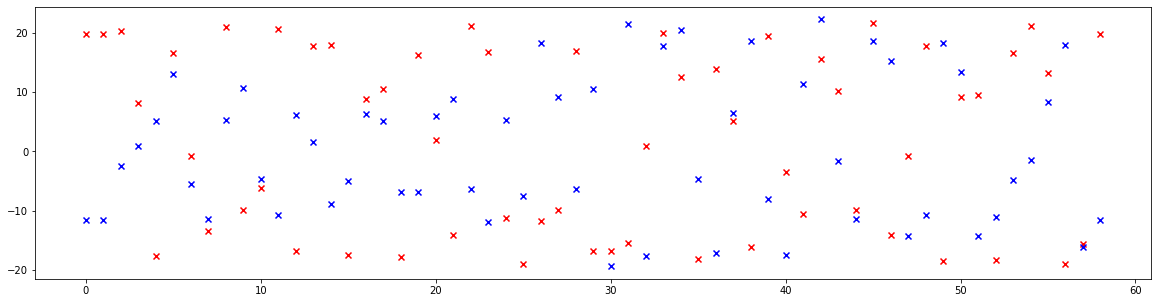

tensor(7.229094146460e+01, dtype=torch.float64)
tensor(8.437890496273e+01, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(length, initial, full=False)
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

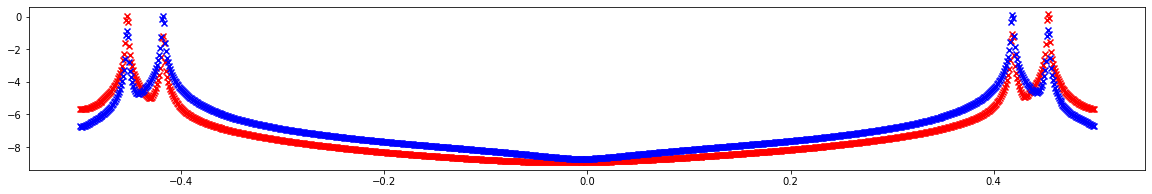

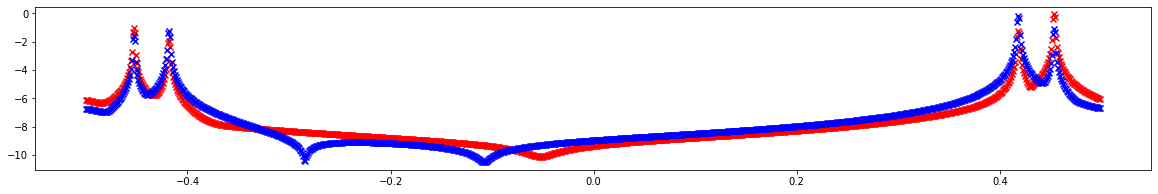

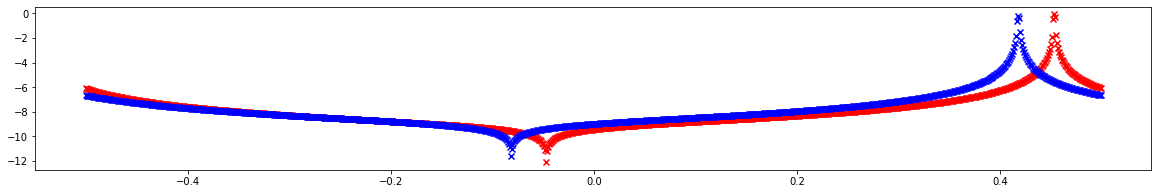

In [6]:
# For coupled case, each spectrum contains four peaks
# Main peak (nux or nuy in x or y), main mirror peak (-nux or -nuy in x or y)
# Coupling peak (nux or nuy in  in y or x), coupling mirror peak (-nux or -nuy in  in y or x)

window = Window.cosine_window(length, 1.0, dtype=dtype)

index = 0
orbit = trajectory[index].T
qx, px, qy, py = orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

# Floquet coordinates contain only one main peak (if normalization is correct)

# Model normalization

normal = model.normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

# Correct normalization

normal = model.out_normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

In [7]:
# Instead of using FFT spectrum peak amplitudes, one can compute DTFT amplitudes for given four frequencies

# Fractional tunes

nux, nuy = mod(model.out_tune, 1)

# Mirror tunes

NUX, NUY = abs(mod(model.out_tune, 1, -0.5))

# Model normalization

normal = model.normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

time = torch.linspace(0, length - 1, length, dtype=dtype, device=device)

axx = (wx*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
bxx = (wx*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()
axy = (wx*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
bxy = (wx*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()

ayy = (wy*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
byy = (wy*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()
ayx = (wy*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
byx = (wy*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()

print(torch.stack([axx, bxx, axy, bxy]).cpu().numpy())
print(torch.stack([ayy, byy, ayx, byx]).cpu().numpy())
print(((bxx + axy + bxy)/axx + (byy + ayx + byx)/ayy).numpy())
print()


# Correct normalization

normal = model.out_normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

time = torch.linspace(0, length - 1, length, dtype=dtype, device=device)

axx = (wx*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
bxx = (wx*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()
axy = (wx*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
bxy = (wx*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()

ayy = (wy*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
byy = (wy*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()
ayx = (wy*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
byx = (wy*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()

print(torch.stack([axx, bxx, axy, bxy]).cpu().numpy())
print(torch.stack([ayy, byy, ayx, byx]).cpu().numpy())
print(((bxx + axy + bxy)/axx + (byy + ayx + byx)/ayy).numpy())
print()

[0.87066812 0.08789922 0.05831073 0.01175106]
[0.65218538 0.05693729 0.08072905 0.02681136]
0.433619760822632

[8.69560252e-01 1.84697094e-07 1.97555220e-06 9.93270166e-08]
[6.52200868e-01 4.22795565e-08 1.48173385e-06 7.44987668e-08]
5.0494782830411935e-06



In [8]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from harmonica.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [9]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [10]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.546777508
nux= 0.546777494, sigma_nux=1.33486915e-07, error_nux=1.38275289e-08


In [11]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.581829288
nuy= 0.581829273, sigma_nuy=2.13988332e-07, error_nuy=1.51644011e-08


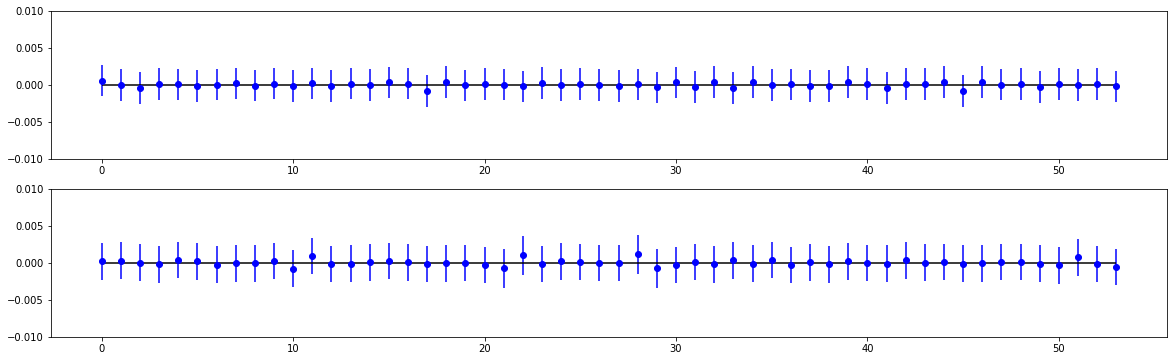

In [12]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [13]:
# Set twiss

twiss = Twiss(model, table)

In [14]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1, 256, parametric_normal, count=512, verbose=False)
print(data.shape)

torch.Size([54, 2, 10, 512])
CPU times: user 4min 37s, sys: 5.92 s, total: 4min 43s
Wall time: 7min 14s


In [15]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

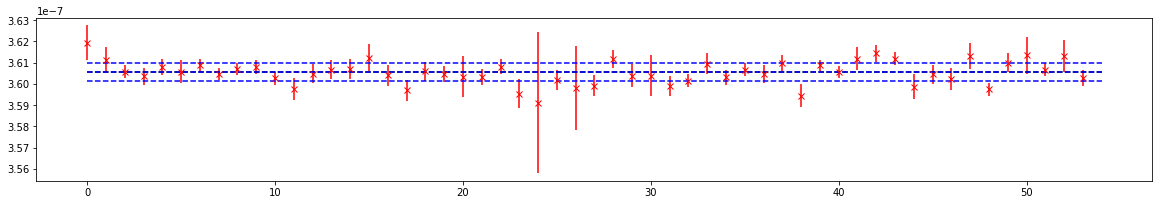

tensor(3.605532801419e-07, dtype=torch.float64)
tensor(3.605711744989e-07, dtype=torch.float64)
tensor(4.298906481119e-10, dtype=torch.float64)



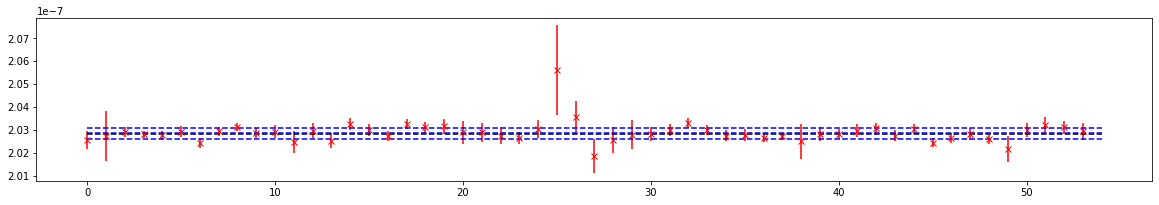

tensor(2.028303013505e-07, dtype=torch.float64)
tensor(2.028406726984e-07, dtype=torch.float64)
tensor(2.309712819892e-10, dtype=torch.float64)



In [16]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

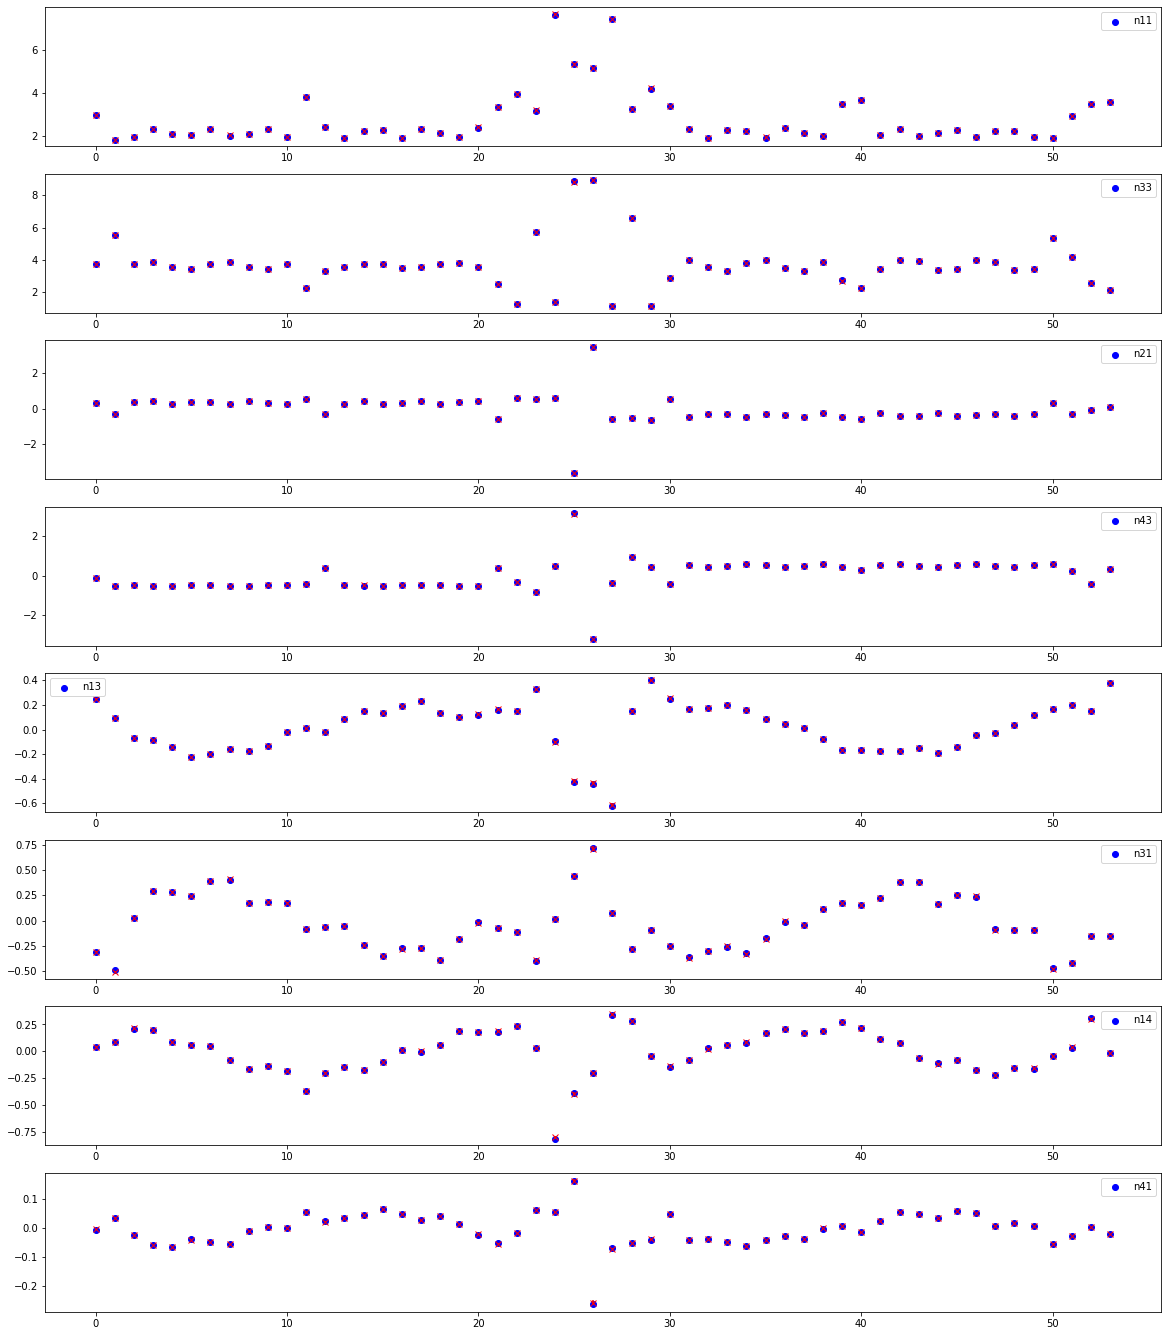

tensor(1.063827852006e-01, dtype=torch.float64)
tensor(2.212348283413e-01, dtype=torch.float64)
tensor(6.946369523083e-02, dtype=torch.float64)
tensor(1.262026003600e-01, dtype=torch.float64)
tensor(1.026751229657e-01, dtype=torch.float64)
tensor(1.244099648236e-01, dtype=torch.float64)
tensor(7.923018403051e-02, dtype=torch.float64)
tensor(3.609011522731e-02, dtype=torch.float64)


In [17]:
# Process twiss & compare

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value_n11 = data[:, 0, 2]
error_n11 = data[:, 1, 2]

value_n33 = data[:, 0, 3]
error_n33 = data[:, 1, 3]

value_n21 = data[:, 0, 4]
error_n21 = data[:, 1, 4]

value_n43 = data[:, 0, 5]
error_n43 = data[:, 1, 5]

value_n13 = data[:, 0, 6]
error_n13 = data[:, 1, 6]

value_n31 = data[:, 0, 7]
error_n31 = data[:, 1, 7]

value_n14 = data[:, 0, 8]
error_n14 = data[:, 1, 8]

value_n41 = data[:, 0, 9]
error_n41 = data[:, 1, 9]

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())

In [18]:
%%time

# Estimate twiss from ratio
# Given max signal length to use (256), samples (with length equal to window length) are generated using start shift with given step (4)
# Errors for each sample are estimated from inverse Hessian diagonal

# Note, since samples are generated using shifts, they are highly correlated

# Note, given free elements, full normalization matrix can be computed
# And invariants can be estimated from transformed orbits
# This can be used to filter data from samples

from harmonica.parameterization import parametric_normal
window = Window.cosine_window(128, 1.0, dtype=dtype, device=device)
data = twiss.get_twiss_from_ratio(1, 256, window, nux, nuy, parametric_normal, step=4, verbose=False)
print(data.shape)

torch.Size([54, 2, 8, 33])
CPU times: user 31.5 s, sys: 740 ms, total: 32.3 s
Wall time: 4min 10s


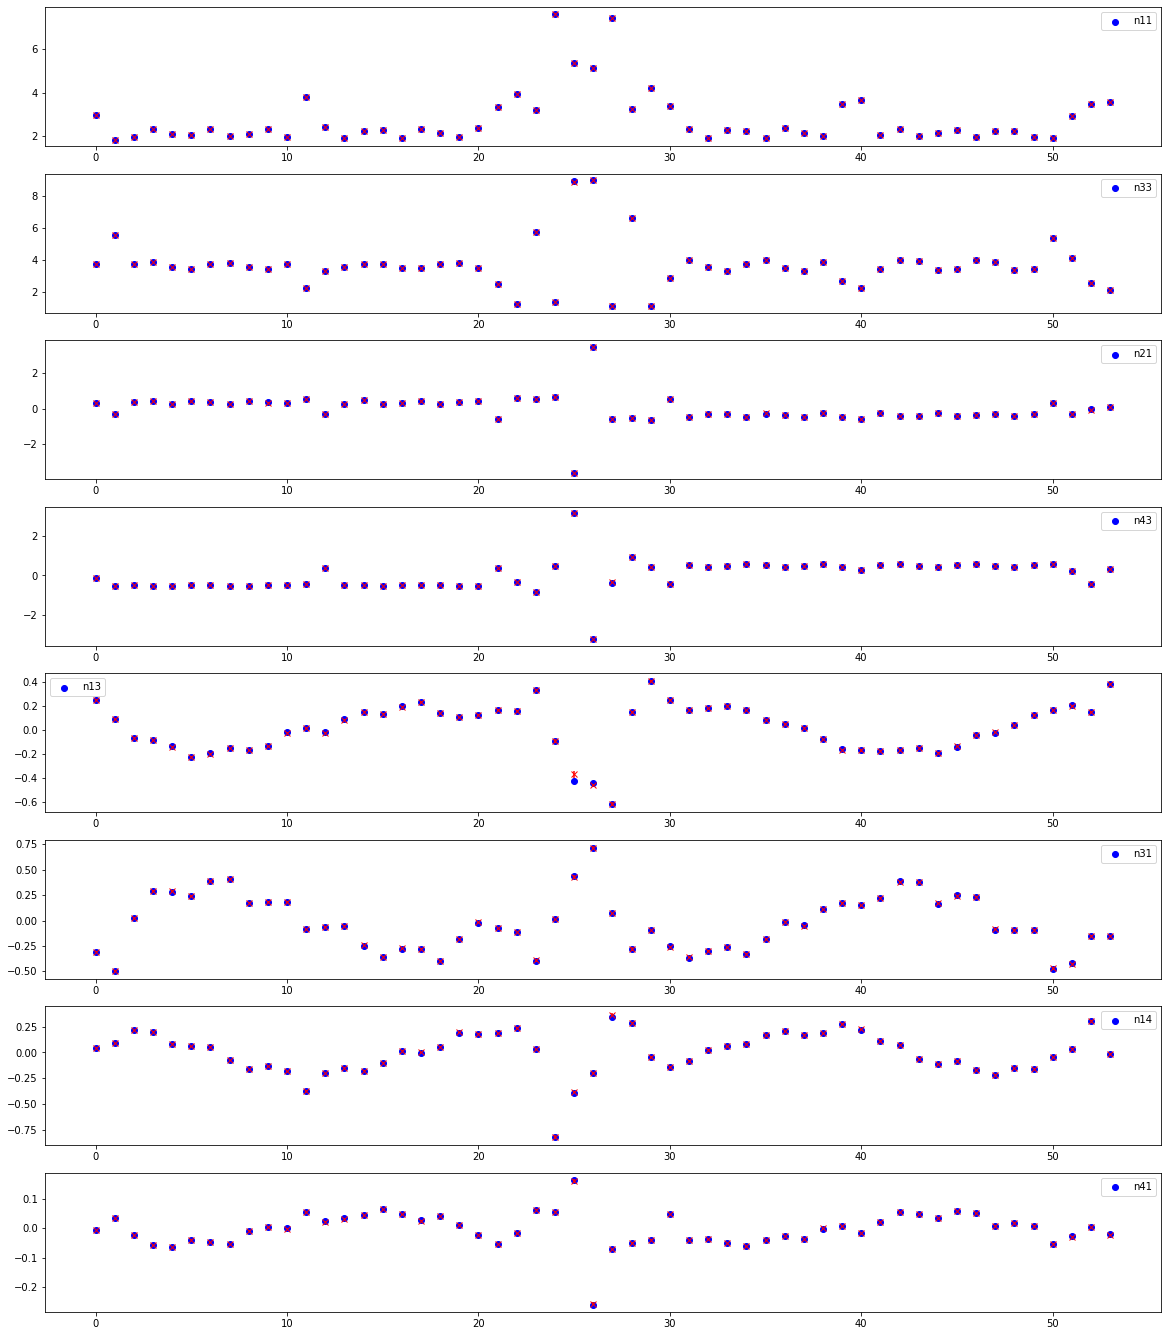

tensor(6.435991820936e-02, dtype=torch.float64)
tensor(1.133014911084e-01, dtype=torch.float64)
tensor(6.933511454747e-02, dtype=torch.float64)
tensor(9.987468728957e-02, dtype=torch.float64)
tensor(1.613882586940e-01, dtype=torch.float64)
tensor(1.252647322107e-01, dtype=torch.float64)
tensor(8.959426360337e-02, dtype=torch.float64)
tensor(3.573880206106e-02, dtype=torch.float64)


In [19]:
# Process twiss & compare

value_n11 = data[:, 0, 0]
error_n11 = data[:, 1, 0]

value_n33 = data[:, 0, 1]
error_n33 = data[:, 1, 1]

value_n21 = data[:, 0, 2]
error_n21 = data[:, 1, 2]

value_n43 = data[:, 0, 3]
error_n43 = data[:, 1, 3]

value_n13 = data[:, 0, 4]
error_n13 = data[:, 1, 4]

value_n31 = data[:, 0, 5]
error_n31 = data[:, 1, 5]

value_n14 = data[:, 0, 6]
error_n14 = data[:, 1, 6]

value_n41 = data[:, 0, 7]
error_n41 = data[:, 1, 7]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())

# Example-13: Twiss from n-turn matrix

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example coupled twiss parameters are estimated from n-turn matrix

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# n-turn matrix is fitter using phase space data
# Twiss parameters are computed from symplectified n-turn matrix

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with errors

# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

kn, ks = 1.0E-3, 0.5E-3
model.make_kick(kn, ks)
model.apply_error(split=True)

# Compute one-turn matrix

model.make_turn()

# Compute twiss (flag is True, if one-turn matrix is stable)

flag = model.make_twiss()
print(flag)

# Set fractional tunes

mqx, mqy = mod(model.out_tune, 1)

True


torch.Size([54, 1024, 4])

4.015214580e-07, 8.657719109e-19
1.903658563e-07, 5.973738257e-20



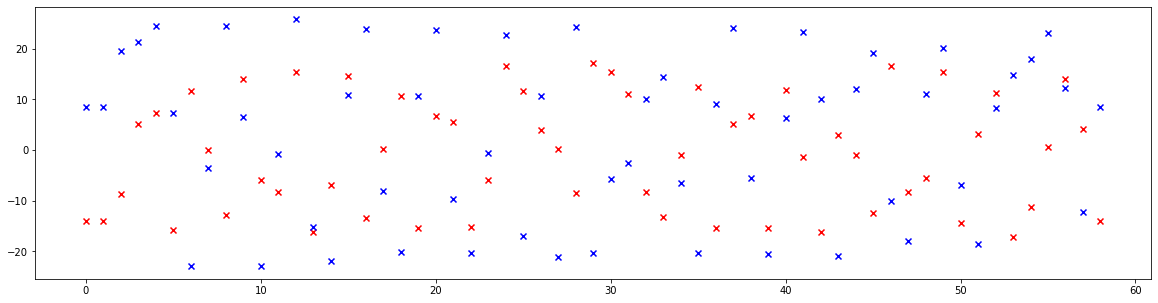

tensor(5.138946481439e+01, dtype=torch.float64)
tensor(1.284813969328e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(length, initial, full=False)
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [6]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from harmonica.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [7]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.525215108
nux=  0.52521509, sigma_nux=1.36730474e-07, error_nux=1.74986754e-08


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy=  0.57452467
nuy= 0.574524651, sigma_nuy=1.28963627e-07, error_nuy=1.96049018e-08


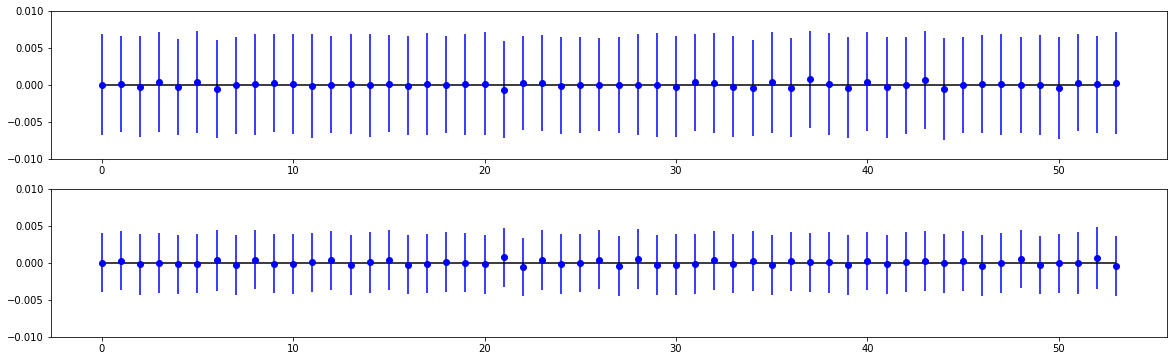

In [10]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [11]:
# Set twiss

twiss = Twiss(model, table)

In [12]:
%%time

# Estimate twiss from matrix
# Use first 512 turns from each signal to fit 1-turn matrix using 256 samples of length int(0.75*512)

# For each sample in each signal tunes and free normalization matrix elements are returned
# All zeros if matrix is unstable
# (nux, nuy, n11, n33, n21, n43, n13, n31, n14, n41)

data = twiss.get_twiss_from_matrix(1, 512, power=1, count=512, fraction=0.75)
print(data.shape)

torch.Size([54, 10, 512])
CPU times: user 3min 42s, sys: 478 ms, total: 3min 43s
Wall time: 38.8 s


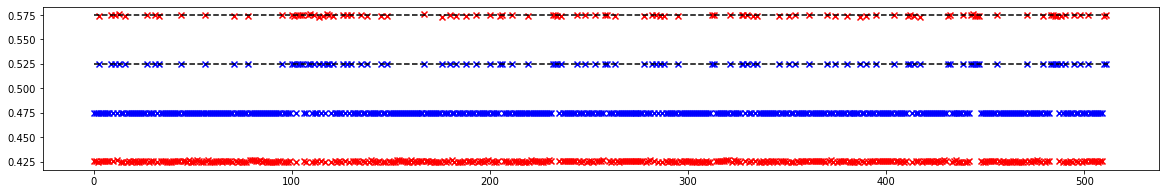

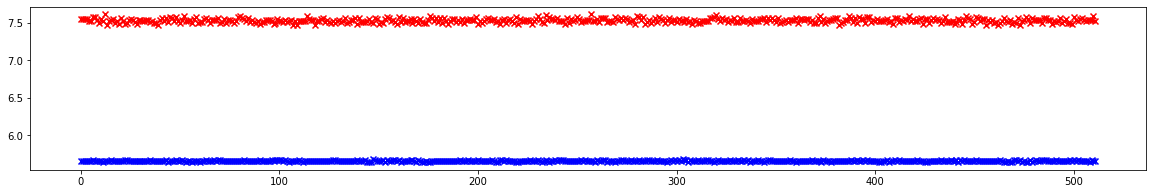

In [13]:
# In this example, fit from trajectories near IP is not accurate
# But 'good' sampes (tunewise) can be selected based on all tune data
# Note, twiss parameters are not necessarily bad for such samples

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 1].cpu().numpy(), color='red', marker='x')
plt.hlines([nux.item(), nuy.item()], 0, 512, linestyles='dashed', color='black')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 3].cpu().numpy(), color='red', marker='x')
plt.show()

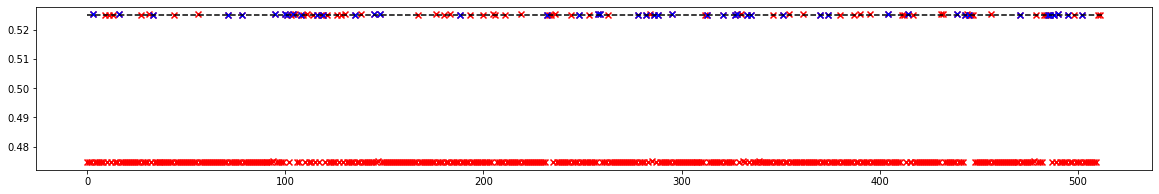

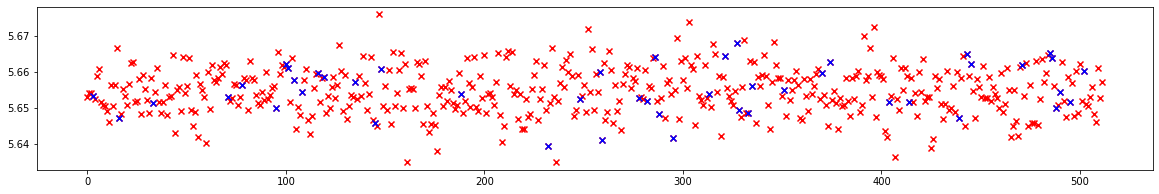

tensor(46)


In [14]:
# Generate tune mask

from harmonica.statistics import standardize
from harmonica.statistics import median, biweight_midvariance
from harmonica.anomaly import threshold

factor = torch.tensor(5.0, dtype=dtype, device=device)

tune_x = standardize(data[:, 0].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_x = threshold(tune_x, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

tune_y = standardize(data[:, 1].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_y = threshold(tune_y, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 0][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.hlines([nux.item()], 0, 512, linestyles='dashed', color='black')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 2][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.show()

print((mask_x[index]*mask_y[index]).sum())

In [15]:
# Process twiss

from harmonica.statistics import weighted_mean, weighted_variance

value_nux = weighted_mean(data[:, 0], weight=mask_x*mask_y)
value_nuy = weighted_mean(data[:, 1], weight=mask_x*mask_y)
value_n11 = weighted_mean(data[:, 2], weight=mask_x*mask_y)
value_n33 = weighted_mean(data[:, 3], weight=mask_x*mask_y)
value_n21 = weighted_mean(data[:, 4], weight=mask_x*mask_y)
value_n43 = weighted_mean(data[:, 5], weight=mask_x*mask_y)
value_n13 = weighted_mean(data[:, 6], weight=mask_x*mask_y)
value_n31 = weighted_mean(data[:, 7], weight=mask_x*mask_y)
value_n14 = weighted_mean(data[:, 8], weight=mask_x*mask_y)
value_n41 = weighted_mean(data[:, 9], weight=mask_x*mask_y)

error_nux = weighted_variance(data[:, 0], weight=mask_x*mask_y).sqrt()
error_nuy = weighted_variance(data[:, 1], weight=mask_x*mask_y).sqrt()
error_n11 = weighted_variance(data[:, 2], weight=mask_x*mask_y).sqrt()
error_n33 = weighted_variance(data[:, 3], weight=mask_x*mask_y).sqrt()
error_n21 = weighted_variance(data[:, 4], weight=mask_x*mask_y).sqrt()
error_n43 = weighted_variance(data[:, 5], weight=mask_x*mask_y).sqrt()
error_n13 = weighted_variance(data[:, 6], weight=mask_x*mask_y).sqrt()
error_n31 = weighted_variance(data[:, 7], weight=mask_x*mask_y).sqrt()
error_n14 = weighted_variance(data[:, 8], weight=mask_x*mask_y).sqrt()
error_n41 = weighted_variance(data[:, 9], weight=mask_x*mask_y).sqrt()

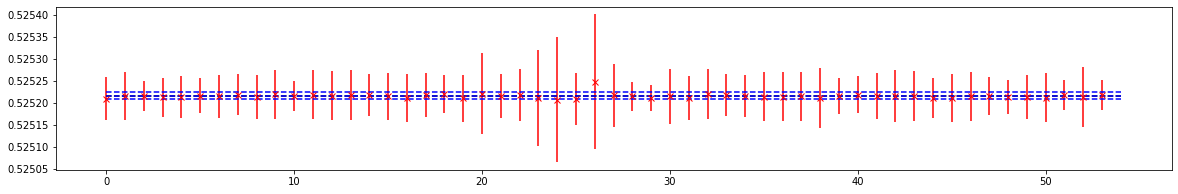

mqx= 0.525215108
nux=  0.52521509, sigma_nux=1.36730474e-07, error_nux=1.74986754e-08
nux= 0.525216227, sigma_nux=8.16977228e-06, error_nux=1.11873787e-06


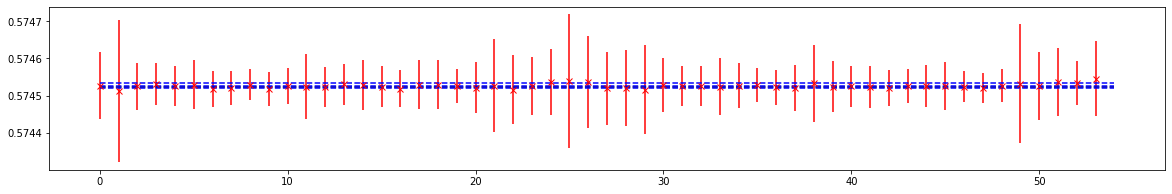

mqy=  0.57452467
nuy= 0.574524651, sigma_nuy=1.28963627e-07, error_nuy=1.96049018e-08
nuy= 0.574526749, sigma_nuy=7.3475993e-06, error_nuy=2.07860781e-06


In [16]:
# Compare tunes

value = weighted_mean(value_nux, error_nux)
error = weighted_variance(value_nux, error_nux).sqrt()

plt.figure(figsize=(20, 3))
plt.errorbar(range(model.monitor_count), value_nux, yerr=error_nux, fmt=' ', color='red', marker='x')
plt.hlines(nux.item(), 0, model.monitor_count, linestyles='dashed', color='black')
plt.hlines([(value - error).item(), value.item(), (value + error).item()], 0, model.monitor_count, linestyles='dashed', color='blue')
plt.show()

print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')
print(f'nux={value.item():12.9}, sigma_nux={error.item():12.9}, error_nux={abs(mqx - value).item():12.9}')

value = weighted_mean(value_nuy, error_nuy)
error = weighted_variance(value_nuy, error_nuy).sqrt()

plt.figure(figsize=(20, 3))
plt.errorbar(range(model.monitor_count), value_nuy, yerr=error_nuy, fmt=' ', color='red', marker='x')
plt.hlines(nuy.item(), 0, model.monitor_count, linestyles='dashed', color='black')
plt.hlines([(value - error).item(), value.item(), (value + error).item()], 0, model.monitor_count, linestyles='dashed', color='blue')
plt.show()

print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')
print(f'nuy={value.item():12.9}, sigma_nuy={error.item():12.9}, error_nuy={abs(mqy - value).item():12.9}')

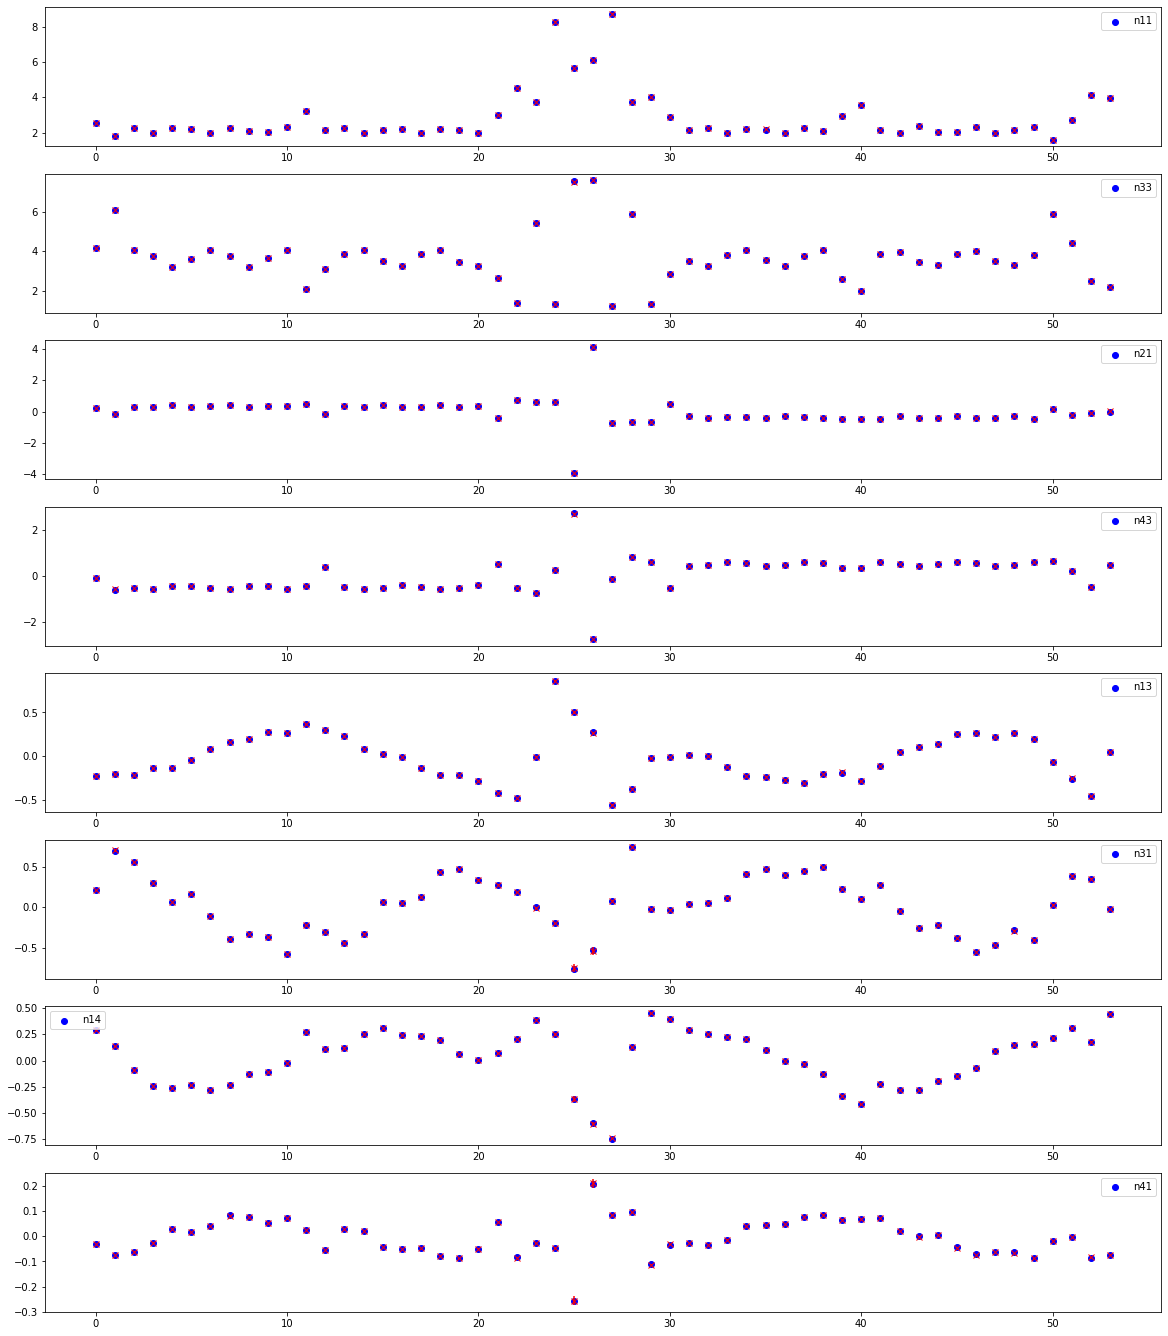

tensor(5.210531580071e-02, dtype=torch.float64)
tensor(9.824723492281e-02, dtype=torch.float64)
tensor(6.868645779801e-02, dtype=torch.float64)
tensor(9.323777465595e-02, dtype=torch.float64)
tensor(4.748002821620e-02, dtype=torch.float64)
tensor(6.904129808785e-02, dtype=torch.float64)
tensor(3.754030480739e-02, dtype=torch.float64)
tensor(3.268996652344e-02, dtype=torch.float64)


In [17]:
# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())

In [18]:
%%time

# Estimate twiss from matrix
# Use first 512 turns from each signal to fit 2-turn matrix using 256 samples of length int(0.75*512)

# For each sample in each signal tunes and free normalization matrix elements are returned
# All zeros if matrix is unstable
# (nux, nuy, n11, n33, n21, n43, n13, n31, n14, n41)

data = twiss.get_twiss_from_matrix(1, 512, power=2, count=512, fraction=0.75)
print(data.shape)

torch.Size([54, 10, 512])
CPU times: user 3min 39s, sys: 430 ms, total: 3min 39s
Wall time: 38.4 s


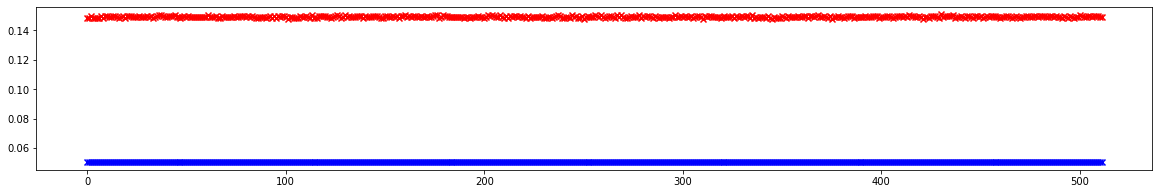

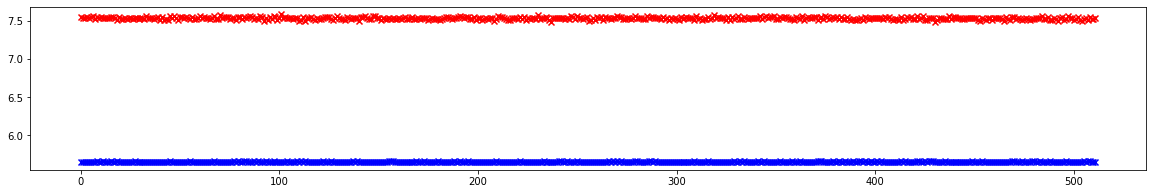

In [19]:
# In this example, fit from trajectories near IP with 2-turn matrix is more accurate

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 1].cpu().numpy(), color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 3].cpu().numpy(), color='red', marker='x')
plt.show()

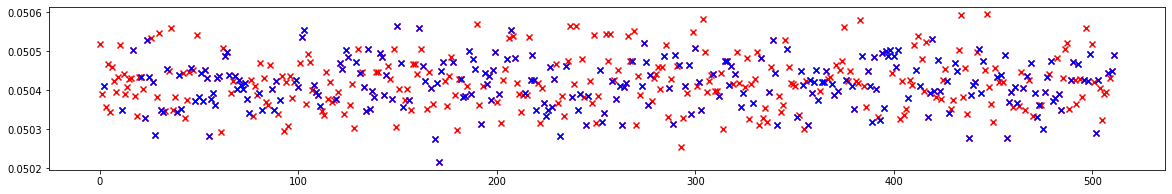

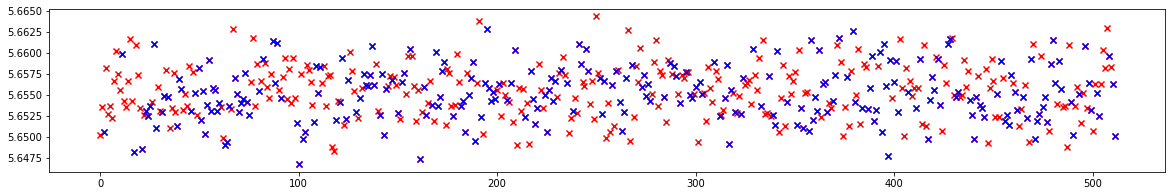

tensor(249)


In [20]:
# Generate tune mask

from harmonica.statistics import standardize
from harmonica.statistics import median, biweight_midvariance
from harmonica.anomaly import threshold

factor = torch.tensor(5.0, dtype=dtype, device=device)

tune_x = standardize(data[:, 0].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_x = threshold(tune_x, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

tune_y = standardize(data[:, 1].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_y = threshold(tune_y, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 0][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 2][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.show()

print((mask_x[index]*mask_y[index]).sum())

In [21]:
# Process twiss

from harmonica.statistics import weighted_mean, weighted_variance

value_nux = weighted_mean(data[:, 0], weight=mask_x*mask_y)
value_nuy = weighted_mean(data[:, 1], weight=mask_x*mask_y)
value_n11 = weighted_mean(data[:, 2], weight=mask_x*mask_y)
value_n33 = weighted_mean(data[:, 3], weight=mask_x*mask_y)
value_n21 = weighted_mean(data[:, 4], weight=mask_x*mask_y)
value_n43 = weighted_mean(data[:, 5], weight=mask_x*mask_y)
value_n13 = weighted_mean(data[:, 6], weight=mask_x*mask_y)
value_n31 = weighted_mean(data[:, 7], weight=mask_x*mask_y)
value_n14 = weighted_mean(data[:, 8], weight=mask_x*mask_y)
value_n41 = weighted_mean(data[:, 9], weight=mask_x*mask_y)

error_nux = weighted_variance(data[:, 0], weight=mask_x*mask_y).sqrt()
error_nuy = weighted_variance(data[:, 1], weight=mask_x*mask_y).sqrt()
error_n11 = weighted_variance(data[:, 2], weight=mask_x*mask_y).sqrt()
error_n33 = weighted_variance(data[:, 3], weight=mask_x*mask_y).sqrt()
error_n21 = weighted_variance(data[:, 4], weight=mask_x*mask_y).sqrt()
error_n43 = weighted_variance(data[:, 5], weight=mask_x*mask_y).sqrt()
error_n13 = weighted_variance(data[:, 6], weight=mask_x*mask_y).sqrt()
error_n31 = weighted_variance(data[:, 7], weight=mask_x*mask_y).sqrt()
error_n14 = weighted_variance(data[:, 8], weight=mask_x*mask_y).sqrt()
error_n41 = weighted_variance(data[:, 9], weight=mask_x*mask_y).sqrt()

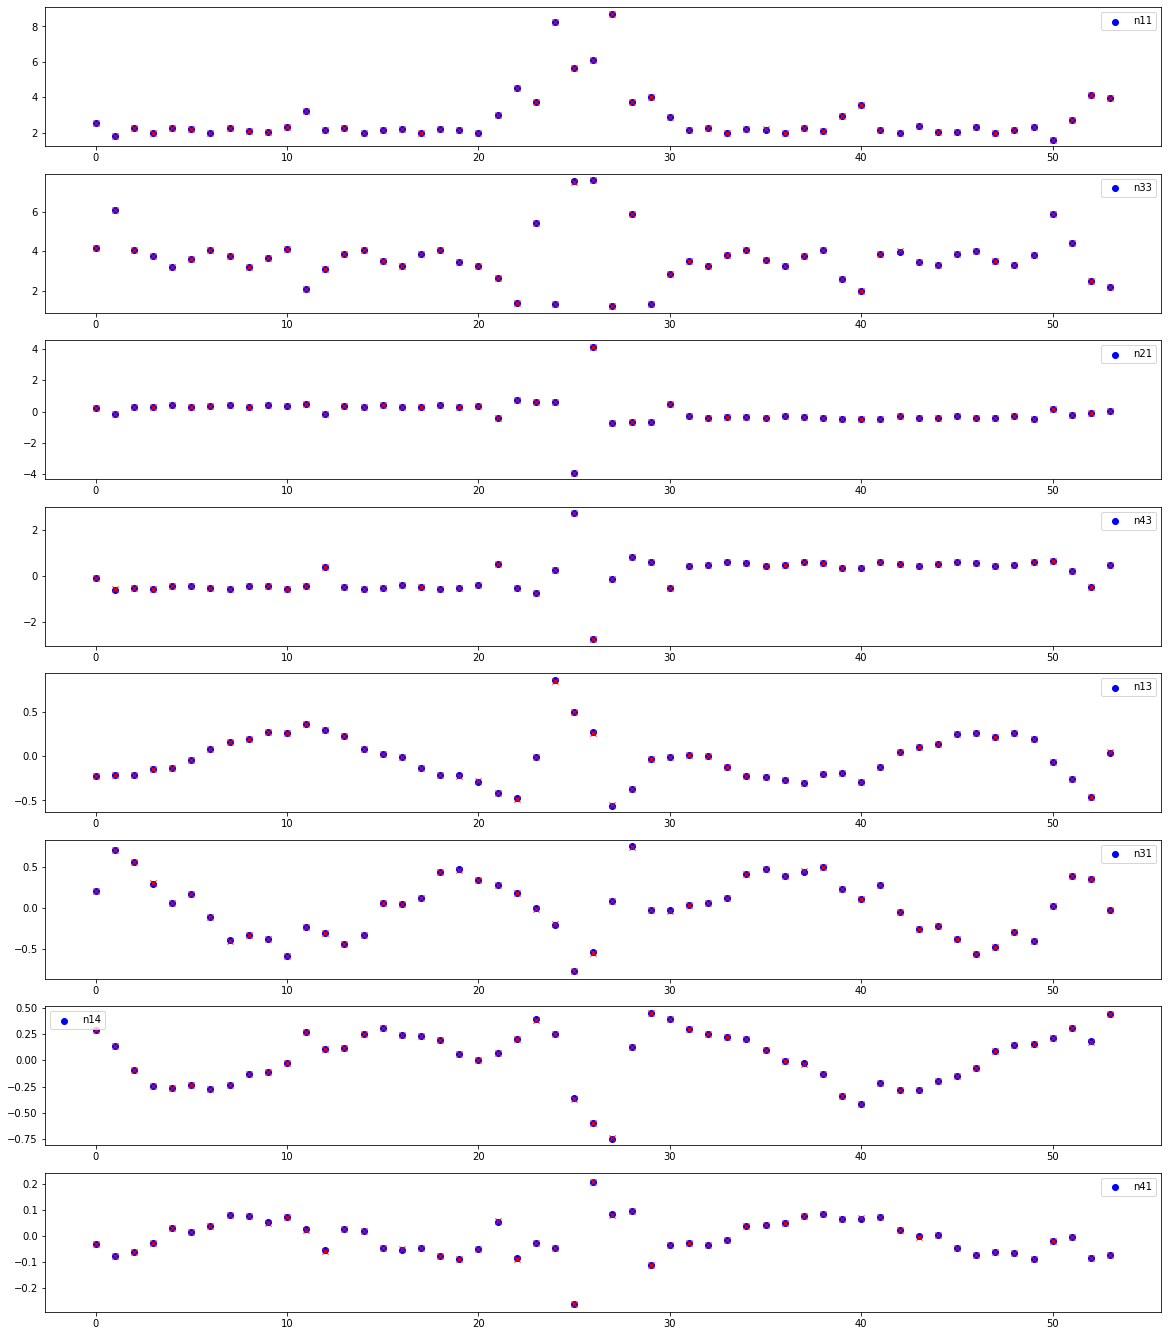

tensor(5.124299807534e-02, dtype=torch.float64)
tensor(9.483241959438e-02, dtype=torch.float64)
tensor(6.820650281861e-02, dtype=torch.float64)
tensor(9.345992053690e-02, dtype=torch.float64)
tensor(4.393982624140e-02, dtype=torch.float64)
tensor(6.431355882273e-02, dtype=torch.float64)
tensor(3.311491507835e-02, dtype=torch.float64)
tensor(3.115298094758e-02, dtype=torch.float64)


In [ ]:
# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())